In [2]:
#CREATES FX PRICES RELATION

import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
#import mysql.connector
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
import warnings
import joblib
from datetime import datetime
from datetime import timedelta
from datetime import date
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin

def Average(lst):
    return sum(lst) / len(lst)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df

def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def round_up(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.ceil(n * multiplier) / multiplier)

def Filter_df(tbf_df, merging_dates_list):
    
    filter_df = pd.DataFrame(merging_dates_list, columns=['Date'])
    merged_df = pd.merge(tbf_df, filter_df, on='Date')
    merged_df.index = filter_df['Date'] 
    merged_df.index.name = 'Date'
    merged_df.drop(['Date'], axis=1, inplace=True)
    
    return merged_df

def on_selection(value):
    global choice
    choice = value
    root.destroy()
    
def PCA_DR(X, VarT):
    
    U, S, Vt = np.linalg.svd(X)
    pca = PCA(n_components = VarT)
    XD = pca.fit_transform(X)
    PCAL = len(XD[0, :])
    W = Vt.T[:, :PCAL]

    return W
    
def Transform_Final(Full_df, Tail_df, VarT):
            
    pca_key = PCA_DR(np.array(Full_df), VarT)  ##Slim_df
    Scaled_DR_df = pd.DataFrame(np.array(Full_df).dot(pca_key), index = Full_df.index)
    ScaledT_DR_df = pd.DataFrame(np.array(Tail_df).dot(pca_key), index = Tail_df.index)
            
    return Scaled_DR_df, ScaledT_DR_df

dbase = "visiblealpha_laptop"
dbase_metrics = "metrics_laptop"

conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list = pd.DataFrame(tables_list, columns=['Old'])['Old'].values.tolist()

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))

query_prices = 'SELECT * FROM prices_relation'    
Prices_df = pd.read_sql_query(query_prices, engine)
Prices_df = Set_DF(Prices_df)
Prices_df = DD_Index(Prices_df)
Prices_df.sort_index(inplace = True)

query_DMRates = 'SELECT * FROM global_rates_dm'    
DM_Rates_df = pd.read_sql_query(query_DMRates, engine)
DM_Rates_df = Set_DF(DM_Rates_df)
DM_Rates_df = DD_Index(DM_Rates_df)

FX_Pairs_List = ['EURUSD', 'EURGBP', 'EURJPY', 'EURAUD', 'EURCAD', 'EURMXN', 'EURBRL', 'GBPUSD', 'GBPJPY', 'GBPAUD', 'GBPCAD', 'GBPMXN', 'GBPBRL', 'AUDUSD', 'AUDJPY', 'AUDCAD', 'AUDMXN', 'AUDBRL', 'USDJPY', 'USDCAD', 'USDMXN', 'USDBRL', 'CADJPY', 'CADMXN', 'CADBRL', 'BRLMXN', 'BRLJPY', 'MXNJPY']
Europe_list = ['ESP', 'FRA', 'GER', 'ITA', 'NED']
corr_list = []

macro_dict = {'BRA': 'br', 'AUS': 'au', 'CAN': 'ca', 'ESP': 'es', 'EUROPE': 'ea', 'FRA': 'fr', 'GER': 'de', 'ITA': 'it', 'UK': 'gb', 'US': 'us', 'JPN': 'jp', 'MEX': 'mx', 'NED': 'nl'}
ccy_dict = {'EUR': 'EUROPE', 'GBP': 'UK', 'AUD': 'AUS', 'CAD': 'CAN', 'JPY': 'JPN', 'MXN': 'MEX', 'USD': 'US', 'BRL': 'BRA'}

att_threshold = 5
att_window_factor = 1.00
corr_threshold = 0.225
corr_percentile = 0.85 #0.875
pca_threshold = 15
window = 21
lag_returns = 10
correlation_window_ST = 300 #350
correlation_window_MT = 550 #700
initial_shift = 252
var_target = 0.85
Fade_Parameter = 0.95
lower_bound = -10.00
upper_bound = +10.00

ext = ''
opt = input('(O)ld or (N)ew? ').upper()
if (opt == 'N'):
    att_threshold = 4
    att_window_factor = 1.00
    corr_threshold = 0.25
    corr_percentile = 0.875 #0.875
    pca_threshold = 20
    window = 21
    lag_returns = 10
    correlation_window_ST = 175 #350
    correlation_window_MT = 300 #700
    initial_shift = 252
    var_target = 0.85
    Fade_Parameter = 0.95
    lower_bound = -10.00
    upper_bound = +10.00
    ext = '_new'

query_fxprices = 'SELECT * FROM fxprices_relation'    
FX_Prices_df = pd.read_sql_query(query_fxprices, engine)
FX_Prices_df = Set_DF(FX_Prices_df)
FX_Prices_df = DD_Index(FX_Prices_df)
    
corr_choice = input('Correlations (S)hort Term, (M)edium Term or Both (empty): ').upper()
if (corr_choice == 'S'):
    corr_list.append(correlation_window_ST)
elif (corr_choice == 'M'):
    corr_list.append(correlation_window_MT)
else:
    corr_list = [correlation_window_ST, correlation_window_MT]
    
owr = False
skip = False
opt = input("(E)xpand/(N)ew/(O)verwrite/(U)pdate/(S)kip): ").upper()
if (opt == 'N') | (opt == 'O') | (opt == 'E'):
    Start_Date = input("Enter Start Date (empty for ALL): (YY/MM/DD)")
    if (Start_Date != ''):
        Start_Date = datetime.strptime(Start_Date, "%y/%m/%d").date()
    else:
        Start_Date = FX_Prices_df.index[0]
    if (opt == 'N') | (opt == 'E'):
        owr = True
elif (opt == 'U'):
    Start_Date = FX_Prices_df.index[-2]
else:
    Start_Date = FX_Prices_df.index[0]
    skip = True

if (opt == 'N') | (opt == 'O') | (opt == 'E'):
    End_Date = input("Enter End Date (empty for ALL): (YY/MM/DD)")
    if (End_Date != ''):
        End_Date = datetime.strptime(End_Date, "%y/%m/%d").date()
    else:
        End_Date = FX_Prices_df.index[-1]
else:
    End_Date = FX_Prices_df.index[-1]
    
date_array = FX_Prices_df[FX_Prices_df.index >= Start_Date].index.values
date_range = date_array[date_array <= End_Date].tolist()
GroundZero = datetime.strptime('12-01-01', '%y-%m-%d').date()
GroundLast = Prices_df.index[-1]

try:    
    query_forecasts = 'SELECT * FROM lr_fxforecasts_relation' + ext   
    LR_FX_Forecast_df = pd.read_sql_query(query_forecasts, engine)
    LR_FX_Forecast_df = Set_DF(LR_FX_Forecast_df)
    LR_FX_Forecast_df = DD_Index(LR_FX_Forecast_df)
except:
    LR_FX_Forecast_df = pd.DataFrame(np.nan, index = pd.Index(date_range, name = 'Dates'), columns = ['Dummy'])

try:
    query_forecasts = 'SELECT * FROM rf_fxforecasts_relation' + ext 
    RF_FX_Forecast_df = pd.read_sql_query(query_forecasts, engine)
    RF_FX_Forecast_df = Set_DF(RF_FX_Forecast_df)
    RF_FX_Forecast_df = DD_Index(RF_FX_Forecast_df)
except:
    RF_FX_Forecast_df = pd.DataFrame(np.nan, index = pd.Index(date_range, name = 'Dates'), columns = ['Dummy'])
    
try:
    query_forecast = 'SELECT * FROM en_fxforecasts_relation' + ext 
    EN_FX_Forecast_df = pd.read_sql_query(query_forecast, engine)
    EN_FX_Forecast_df = Set_DF(EN_FX_Forecast_df)
    EN_FX_Forecast_df = DD_Index(EN_FX_Forecast_df)
except:
    EN_FX_Forecast_df = pd.DataFrame(np.nan, index = pd.Index(date_range, name = 'Dates'), columns = ['Dummy'])
    
if (owr):
    LR_FX_Forecast_df = pd.DataFrame(np.nan, index = pd.Index(date_range, name = 'Dates'), columns = ['Dummy'])
    RF_FX_Forecast_df = pd.DataFrame(np.nan, index = pd.Index(date_range, name = 'Dates'), columns = ['Dummy'])
    EN_FX_Forecast_df = pd.DataFrame(np.nan, index = pd.Index(date_range, name = 'Dates'), columns = ['Dummy'])
    
FX_List = FX_Prices_df.columns.values.tolist()  
choice_list = FX_List.copy()
choice_list.append('ALL')
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *choice_list, command = on_selection)
tk.Label(root, text = "Choose a pair").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()
    
FX_Prices_df.fillna(method = 'ffill', inplace = True)
FX_Prices_df.dropna(inplace = True)
today = FX_Prices_df.index[-1]
if (today.weekday() == 5):
    today = today - timedelta(1)
elif (today.weekday() == 6):
    today = today - timedelta(2)
    
Current_Pxs_df = FX_Prices_df[FX_Prices_df.index >= (GroundZero - 2 * timedelta(lag_returns))]
FX_daily_returns_df = Current_Pxs_df.pct_change()
FX_window_returns_df = round(100 * ((1 + FX_daily_returns_df).rolling(lag_returns).apply(np.prod) - 1), 2).dropna()
FX_window_std_df = round(100 * FX_daily_returns_df.ewm(halflife = 100).std() * np.sqrt(lag_returns), 2)
FX_momentum_df = round(pd.DataFrame(np.array(FX_window_returns_df) / np.array(FX_window_std_df[FX_window_std_df.index >= FX_window_returns_df.index[0]]), index = FX_window_returns_df.index, columns = FX_window_returns_df.columns), 2)
NormalSTD_df = (Current_Pxs_df * (FX_window_std_df / 100)).dropna()

query_DMRates = 'SELECT * FROM global_rates_dm'    
DM_Rates_df = pd.read_sql_query(query_DMRates, engine)
DM_Rates_df = Set_DF(DM_Rates_df)
DM_Rates_df = DD_Index(DM_Rates_df)
DM_Rates_df = DM_Rates_df.rename(columns = {'EUROPE 2Y': 'EUROPE GOVT 2Y', 'EUROPE 5Y': 'EUROPE GOVT 5Y', 'EUROPE 10Y': 'EUROPE GOVT 10Y', 'EUROPE 30Y': 'EUROPE GOVT 30Y'})

us_macro_df_name = 'us_macro'
query_us_macro = "SELECT * FROM " + us_macro_df_name
us_macro_df = pd.read_sql_query(query_us_macro, engine)
us_macro_df = Set_DF(us_macro_df)
us_macro_df = DD_Index(us_macro_df)
us_extra_fields = pd.read_csv(r'C:/Users/Utilizador/OneDrive/Documentos/Malta/Systematic/selected_fields_usmacro.csv')
us_macro_df = us_macro_df[us_extra_fields['FIELDS']]
us_macro_df['ISM NEW ORDERS/INVENTORIES'] = us_macro_df['ISM MANUFACTURING NEW ORDERS'] / us_macro_df['ISM MANUFACTURING INVENTORIES']
us_macro_df.columns = us_macro_df.columns.map(lambda x: x + '_US')

FX_Prices_df = FX_Prices_df[FX_Prices_df.index >= GroundZero]
FX_Prices_df = FX_Prices_df[FX_Prices_df.index <= GroundLast]
Aux_df = pd.DataFrame(np.nan, index = pd.Index(FX_Prices_df.index, name = 'Dates'), columns = ['Dummy'])
us_macro_df = Aux_df.join(us_macro_df)
us_macro_df.sort_index(inplace = True)
us_macro_df = us_macro_df.fillna(method = 'ffill')
us_macro_df.drop(['Dummy'], axis = 1, inplace = True)

scaling_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())
])

FX_Pairs_List = []
if (choice == 'ALL'):
    FX_Pairs_List = FX_List.copy()
else:
    FX_Pairs_List.append(choice)

if (not skip):
    poly_features = PolynomialFeatures(degree = 4, include_bias = False)
    forest_reg = RandomForestRegressor()
    lin_reg = LinearRegression()
    lin_reg_en = ElasticNet(alpha = 8, l1_ratio = 0.5)
    
    last_lr_forecast = 0
    last_en_forecast = 0
    for pair in FX_Pairs_List:
        ccy1 = pair[:3]
        ccy2 = pair[3:6]
        ccy_list_ttl = [ccy1, ccy2]
        ccy_list = [ccy for ccy in ccy_list_ttl if ccy != 'USD']
        extra_macro_df = pd.DataFrame(np.nan, index = us_macro_df.index, columns = ['Dummy'])
        for ccy in ccy_list_ttl:
            if (ccy in ccy_list):
                extra_list = []
                extra_country = ccy_dict[ccy]
                extra_list.append(extra_country)
                if (extra_country == 'EUROPE'):
                    extra_list = extra_list + Europe_list.copy()
                for country in extra_list:
                    extra_macro_df_name = macro_dict[country] + '_macro'
                    query_extra_macro = "SELECT * FROM " + extra_macro_df_name
                    new_macro_df = pd.read_sql_query(query_extra_macro, engine)
                    new_macro_df = Set_DF(new_macro_df)
                    new_macro_df = DD_Index(new_macro_df)
                    selected_extra_fields = pd.read_csv(r'C:/Users/Utilizador/OneDrive/Documentos/Malta/Systematic/selected_fields_' + country.lower() + 'macro.csv')
                    new_macro_df = new_macro_df[selected_extra_fields['FIELDS']]
                    new_macro_df.columns = new_macro_df.columns.map(lambda x: x + '_' + country)
                    extra_macro_df = extra_macro_df.join(new_macro_df)
            DM_Rates_df_slice = DM_Rates_df.T[DM_Rates_df.rename(columns = {'AUS GOVT 2Y': 'AUD 2Y', 'AUS GOVT 5Y': 'AUD 5Y', 'AUS GOVT 10Y': 'AUD 10Y', 'AUS GOVT 30Y': 'AUD 30Y'}).columns.map(lambda x: x.find(ccy_dict[ccy])) != -1].T
            if (len(DM_Rates_df_slice.columns) > 0):
                extra_macro_df = extra_macro_df.join(DM_Rates_df_slice)
        DM_Rates_df_US_slice = DM_Rates_df.T[DM_Rates_df.rename(columns = {'AUS GOVT 2Y': 'AUD 2Y', 'AUS GOVT 5Y': 'AUD 5Y', 'AUS GOVT 10Y': 'AUD 10Y', 'AUS GOVT 30Y': 'AUD 30Y'}).columns.map(lambda x: x.find('US')) != -1].T
        if ('USD' not in ccy_list_ttl):
            extra_macro_df = extra_macro_df.join(DM_Rates_df_US_slice)
        extra_macro_df.drop(['Dummy'], axis = 1, inplace = True)
        extra_macro_df.fillna(method = 'ffill', inplace = True)
        extra_macro_df.fillna(extra_macro_df.mean(), inplace = True)
        extra_macro_df.dropna(thresh = 10, inplace = True) 
        
        country01 = ccy_dict[ccy1]
        country02 = ccy_dict[ccy2]
        full_macro_df = us_macro_df.join(extra_macro_df)
        ccy01_b = False
        ccy02_b = False
        if (len(full_macro_df.T[full_macro_df.columns.map(lambda x: x.find(ccy1)) != -1].T.columns.values.tolist()) > 0):
            ccyone2y_series = full_macro_df.T[full_macro_df.columns.map(lambda x: x.find(country01 + ' GOVT 2Y')) != -1].T[country01 + ' GOVT 2Y']
            ccyone10y_series = full_macro_df.T[full_macro_df.columns.map(lambda x: x.find(country01 + ' GOVT 10Y')) != -1].T[country01 + ' GOVT 10Y']
            ccyone2y_series_mav = (ccyone2y_series - ccyone2y_series.rolling(window).mean())
            ccyone2y_series_mav.name = 'CCY01 2Y MAV'
            ccyone10y_series_mav = (ccyone10y_series - ccyone10y_series.rolling(window).mean())
            ccyone10y_series_mav.name = 'CCY01 10Y MAV'
            ccy01_yc_series = ccyone10y_series - ccyone2y_series
            ccy01_yc_series.name = 'CCY01 YC'
            ccy01_yc_series_mav = (ccy01_yc_series - ccy01_yc_series.rolling(window).mean())
            ccy01_yc_series_mav.name = 'CCY01 YC MAV'
            ccy01_b = True
            full_macro_df = full_macro_df.join(ccyone2y_series_mav).join(ccyone10y_series_mav).join(ccy01_yc_series).join(ccy01_yc_series_mav)
            
        if (len(full_macro_df.T[full_macro_df.columns.map(lambda x: x.find(ccy2)) != -1].T.columns.values.tolist()) > 0):
            ccytwo2y_series = full_macro_df.T[full_macro_df.columns.map(lambda x: x.find(country02 + ' GOVT 2Y')) != -1].T[country02 + ' GOVT 2Y']
            ccytwo10y_series = full_macro_df.T[full_macro_df.columns.map(lambda x: x.find(country02 + ' GOVT 10Y')) != -1].T[country02 + ' GOVT 10Y']
            ccytwo2y_series_mav = (ccytwo2y_series - ccytwo2y_series.rolling(window).mean())
            ccytwo2y_series_mav.name = 'CCY02 2Y MAV'
            ccytwo10y_series_mav = (ccytwo10y_series - ccytwo10y_series.rolling(window).mean())
            ccytwo10y_series_mav.name = 'CCY02 10Y MAV'
            ccy02_yc_series = ccytwo10y_series - ccytwo2y_series
            ccy02_yc_series.name = 'CCY02 YC'
            ccy02_yc_series_mav = (ccy02_yc_series - ccy02_yc_series.rolling(window).mean())
            ccy02_yc_series_mav.name = 'CCY02 YC MAV'
            ccy02_b = True
            full_macro_df = full_macro_df.join(ccytwo2y_series_mav).join(ccytwo10y_series_mav).join(ccy02_yc_series).join(ccy02_yc_series_mav)
            
        if (ccy01_b) & (ccy02_b):
            diff2y_series = ccyone2y_series - ccytwo2y_series
            diff2y_series.name = '2Y Diff'
            diff10y_series = ccyone10y_series - ccytwo10y_series
            diff10y_series.name = '10Y Diff'
            full_macro_df = full_macro_df.join(diff2y_series).join(diff10y_series)
        
        us2y_series = DM_Rates_df.T[DM_Rates_df.columns.map(lambda x: x.find('US GOVT 2Y')) != -1].T['US GOVT 2Y']
        us10y_series = DM_Rates_df.T[DM_Rates_df.columns.map(lambda x: x.find('US GOVT 10Y')) != -1].T['US GOVT 10Y']
        us2y_series_mav = (us2y_series - us2y_series.rolling(window).mean())
        us2y_series_mav.name = 'US 2Y MAV'
        us10y_series_mav = (us10y_series - us10y_series.rolling(window).mean())
        us10y_series_mav.name = 'US 10Y MAV'
        us_yc_series = us10y_series - us2y_series
        us_yc_series.name = 'US YC'
        us_yc_series_mav = (us_yc_series - us_yc_series.rolling(window).mean())
        us_yc_series_mav.name = 'US YC MAV'
        vix_series = Prices_df['VIX']
        vix_series_mav = (vix_series - vix_series.rolling(window).mean())
        vix_series_mav.name = 'VIX MAV'
        move2_series = (us2y_series.rolling(window).std() * np.sqrt(1 / window) * 100).rolling(window).mean()
        move2_series.name = 'US MOVE 2Y'
        move2_series_mav = (move2_series - move2_series.rolling(window).mean())
        move2_series_mav.name = 'US MOVE 2Y MAV'
        move10_series = (us10y_series.rolling(window).std() * np.sqrt(1 / window) * 100).rolling(window).mean()
        move10_series.name = 'US MOVE 10Y'
        move10_series_mav = (move10_series - move10_series.rolling(window).mean())
        move10_series_mav.name = 'US MOVE 10Y MAV'
        crude_series = Prices_df['Crude Oil USD/Bbl']
        crude_series_mav = (crude_series - crude_series.rolling(window).mean())
        crude_series_mav.name = 'Crude MAV'
        ry_series = (us10y_series - Prices_df['T10YIE'])
        ry_series.name = 'US RY'
        ry_series_mav = (ry_series - ry_series.rolling(window).mean())
        ry_series_mav.name = 'US RY MAV'
        inf5y5y_series = Prices_df['T5YIFR']
        inf5y5y_series_mav = (inf5y5y_series - inf5y5y_series.rolling(window).mean())
        inf5y5y_series_mav.name = 'US 5Y5Y MAV'
        totbkcr_series = Prices_df['TOTBKCR Velocity']
        totbkcr_series_mav = (totbkcr_series - totbkcr_series.rolling(window).mean())
        totbkcr_series_mav.name = 'US TOTBKCR Vel MAV'
        totalslar_series = Prices_df['TOTALSLAR']
        totalslar_series_mav = (totalslar_series - totalslar_series.rolling(window).mean())
        totalslar_series_mav.name = 'US TOTALSLAR MAV'
        drcclacbs_series = Prices_df['DRCCLACBS']
        drcclacbs_series_mav = (drcclacbs_series - drcclacbs_series.rolling(window).mean())
        drcclacbs_series_mav.name = 'US DRCCLACBS MAV'
        m2cp_series = Prices_df['M2CP Velocity']
        m2mp_series = Prices_df['M2MP Velocity']
        m2_momentum_series = m2cp_series - m2mp_series
        m2_momentum_series.name = 'US M2 MOMENTUM'
        
        full_macro_df = full_macro_df.join(vix_series).join(vix_series_mav).join(move2_series).join(move2_series_mav).join(move10_series).join(move10_series_mav).join(crude_series).join(crude_series_mav).join(ry_series).join(ry_series_mav).join(inf5y5y_series).join(inf5y5y_series_mav).join(totbkcr_series).join(totbkcr_series_mav).join(totalslar_series).join(totalslar_series_mav).join(drcclacbs_series).join(drcclacbs_series_mav).join(m2cp_series).join(m2mp_series).join(m2_momentum_series)
        if (ccy1 != 'USD') & (ccy2 != 'USD'):
            usd_pair01 = 'USD' + ccy1
            if (usd_pair01 not in FX_Prices_df.columns.values.tolist()):
                usd_pair01 =  ccy1 + 'USD'
            usd_pair02 = 'USD' + ccy2
            if (usd_pair02 not in FX_Prices_df.columns.values.tolist()):
                usd_pair02 = ccy2 + 'USD'
            full_macro_df = full_macro_df.join(us2y_series_mav).join(us10y_series_mav).join(us_yc_series).join(us_yc_series_mav).join(FX_window_std_df[usd_pair01], rsuffix = '_Vol_LN').join(FX_window_std_df[usd_pair02], rsuffix = '_Vol_LN')
        full_macro_df = full_macro_df.join(FX_momentum_df[pair], rsuffix = '_Mom').join(NormalSTD_df[pair], rsuffix = '_Vol_N').join(FX_window_std_df[pair], rsuffix = '_Vol_LN')
        
        RF_RMSE_ttl = 0
        LR_RMSE_ttl = 0
        EN_RMSE_ttl = 0
        Count_RF = 0
        Count_LR = 0
        Count_EN = 0
        for curr_corr in corr_list:
            for idx, current_date in enumerate(date_range): 
                if ((current_date.day == 25) & (current_date.month == 12)) | ((current_date.day == 1) & (current_date.month == 1)):
                    if (current_date in RF_FX_Forecast_df.index):
                        RF_FX_Forecast_df.drop(current_date, inplace = True)
                    if (current_date in LR_FX_Forecast_df.index):
                        LR_FX_Forecast_df.drop(current_date, inplace = True)
                    if (current_date in EN_FX_Forecast_df.index):
                        EN_FX_Forecast_df.drop(current_date, inplace = True)
                    date_range.remove(current_date)
                else:
                    Prev_date = date_range[date_range.index(current_date) - 1]
                    Forecast_string = pair + ' CORR ' + str(curr_corr)
                    if (Forecast_string not in RF_FX_Forecast_df.columns.values.tolist()):
                        RF_FX_Forecast_df[Forecast_string] = np.nan
                    if (Forecast_string not in LR_FX_Forecast_df.columns.values.tolist()):
                        LR_FX_Forecast_df[Forecast_string] = np.nan
                    if (Forecast_string not in EN_FX_Forecast_df.columns.values.tolist()):
                        EN_FX_Forecast_df[Forecast_string] = np.nan

                    Unscaled_TrainData_df = full_macro_df[full_macro_df.index <= current_date]
                    FX_Prices_series = FX_Prices_df[FX_Prices_df.index <= current_date][pair]
                    
                    Unscaled_TrainData_df = Unscaled_TrainData_df[- int(round(att_window_factor * curr_corr, 0)): ]
                    FX_Prices_series = FX_Prices_series[- int(round(att_window_factor * curr_corr, 0)):]
                    
                    Unscaled_TrainData_df.sort_index(inplace = True)
                    Labels_series = (FX_Prices_series.shift(-10) / FX_Prices_series - 1)
                    Labels_series.name = pair + ' FWD Returns'

                    Unscaled_TrainData_Labeled_df = Unscaled_TrainData_df.join(Labels_series)
                    Corr_df = pd.DataFrame(Unscaled_TrainData_Labeled_df[-curr_corr:].corr()[Labels_series.name].drop(Labels_series.name).dropna())
                    Corr_df['Absolute Corrs'] = abs(Corr_df[Labels_series.name])
                    Corr_df.sort_values(by = ['Absolute Corrs'], inplace = True)
                    corr_quantile = np.quantile(Corr_df['Absolute Corrs'], q = corr_percentile)
                    final_corr_threshold = max(corr_quantile, corr_threshold)
                    Filtered_Corr_df = Corr_df[Corr_df['Absolute Corrs'] > final_corr_threshold]
                    
                    avg_corr = round(Filtered_Corr_df['Absolute Corrs'].mean(), 2)
                    att_exp = min(5, round(avg_corr * 10, 0))
                    Param_Short_List = Filtered_Corr_df.index.values.tolist()
                    Param_count = len(Param_Short_List)
                    print(pair + ' ' + current_date.strftime('%Y-%b-%d') + ' ' + str(curr_corr) + ', ' + str(Param_count) + ' Features, ' + str(avg_corr) + ' Avg Corr')
                    if (Param_count > 0):
                        att_factor = max(att_threshold - Param_count, 1) ** att_exp
                        Unscaled_TrainData_F_df = Unscaled_TrainData_df.T.drop_duplicates().T[Param_Short_List]
                        Unscaled_TrainData_F_df = Unscaled_TrainData_F_df.fillna(method = 'ffill')
                        Unscaled_TrainData_F_df = Unscaled_TrainData_F_df.fillna(method = 'bfill')
                        Unscaled_TrainData_F_df.dropna(thresh = int(round(len(Unscaled_TrainData_F_df.index) / 2, 0)), axis = 1, inplace = True)

                        Scaled_TrainData_df = pd.DataFrame(scaling_pipeline.fit_transform(Unscaled_TrainData_F_df), index = Unscaled_TrainData_F_df.index, columns = Unscaled_TrainData_F_df.columns)
                        Scaled_TrainData_Labeled_df = Scaled_TrainData_df.join(Labels_series)
                        Scaled_TrainData_Labeled_df.dropna(inplace = True)
                        Scaled_TailData_df = Scaled_TrainData_df[Scaled_TrainData_df.index > Scaled_TrainData_Labeled_df.index[-1]]
                        Scaled_Features_df = Scaled_TrainData_Labeled_df.drop(Labels_series.name, axis = 1)
                        
                        if (Param_count >= pca_threshold):
                            FinalScaled_Features_df, FinalScaled_TailData_df = Transform_Final(Scaled_Features_df, Scaled_TailData_df, var_target)
                        else:
                            FinalScaled_Features_df = Scaled_Features_df
                            FinalScaled_TailData_df = Scaled_TailData_df
                        
                        FinalScaled_Features_array = np.array(FinalScaled_Features_df)
                        FinalScaled_TailData_array = np.array(FinalScaled_TailData_df)
                        Poly_Features = poly_features.fit_transform(FinalScaled_Features_array)
                        Poly_Tail = poly_features.fit_transform(FinalScaled_TailData_array)
                        Labels_array = Scaled_TrainData_Labeled_df[Labels_series.name].values
                        
                        try:
                            RF_FX_model = forest_reg.fit(FinalScaled_Features_array, Labels_array)
                            RF_FX_predictions_Train = RF_FX_model.predict(FinalScaled_Features_array)
                            RF_FX_rmse = np.sqrt(mean_squared_error(RF_FX_predictions_Train, Labels_array))
                            RF_RMSE_ttl = RF_RMSE_ttl + RF_FX_rmse
                            RF_Live_FXForecast = round(100 * RF_FX_model.predict(FinalScaled_TailData_array)[-1], 2)
                            RF_FX_Forecast_df.loc[current_date, Forecast_string] = min(upper_bound, max(lower_bound, RF_Live_FXForecast / att_factor))
                            Count_RF = Count_RF + 1
                        except:
                            print('RF Failed')
                            RF_FX_Forecast_df.loc[current_date, Forecast_string] = RF_FX_Forecast_df.loc[Prev_date, Forecast_string] * Fade_Parameter
                        
                        try:
                            LR_FX_model = lin_reg.fit(FinalScaled_Features_array, Labels_array)
                            LR_FX_predictions_Train = LR_FX_model.predict(FinalScaled_Features_array)
                            LR_FX_rmse = np.sqrt(mean_squared_error(LR_FX_predictions_Train, Labels_array))
                            LR_RMSE_ttl = LR_RMSE_ttl + LR_FX_rmse
                            LR_Live_FXForecast = round(100 * LR_FX_model.predict(FinalScaled_TailData_array)[-1], 2)
                            LR_FX_Forecast_df.loc[current_date, Forecast_string] = min(upper_bound, max(lower_bound, LR_Live_FXForecast / att_factor))
                            Count_LR = Count_LR + 1
                        except:
                            print('LR Failed')
                            LR_FX_Forecast_df.loc[current_date, Forecast_string] = LR_FX_Forecast_df.loc[Prev_date, Forecast_string] * Fade_Parameter
                        
                        try:
                            EN_FX_model = lin_reg_en.fit(Poly_Features, Labels_array)
                            EN_FX_predictions_Train = EN_FX_model.predict(Poly_Features)
                            EN_FX_rmse = np.sqrt(mean_squared_error(EN_FX_predictions_Train, Labels_array))
                            EN_RMSE_ttl = EN_RMSE_ttl + EN_FX_rmse
                            EN_Live_FXForecast = round(100 * EN_FX_model.predict(Poly_Tail)[-1], 2)
                            EN_FX_Forecast_df.loc[current_date, Forecast_string] = min(upper_bound, max(lower_bound, EN_Live_FXForecast / att_factor))
                            Count_EN = Count_EN + 1
                        except:
                            print('EN Failed')
                            EN_FX_Forecast_df.loc[current_date, Forecast_string] = EN_FX_Forecast_df.loc[Prev_date, Forecast_string] * Fade_Parameter

                    else:
                        print('No Relevant Correlations')
                        RF_FX_Forecast_df.loc[current_date, Forecast_string] = RF_FX_Forecast_df.loc[Prev_date, Forecast_string] * Fade_Parameter
                        LR_FX_Forecast_df.loc[current_date, Forecast_string] = LR_FX_Forecast_df.loc[Prev_date, Forecast_string] * Fade_Parameter
                        EN_FX_Forecast_df.loc[current_date, Forecast_string] = EN_FX_Forecast_df.loc[Prev_date, Forecast_string] * Fade_Parameter
            
            RF_RMSE = round(100 * RF_RMSE_ttl / Count_RF, 2)
            LR_RMSE = round(100 * LR_RMSE_ttl / Count_LR, 2)
            EN_RMSE = round(100 * EN_RMSE_ttl / Count_EN, 2)
            print('')
            print(pair + ' RF RMSE (Train): ' + str(RF_RMSE))
            print(pair + ' LR RMSE (Train): ' + str(LR_RMSE))
            print(pair + ' EN RMSE (Train): ' + str(EN_RMSE))
            print('')

if ('Dummy' in RF_FX_Forecast_df.columns):
    RF_FX_Forecast_df.drop(['Dummy'], axis = 1, inplace = True)
if ('Dummy' in LR_FX_Forecast_df.columns):
    LR_FX_Forecast_df.drop(['Dummy'], axis = 1, inplace = True)
if ('Dummy' in EN_FX_Forecast_df.columns):
    EN_FX_Forecast_df.drop(['Dummy'], axis = 1, inplace = True)
    
RF_FX_Forecast_df.sort_index(inplace = True)
LR_FX_Forecast_df.sort_index(inplace = True)
EN_FX_Forecast_df.sort_index(inplace = True)

if (opt != 'S'):
    proceed_save = input('Save (Y/N)? ').upper()
    if (proceed_save == 'Y'):
        RF_FX_Forecast_df.clip(lower_bound, upper_bound).to_sql('rf_fxforecasts_relation' + ext, engine, index = True, if_exists = 'replace')
        LR_FX_Forecast_df.clip(lower_bound, upper_bound).to_sql('lr_fxforecasts_relation' + ext, engine, index = True, if_exists = 'replace')
        EN_FX_Forecast_df.clip(lower_bound, upper_bound).to_sql('en_fxforecasts_relation' + ext, engine, index = True, if_exists = 'replace')
        

MM_FX_Forecast_df = round((RF_FX_Forecast_df + LR_FX_Forecast_df + EN_FX_Forecast_df) / 3, 2)
MM_FX_Forecast_df = MM_FX_Forecast_df.join(round(100 * ((FX_Prices_series.shift(-10) / FX_Prices_series - 1)), 2))
print('')
print(MM_FX_Forecast_df.iloc[-1].dropna().sort_values())
print('')
print(pd.DataFrame(MM_FX_Forecast_df.iloc[-1].dropna()).T.groupby(pd.DataFrame(MM_FX_Forecast_df.iloc[-1].dropna()).T.columns.map(lambda x: x[:6]), axis = 1).sum().T.sort_values(by = [MM_FX_Forecast_df.index[-1]]))
print('')
MM_FX_Forecast_df[-10:]

KeyboardInterrupt: Interrupted by user

In [1]:
#MODEL STATS REVAMPED

from scipy.stats import norm

ewm_factor = 3
LAG_returns = 10

query_fxprices = 'SELECT * FROM fxprices_relation'    
FX_Prices_df = pd.read_sql_query(query_fxprices, engine)
FX_Prices_df = Set_DF(FX_Prices_df)
FX_Prices_df = DD_Index(FX_Prices_df)

FXPairs_List = FX_Prices_df.columns.values.tolist()

query_forecast = 'SELECT * FROM en_fxforecasts_relation'
EN_FX_Forecast_df = pd.read_sql_query(query_forecast, engine)
EN_FX_Forecast_df = Set_DF(EN_FX_Forecast_df)
EN_FX_Forecast_df = DD_Index(EN_FX_Forecast_df)

query_forecast_N = 'SELECT * FROM en_fxforecasts_relation_new'
EN_FX_forecast_N_df = pd.read_sql_query(query_forecast_N, engine)
EN_FX_forecast_N_df = Set_DF(EN_FX_forecast_N_df)
EN_FX_forecast_N_df = DD_Index(EN_FX_forecast_N_df)

query_forecast = 'SELECT * FROM lr_fxforecasts_relation'
LR_FX_Forecast_df = pd.read_sql_query(query_forecast, engine)
LR_FX_Forecast_df = Set_DF(LR_FX_Forecast_df)
LR_FX_Forecast_df = DD_Index(LR_FX_Forecast_df)

query_forecast_N = 'SELECT * FROM lr_fxforecasts_relation_new'
LR_FX_Forecast_N_df = pd.read_sql_query(query_forecast_N, engine)
LR_FX_Forecast_N_df = Set_DF(LR_FX_Forecast_N_df)
LR_FX_Forecast_N_df = DD_Index(LR_FX_Forecast_N_df)

query_forecast = 'SELECT * FROM rf_fxforecasts_relation'
RF_FX_Forecast_df = pd.read_sql_query(query_forecast, engine)
RF_FX_Forecast_df = Set_DF(RF_FX_Forecast_df)
RF_FX_Forecast_df = DD_Index(RF_FX_Forecast_df)

query_forecast_N = 'SELECT * FROM rf_fxforecasts_relation_new'
RF_FX_Forecast_N_df = pd.read_sql_query(query_forecast_N, engine)
RF_FX_Forecast_N_df = Set_DF(RF_FX_Forecast_N_df)
RF_FX_Forecast_N_df = DD_Index(RF_FX_Forecast_N_df)

cp_o = int(RF_FX_Forecast_df.columns[0][-3:])
mp_o = int(RF_FX_Forecast_df.columns[1][-3:])
cp_n = int(RF_FX_Forecast_N_df.columns[0][-3:])
mp_n = int(RF_FX_Forecast_N_df.columns[1][-3:])

query_rv = 'SELECT * FROM best_fxrv_parameters_instant'
RV_o_df = pd.read_sql_query(query_rv, engine)
RV_o_df = Set_DF(RV_o_df)
RV_o_df = DD_Index(RV_o_df)

query_rv = 'SELECT * FROM best_fxrv_parameters_instant_new'
RV_n_df = pd.read_sql_query(query_rv, engine)
RV_n_df = Set_DF(RV_n_df)
RV_n_df = DD_Index(RV_n_df)

OPT = input('(S)tats or (B)acktest? ').upper()

if (OPT == 'B'):
    Start_Date = input("Enter Start Date: (YY/MM/DD)")
    Start_Date = datetime.strptime(Start_Date, "%y/%m/%d").date()
    
    EN_FX_Forecast_df = EN_FX_Forecast_df[EN_FX_Forecast_df.index >= Start_Date]
    EN_FX_forecast_N_df = EN_FX_forecast_N_df[EN_FX_forecast_N_df.index >= Start_Date]
    LR_FX_Forecast_df = LR_FX_Forecast_df[LR_FX_Forecast_df.index >= Start_Date]
    LR_FX_Forecast_N_df = LR_FX_Forecast_N_df[LR_FX_Forecast_N_df.index >= Start_Date]
    RF_FX_Forecast_df = RF_FX_Forecast_df[RF_FX_Forecast_df.index >= Start_Date]
    RF_FX_Forecast_N_df = RF_FX_Forecast_N_df[RF_FX_Forecast_N_df.index >= Start_Date]

if (OPT != 'B'):
    conf_interval_o = RV_o_df.loc['last', '0']
    std_mult_o = norm.ppf(conf_interval_o)
    UP_On_CP_o = RV_o_df.loc['last', '1']
    UP_Off_CP_o = RV_o_df.loc['last', '2']
    UP_On_MP_o = RV_o_df.loc['last', '3']
    UP_Off_MP_o = RV_o_df.loc['last', '4']
    
    conf_interval_n = RV_n_df.loc['last', '0']
    std_mult_n = norm.ppf(conf_interval_n)
    UP_On_CP_n = RV_n_df.loc['last', '1']
    UP_Off_CP_n = RV_n_df.loc['last', '2']
    UP_On_MP_n = RV_n_df.loc['last', '3']
    UP_Off_MP_n = RV_n_df.loc['last', '4']

    rs_b = False
    if (rs_b):
        LR_FX_Forecast_df = LR_FX_Forecast_df.ewm(halflife = ewm_factor).mean()
        EN_FX_Forecast_df = EN_FX_Forecast_df.ewm(halflife = ewm_factor).mean()

    lr_cp_mult_o = RV_o_df.loc['last', '5']
    rf_cp_mult_o = RV_o_df.loc['last', '6']
    en_cp_mult_o = RV_o_df.loc['last', '7']
    ttl_cp_mult_o = lr_cp_mult_o + en_cp_mult_o + rf_cp_mult_o

    lr_mp_mult_o = RV_o_df.loc['last', '8']
    rf_mp_mult_o = RV_o_df.loc['last', '9']
    en_mp_mult_o = RV_o_df.loc['last', '10']
    ttl_mp_mult_o = lr_mp_mult_o + en_mp_mult_o + rf_mp_mult_o
    
    lr_cp_mult_n = RV_n_df.loc['last', '5']
    rf_cp_mult_n = RV_n_df.loc['last', '6']
    en_cp_mult_n = RV_n_df.loc['last', '7']
    ttl_cp_mult_n = lr_cp_mult_n + en_cp_mult_n + rf_cp_mult_n

    lr_mp_mult_n = RV_n_df.loc['last', '8']
    rf_mp_mult_n = RV_n_df.loc['last', '9']
    en_mp_mult_n = RV_n_df.loc['last', '10']
    ttl_mp_mult_n = lr_mp_mult_n + en_mp_mult_n + rf_mp_mult_n

    mix_cp_forecast_df = (lr_cp_mult_o * LR_FX_Forecast_df + rf_cp_mult_o * RF_FX_Forecast_df + en_cp_mult_o * EN_FX_Forecast_df) / ttl_cp_mult_o
    mix_cp_forecast_N_df = (lr_cp_mult_n * LR_FX_Forecast_N_df + rf_cp_mult_n * RF_FX_Forecast_N_df + en_cp_mult_n * EN_FX_forecast_N_df) / ttl_cp_mult_n
    mix_mp_forecast_df = (lr_mp_mult_o * LR_FX_Forecast_df + rf_mp_mult_o * RF_FX_Forecast_df + en_mp_mult_o * EN_FX_Forecast_df) / ttl_mp_mult_o
    mix_mp_forecast_N_df = (lr_mp_mult_n * LR_FX_Forecast_N_df + rf_mp_mult_n * RF_FX_Forecast_N_df + en_mp_mult_n * EN_FX_forecast_N_df) / ttl_mp_mult_n

    mix_cp_forecast_Adj_df = mix_cp_forecast_df - mix_cp_forecast_df.clip(-20, 20).rolling(int(RV_o_df.loc['last', '16'])).std().rolling(int(RV_o_df.loc['last', '17'])).mean().replace({np.nan: 0}) * std_mult_o
    mix_mp_forecast_Adj_df = mix_mp_forecast_df - mix_mp_forecast_df.clip(-20, 20).rolling(int(RV_o_df.loc['last', '16'])).std().rolling(int(RV_o_df.loc['last', '17'])).mean().replace({np.nan: 0}) * std_mult_o
    mix_cp_forecast_N_Adj_df = mix_cp_forecast_N_df - mix_cp_forecast_N_df.clip(-20, 20).rolling(int(RV_n_df.loc['last', '16'])).std().rolling(int(RV_n_df.loc['last', '17'])).mean().replace({np.nan: 0}) * std_mult_n
    mix_mp_forecast_N_Adj_df = mix_mp_forecast_N_df - mix_mp_forecast_N_df.clip(-20, 20).rolling(int(RV_n_df.loc['last', '16'])).std().rolling(int(RV_n_df.loc['last', '17'])).mean().replace({np.nan: 0}) * std_mult_n

    RMSE_df = pd.DataFrame(np.nan, index = FXPairs_List, columns = ['LR CP Old', 'LR CP New', 'RF CP Old', 'RF CP New', 'EN CP Old', 'EN CP New', 'Mixed CP Old', 'Mixed CP New', 'LR MP Old', 'LR MP New', 'RF MP Old', 'RF MP New', 'EN MP Old', 'EN MP New', 'Mixed MP Old', 'Mixed MP New'])
    ClassAccuracy_df = pd.DataFrame(np.nan, index = FXPairs_List, columns = ['Mixed CP Old', 'Mixed CP New', 'Mixed MP Old', 'Mixed MP New'])
    
    for pair in FXPairs_List:
        CP_Return = 0
        MP_Return = 0
        pair_string_cp_o = pair + ' CORR ' + str(cp_o)
        pair_string_cp_n = pair + ' CORR ' + str(cp_n)
        pair_string_mp_o = pair + ' CORR ' + str(mp_o)
        pair_string_mp_n = pair + ' CORR ' + str(mp_n)
        ret_series_o = (FX_Prices_df.shift(-LAG_returns) / FX_Prices_df - 1).loc[LR_FX_Forecast_df.index][pair]
        ret_series_n = (FX_Prices_df.shift(-LAG_returns) / FX_Prices_df - 1).loc[LR_FX_Forecast_N_df.index][pair]

        lr_cp_RMSE = np.sqrt(mean_squared_error(LR_FX_Forecast_df[pair_string_cp_o].loc[ret_series_o.dropna().index].fillna(0).values, ret_series_o.dropna().values))
        lr_cp_RMSE_N = np.sqrt(mean_squared_error(LR_FX_Forecast_N_df[pair_string_cp_n].loc[ret_series_n.dropna().index].fillna(0).values, ret_series_n.dropna().values))

        en_cp_RMSE = np.sqrt(mean_squared_error(EN_FX_Forecast_df[pair_string_cp_o].loc[ret_series_o.dropna().index].fillna(0).values, ret_series_o.dropna().values))
        en_cp_RMSE_N = np.sqrt(mean_squared_error(EN_FX_forecast_N_df[pair_string_cp_n].loc[ret_series_n.dropna().index].fillna(0).values, ret_series_n.dropna().values))

        rf_cp_RMSE = np.sqrt(mean_squared_error(RF_FX_Forecast_df[pair_string_cp_o].loc[ret_series_o.dropna().index].fillna(0).values, ret_series_o.dropna().values))
        rf_cp_RMSE_N = np.sqrt(mean_squared_error(RF_FX_Forecast_N_df[pair_string_cp_n].loc[ret_series_n.dropna().index].fillna(0).values, ret_series_n.dropna().values))

        lr_mp_RMSE = np.sqrt(mean_squared_error(LR_FX_Forecast_df[pair_string_mp_o].loc[ret_series_o.dropna().index].fillna(0).values, ret_series_o.dropna().values))
        lr_mp_RMSE_N = np.sqrt(mean_squared_error(LR_FX_Forecast_N_df[pair_string_mp_n].loc[ret_series_n.dropna().index].fillna(0).values, ret_series_n.dropna().values))

        en_mp_RMSE = np.sqrt(mean_squared_error(EN_FX_Forecast_df[pair_string_mp_o].loc[ret_series_o.dropna().index].fillna(0).values, ret_series_o.dropna().values))
        en_mp_RMSE_N = np.sqrt(mean_squared_error(EN_FX_forecast_N_df[pair_string_mp_n].loc[ret_series_n.dropna().index].fillna(0).values, ret_series_n.dropna().values))

        rf_mp_RMSE = np.sqrt(mean_squared_error(RF_FX_Forecast_df[pair_string_mp_o].loc[ret_series_o.dropna().index].fillna(0).values, ret_series_o.dropna().values))
        rf_mp_RMSE_N = np.sqrt(mean_squared_error(RF_FX_Forecast_N_df[pair_string_mp_n].loc[ret_series_n.dropna().index].fillna(0).values, ret_series_n.dropna().values))

        mixed_cp_RMSE = np.sqrt(mean_squared_error(mix_cp_forecast_df[pair_string_cp_o].loc[ret_series_o.dropna().index].fillna(0).values, ret_series_o.dropna().values))
        mixed_cp_RMSE_N = np.sqrt(mean_squared_error(mix_cp_forecast_N_df[pair_string_cp_n].loc[ret_series_n.dropna().index].fillna(0).values, ret_series_n.dropna().values))

        mixed_mp_RMSE = np.sqrt(mean_squared_error(mix_mp_forecast_df[pair_string_mp_o].loc[ret_series_o.dropna().index].fillna(0).values, ret_series_o.dropna().values))
        mixed_mp_RMSE_N = np.sqrt(mean_squared_error(mix_mp_forecast_N_df[pair_string_mp_n].loc[ret_series_n.dropna().index].fillna(0).values, ret_series_n.dropna().values))

        RMSE_df.loc[pair, 'LR CP Old'] = round(lr_cp_RMSE, 2)
        RMSE_df.loc[pair, 'LR CP New'] = round(lr_cp_RMSE_N, 2)
        RMSE_df.loc[pair, 'RF CP Old'] = round(rf_cp_RMSE, 2)
        RMSE_df.loc[pair, 'RF CP New'] = round(rf_cp_RMSE_N, 2)
        RMSE_df.loc[pair, 'EN CP Old'] = round(en_cp_RMSE, 2)
        RMSE_df.loc[pair, 'EN CP New'] = round(en_cp_RMSE_N, 2)
        RMSE_df.loc[pair, 'Mixed CP Old'] = round(mixed_cp_RMSE, 2)
        RMSE_df.loc[pair, 'Mixed CP New'] = round(mixed_cp_RMSE_N, 2)
        RMSE_df.loc[pair, 'LR MP Old'] = round(lr_mp_RMSE, 2)
        RMSE_df.loc[pair, 'LR MP New'] = round(lr_mp_RMSE_N, 2)
        RMSE_df.loc[pair, 'RF MP Old'] = round(rf_mp_RMSE, 2)
        RMSE_df.loc[pair, 'RF MP New'] = round(rf_mp_RMSE_N, 2)
        RMSE_df.loc[pair, 'EN MP Old'] = round(en_mp_RMSE, 2)
        RMSE_df.loc[pair, 'EN MP New'] = round(en_mp_RMSE_N, 2)
        RMSE_df.loc[pair, 'Mixed MP Old'] = round(mixed_mp_RMSE, 2)
        RMSE_df.loc[pair, 'Mixed MP New'] = round(mixed_mp_RMSE_N, 2)

        UP_CP_pairSeries = mix_cp_forecast_Adj_df[pair_string_cp_o][mix_cp_forecast_Adj_df[pair_string_cp_o] > UP_On_CP_o]
        DOWN_CP_pairSeries = mix_cp_forecast_df[pair_string_cp_o][mix_cp_forecast_df[pair_string_cp_o] < UP_Off_CP_o]
        if (len(UP_CP_pairSeries) > 0):
            Merged_CP_UP_Series = (pd.concat([UP_CP_pairSeries, DOWN_CP_pairSeries[DOWN_CP_pairSeries.index > UP_CP_pairSeries.index[0]]]).sort_index()).clip(0,1)
            Full_pair_CP_df = pd.DataFrame(ret_series_o).join(Merged_CP_UP_Series)[pair_string_cp_o].fillna(method = 'ffill').dropna()
            CP_Return = pd.DataFrame((1 + pd.DataFrame(Full_pair_CP_df).join(FX_Prices_df.pct_change()[pair].shift(-1)).prod(axis = 1)), columns = ['Factor']).expanding().apply(np.prod).iloc[-1][0]

        UP_MP_pairSeries = mix_mp_forecast_Adj_df[pair_string_mp_o][mix_mp_forecast_Adj_df[pair_string_mp_o] > UP_On_MP_o]
        DOWN_MP_pairSeries = mix_mp_forecast_df[pair_string_mp_o][mix_mp_forecast_df[pair_string_mp_o] < UP_Off_MP_o]
        if (len(UP_MP_pairSeries) > 0):
            Merged_MP_UP_Series = (pd.concat([UP_MP_pairSeries, DOWN_MP_pairSeries[DOWN_MP_pairSeries.index > UP_MP_pairSeries.index[0]]]).sort_index()).clip(0,1)
            Full_pair_MP_df = pd.DataFrame(ret_series_o).join(Merged_MP_UP_Series)[pair_string_mp_o].fillna(method = 'ffill').dropna()
            MP_Return = pd.DataFrame((1 + pd.DataFrame(Full_pair_MP_df).join(FX_Prices_df.pct_change()[pair].shift(-1)).prod(axis = 1)), columns = ['Factor']).expanding().apply(np.prod).iloc[-1][0]

        ClassAccuracy_df.loc[pair, 'Mixed CP Old'] = round(CP_Return, 2)
        ClassAccuracy_df.loc[pair, 'Mixed MP Old'] = round(MP_Return, 2)

        UP_CP_pairSeries = mix_cp_forecast_N_Adj_df[pair_string_cp_n][mix_cp_forecast_N_Adj_df[pair_string_cp_n] > UP_On_CP_n]
        DOWN_CP_pairSeries = mix_cp_forecast_N_df[pair_string_cp_n][mix_cp_forecast_N_df[pair_string_cp_n] < UP_Off_CP_n]
        if (len(UP_CP_pairSeries) > 0):
            Merged_CP_UP_Series = (pd.concat([UP_CP_pairSeries, DOWN_CP_pairSeries[DOWN_CP_pairSeries.index > UP_CP_pairSeries.index[0]]]).sort_index()).clip(0,1)
            Full_pair_CP_df = pd.DataFrame(ret_series_n).join(Merged_CP_UP_Series)[pair_string_cp_n].fillna(method = 'ffill').dropna()
            CP_Return = pd.DataFrame((1 + pd.DataFrame(Full_pair_CP_df).join(FX_Prices_df.pct_change()[pair].shift(-1)).prod(axis = 1)), columns = ['Factor']).expanding().apply(np.prod).iloc[-1][0]

        UP_MP_pairSeries = mix_mp_forecast_N_Adj_df[pair_string_mp_n][mix_mp_forecast_N_Adj_df[pair_string_mp_n] > UP_On_MP_n]
        DOWN_MP_pairSeries = mix_mp_forecast_N_df[pair_string_mp_n][mix_mp_forecast_N_df[pair_string_mp_n] < UP_Off_MP_o]
        if (len(UP_MP_pairSeries) > 0):
            Merged_MP_UP_Series = (pd.concat([UP_MP_pairSeries, DOWN_MP_pairSeries[DOWN_MP_pairSeries.index > UP_MP_pairSeries.index[0]]]).sort_index()).clip(0,1)
            Full_pair_MP_df = pd.DataFrame(ret_series_n).join(Merged_MP_UP_Series)[pair_string_mp_n].fillna(method = 'ffill').dropna()
            MP_Return = pd.DataFrame((1 + pd.DataFrame(Full_pair_MP_df).join(FX_Prices_df.pct_change()[pair].shift(-1)).prod(axis = 1)), columns = ['Factor']).expanding().apply(np.prod).iloc[-1][0]

        ClassAccuracy_df.loc[pair, 'Mixed CP New'] = round(CP_Return, 2)
        ClassAccuracy_df.loc[pair, 'Mixed MP New'] = round(MP_Return, 2)


    print('NEW ST Forecasts:')
    print(round(mix_cp_forecast_N_df.T.loc[mix_cp_forecast_N_df.columns.map(lambda x: x.find('CORR ' + str(cp_n))) != -1].T.iloc[-4:].T, 2))
    print('')
    print('NEW MT Forecasts:')
    print(round(mix_mp_forecast_N_df.T.loc[mix_mp_forecast_N_df.columns.map(lambda x: x.find('CORR ' + str(mp_n))) != -1].T.iloc[-4:].T, 2))
    print('')
    print('')
    print('OLD ST Forecasts:')
    print(round(mix_cp_forecast_df.T.loc[mix_cp_forecast_df.columns.map(lambda x: x.find('CORR ' + str(cp_o))) != -1].T.iloc[-4:].T, 2))
    print('')
    print('OLD MT Forecasts:')
    print(round(mix_mp_forecast_df.T.loc[mix_mp_forecast_df.columns.map(lambda x: x.find('CORR ' + str(mp_o))) != -1].T.iloc[-4:].T, 2))
    print('')

    print('Classification Accuracy:')
    print('')
    print(ClassAccuracy_df)
    print('')
    print('Accuracy Summary:')
    print(ClassAccuracy_df.sum())

    RMSE_Summary_df = RMSE_df.groupby(RMSE_df.columns.map(lambda x: x.find('New')) != -1, axis = 1).mean()
    RMSE_Summary_df.rename(columns = {False: 'Old', True: 'New'}, inplace = True)

    print('')
    print('')
    print('RMSE Summary:')
    print(RMSE_Summary_df)
    print('')
    print('RMSE:')
    print('')
    print(RMSE_Summary_df.sum())
    
    
else:
    criteria_list = ['Perf OLD', 'Perf NEW']
    conf_interval_list = [0.80, 0.85, 0.90, 0.95]
    threshold_up_ST_ON_list = [5.50, 6.50, 7.50, 8.50]
    threshold_up_ST_OFF_list = [-3.00, -2.00, -1.50, -1.00]
    threshold_up_MT_ON_list = [1.50, 2.50, 3.50, 4.50]
    threshold_up_MT_OFF_list = [-3.50, -2.50, -1.50, -0.50]
    lr_st_mult_list = [0.10, 0.50, 0.85, 1.25]
    rf_st_mult_list = [1.50, 2.00, 2.50, 3.00]
    en_st_mult_list = [0.85, 1.35, 1.60, 2.00]
    lr_mt_mult_list = [0.25, 0.50, 0.75]
    rf_mt_mult_list = [0.50, 1.00, 1.50]
    en_mt_mult_list = [4.00, 5.00, 6.00]
    std_w_list = [10, 20, 30]
    std_a_list = [1, 5, 10]
    
    sample_size = len(conf_interval_list) * len(threshold_up_ST_ON_list) * len(threshold_up_ST_OFF_list) * len(threshold_up_MT_ON_list) * len(threshold_up_MT_OFF_list) * len(lr_st_mult_list) * len(rf_st_mult_list) * len(en_st_mult_list) * len(lr_mt_mult_list) * len(rf_mt_mult_list) * len(en_mt_mult_list) * len(std_w_list) * len(std_a_list)    
    print('Sample Space: ' + str("{:,d}".format(sample_size)))
    gs_size = int(input('Samples: '))
    gs_size = max(1, gs_size)
    print('Sampling Relevance: ' + str(round(100 * gs_size / sample_size, 2)) + '%')
    
    ci_array = np.random.choice(conf_interval_list, size = gs_size)
    t_up_st_on_array = np.random.choice(threshold_up_ST_ON_list, size = gs_size)
    t_up_st_off_array = np.random.choice(threshold_up_ST_OFF_list, size = gs_size)
    t_up_mt_on_array = np.random.choice(threshold_up_MT_ON_list, size = gs_size)
    t_up_mt_off_array = np.random.choice(threshold_up_MT_OFF_list, size = gs_size)
    lr_st_mult_array = np.random.choice(lr_st_mult_list, size = gs_size)
    rf_st_mult_array = np.random.choice(rf_st_mult_list, size = gs_size)
    en_st_mult_array = np.random.choice(en_st_mult_list, size = gs_size)
    lr_mt_mult_array = np.random.choice(lr_mt_mult_list, size = gs_size)
    rf_mt_mult_array = np.random.choice(rf_mt_mult_list, size = gs_size)
    en_mt_mult_array = np.random.choice(en_mt_mult_list, size = gs_size)
    std_w_array = np.random.choice(std_w_list, size = gs_size)
    std_a_array = np.random.choice(std_a_list, size = gs_size)
    random_vector = zip(ci_array, t_up_st_on_array, t_up_st_off_array, t_up_mt_on_array, t_up_mt_off_array, lr_st_mult_array, rf_st_mult_array, en_st_mult_array, lr_mt_mult_array, rf_mt_mult_array, en_mt_mult_array, std_w_array, std_a_array)
    
    existing_rv = False
    try:
        query_rv = 'SELECT * FROM alt_fxrv_parameters'
        RandomVectors_df = pd.read_sql_query(query_rv, engine)
        RandomVectors_df = Set_DF(RandomVectors_df)
        RandomVectors_df = DD_Index(RandomVectors_df) 
        existing_rv = True
        rv_len = len(RandomVectors_df.index)
        orite_s = input('Overwrite? (Y/N) ').upper()
        orite_b = False
        if (orite_s == 'Y'):
            orite_b = True 
    except:
        RandomVectors_df = pd.DataFrame(np.nan, index = np.arange(gs_size).astype(str), columns = np.arange(13).tolist() + criteria_list)
    
    if (orite_b):
        RandomVectors_df = pd.DataFrame(np.nan, index = np.arange(gs_size).astype(str), columns = np.arange(13).tolist() + criteria_list)
    Old_New = input('Optimize (O)ld or (N)ew? ').upper()
    if (Old_New != 'O'):
        criteria = 'Perf NEW'
    else:
        criteria = 'Perf OLD'
    
    for idx_, element in enumerate(random_vector):
        print(idx_)
        print(element)
        print('')
        if (existing_rv):
            index = idx_ + rv_len
        
        RandomVectors_df.loc[str(index)] = np.array(element).tolist() + [0] * (len(RandomVectors_df.columns) - len(element))
        conf_interval = element[0]
        std_mult = norm.ppf(conf_interval)
        UP_On_CP = element[1]
        UP_Off_CP = element[2]
        UP_On_MP = element[3]
        UP_Off_MP = element[4]
        lr_cp_mult = element[5]
        rf_cp_mult = element[6]
        en_cp_mult = element[7]
        ttl_cp_mult = lr_cp_mult + en_cp_mult + rf_cp_mult

        lr_mp_mult = element[8]
        rf_mp_mult = element[9]
        en_mp_mult = element[10]
        ttl_mp_mult = lr_mp_mult + en_mp_mult + rf_mp_mult
        STD_w = int(element[11])
        STD_a = int(element[12])
        
        mix_cp_forecast_df = (lr_cp_mult * LR_FX_Forecast_df + rf_cp_mult * RF_FX_Forecast_df + en_cp_mult * EN_FX_Forecast_df) / ttl_cp_mult
        mix_cp_forecast_N_df = (lr_cp_mult * LR_FX_Forecast_N_df + rf_cp_mult * RF_FX_Forecast_N_df + en_cp_mult * EN_FX_forecast_N_df) / ttl_cp_mult
        mix_mp_forecast_df = (lr_mp_mult * LR_FX_Forecast_df + rf_mp_mult * RF_FX_Forecast_df + en_mp_mult * EN_FX_Forecast_df) / ttl_mp_mult
        mix_mp_forecast_N_df = (lr_mp_mult * LR_FX_Forecast_N_df + rf_mp_mult * RF_FX_Forecast_N_df + en_mp_mult * EN_FX_forecast_N_df) / ttl_mp_mult

        mix_cp_forecast_Adj_df = mix_cp_forecast_df - mix_cp_forecast_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0}) * std_mult
        mix_mp_forecast_Adj_df = mix_mp_forecast_df - mix_mp_forecast_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0}) * std_mult
        mix_cp_forecast_N_Adj_df = mix_cp_forecast_N_df - mix_cp_forecast_N_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0}) * std_mult
        mix_mp_forecast_N_Adj_df = mix_mp_forecast_N_df - mix_mp_forecast_N_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0}) * std_mult
        
        All_Perf_OLD_df = pd.DataFrame(np.nan, index = mix_cp_forecast_Adj_df.index, columns = FXPairs_List)
        All_Perf_NEW_df = pd.DataFrame(np.nan, index = mix_cp_forecast_Adj_df.index, columns = FXPairs_List)
        
        for pair in FXPairs_List:
            pair_string_cp_o = pair + ' CORR ' + str(cp_o)
            pair_string_cp_n = pair + ' CORR ' + str(cp_n)
            pair_string_mp_o = pair + ' CORR ' + str(mp_o)
            pair_string_mp_n = pair + ' CORR ' + str(mp_n)
            
            Aux_df = pd.DataFrame(0, index = mix_cp_forecast_Adj_df.index, columns = ['pair Cons'])
            UP_CP_pairSeries = mix_cp_forecast_Adj_df[pair_string_cp_o][mix_cp_forecast_Adj_df[pair_string_cp_o] > UP_On_CP]
            DOWN_CP_pairSeries = mix_cp_forecast_df[pair_string_cp_o][mix_cp_forecast_df[pair_string_cp_o] < UP_Off_CP]
            if (len(UP_CP_pairSeries) > 0):
                Merged_CP_UP_Series = (pd.concat([UP_CP_pairSeries, DOWN_CP_pairSeries[DOWN_CP_pairSeries.index > UP_CP_pairSeries.index[0]]]).sort_index()).clip(0,1)
                Aux_df = Aux_df.join(Merged_CP_UP_Series)
            else:
                Aux_df[pair_string_cp_o] = 0

            UP_MP_pairSeries = mix_mp_forecast_Adj_df[pair_string_mp_o][mix_mp_forecast_Adj_df[pair_string_mp_o] > UP_On_MP]
            DOWN_MP_pairSeries = mix_mp_forecast_df[pair_string_mp_o][mix_mp_forecast_df[pair_string_mp_o] < UP_Off_MP]
            if (len(UP_MP_pairSeries) > 0):
                Merged_MP_UP_Series = (pd.concat([UP_MP_pairSeries, DOWN_MP_pairSeries[DOWN_MP_pairSeries.index > UP_MP_pairSeries.index[0]]]).sort_index()).clip(0,1)
                Aux_df = Aux_df.join(Merged_MP_UP_Series)
            else:
                Aux_df[pair_string_mp_o] = 0
             
            Aux_df.fillna(0, inplace = True)
            Aux_df['pair Cons'] = (Aux_df[pair_string_cp_o] + Aux_df[pair_string_mp_o]).clip(0, 1)
            Binary_pair_df = pd.DataFrame(Aux_df['pair Cons'])
            All_Perf_OLD_df[pair] = Binary_pair_df.values
            
            
            Aux_df = pd.DataFrame(0, index = mix_cp_forecast_Adj_df.index, columns = ['pair Cons'])
            UP_CP_pairSeries = mix_cp_forecast_N_Adj_df[pair_string_cp_n][mix_cp_forecast_N_Adj_df[pair_string_cp_n] > UP_On_CP]
            DOWN_CP_pairSeries = mix_cp_forecast_N_df[pair_string_cp_n][mix_cp_forecast_N_df[pair_string_cp_n] < UP_Off_CP]
            if (len(UP_CP_pairSeries) > 0):
                Merged_CP_UP_Series = (pd.concat([UP_CP_pairSeries, DOWN_CP_pairSeries[DOWN_CP_pairSeries.index > UP_CP_pairSeries.index[0]]]).sort_index()).clip(0,1)
                Aux_df = Aux_df.join(Merged_CP_UP_Series)
            else:
                Aux_df[pair_string_cp_n] = 0

            UP_MP_pairSeries = mix_mp_forecast_N_Adj_df[pair_string_mp_n][mix_mp_forecast_N_Adj_df[pair_string_mp_n] > UP_On_MP]
            DOWN_MP_pairSeries = mix_mp_forecast_N_df[pair_string_mp_n][mix_mp_forecast_N_df[pair_string_mp_n] < UP_Off_MP]
            if (len(UP_MP_pairSeries) > 0):
                Merged_MP_UP_Series = (pd.concat([UP_MP_pairSeries, DOWN_MP_pairSeries[DOWN_MP_pairSeries.index > UP_MP_pairSeries.index[0]]]).sort_index()).clip(0,1)
                Aux_df = Aux_df.join(Merged_MP_UP_Series)
            else:
                Aux_df[pair_string_mp_n] = 0
             
            Aux_df.fillna(0, inplace = True)
            Aux_df['pair Cons'] = (Aux_df[pair_string_cp_n] + Aux_df[pair_string_mp_n]).clip(0, 1)
            Binary_pair_df = pd.DataFrame(Aux_df['pair Cons'])
            All_Perf_NEW_df[pair] = Binary_pair_df.values
            
        Returns_df = pd.DataFrame(FX_Prices_df.pct_change().shift(-1), index = mix_cp_forecast_Adj_df.index)
        Returns_df.fillna(0, inplace = True)    
        
        totals_series = All_Perf_OLD_df.sum(axis = 1)
        All_Perf_OLD_df = (All_Perf_OLD_df.T * (1 / totals_series)).T.fillna(0)
        
        Results_Old_df = All_Perf_OLD_df * Returns_df
        result_old_ttl = 100 * Results_Old_df.sum().sum()
        
        totals_series = All_Perf_NEW_df.sum(axis = 1)
        All_Perf_NEW_df = (All_Perf_NEW_df.T * (1 / totals_series)).T.fillna(0)
        
        Results_New_df = All_Perf_NEW_df * Returns_df
        result_new_ttl = 100 * Results_New_df.sum().sum()
        
        print('Old: ' + str(round(result_old_ttl, 2)))
        print('New: ' + str(round(result_new_ttl, 2)))
        print('')
        
        RandomVectors_df.loc[str(index), 'Perf OLD'] = round(result_old_ttl, 2)
        RandomVectors_df.loc[str(index), 'Perf NEW'] = round(result_new_ttl, 2)
        RandomVectors_df.sort_values(by = criteria, ascending = False, inplace = True)
        print(RandomVectors_df[:5])
        print('')
    RandomVectors_df.to_sql('alt_fxrv_parameters', engine, index = True, if_exists = 'replace')

NameError: name 'pd' is not defined

In [23]:
####################################################### fx algo #################################################################

import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
#import mysql.connector
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
import warnings
import joblib
from datetime import datetime
from datetime import timedelta
from datetime import date
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin

def Average(lst):
    return sum(lst) / len(lst)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df

def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def round_up(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.ceil(n * multiplier) / multiplier)

def Filter_df(tbf_df, merging_dates_list):
    
    filter_df = pd.DataFrame(merging_dates_list, columns=['Date'])
    merged_df = pd.merge(tbf_df, filter_df, on='Date')
    merged_df.index = filter_df['Date'] 
    merged_df.index.name = 'Date'
    merged_df.drop(['Date'], axis=1, inplace=True)
    
    return merged_df

def on_selection(value):
    global choice
    choice = value
    root.destroy()
    
def PCA_DR(X, VarT):
    
    U, S, Vt = np.linalg.svd(X)
    pca = PCA(n_components = VarT)
    XD = pca.fit_transform(X)
    PCAL = len(XD[0, :])
    W = Vt.T[:, :PCAL]

    return W
    
def Transform_Final(Full_df, Tail_df, VarT):
            
    pca_key = PCA_DR(np.array(Full_df), VarT)  ##Slim_df
    Scaled_DR_df = pd.DataFrame(np.array(Full_df).dot(pca_key), index = Full_df.index)
    ScaledT_DR_df = pd.DataFrame(np.array(Tail_df).dot(pca_key), index = Tail_df.index)
            
    return Scaled_DR_df, ScaledT_DR_df

dbase = "visiblealpha_laptop"
dbase_metrics = "metrics_laptop"

conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list = pd.DataFrame(tables_list, columns=['Old'])['Old'].values.tolist()

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))

query_prices = 'SELECT * FROM prices_relation'    
Prices_df = pd.read_sql_query(query_prices, engine)
Prices_df = Set_DF(Prices_df)
Prices_df = DD_Index(Prices_df)
Prices_df.sort_index(inplace = True)

FX_Pairs_List = ['EURUSD', 'EURGBP', 'EURJPY', 'EURAUD', 'EURCAD', 'EURMXN', 'EURBRL', 'GBPUSD', 'GBPJPY', 'GBPAUD', 'GBPCAD', 'GBPMXN', 'GBPBRL', 'AUDUSD', 'AUDJPY', 'AUDCAD', 'AUDMXN', 'AUDBRL', 'USDJPY', 'USDCAD', 'USDMXN', 'USDBRL', 'CADJPY', 'CADMXN', 'CADBRL', 'BRLMXN', 'BRLJPY', 'MXNJPY']

FX_Prices_df = pd.DataFrame(np.nan, index = Prices_df.index, columns = FX_Pairs_List)
for pair in FX_Pairs_List:
    aux_pair01 = ''
    aux_pair02 = ''
    query_pair = ''
    usd_pair = False
    inv = False
    if (pair[:3] != 'USD'):
        aux_pair01 = 'USD' + pair[:3]
    else:
        usd_pair = True
        query_pair = pair
    if (pair[3:6] != 'USD'):
        aux_pair02 = 'USD' + pair[3:6]
    else:
        usd_pair = True
        inv = True
        query_pair = pair[3:6] + pair[:3]
    if (usd_pair):
        if (inv):
            FX_Prices_df[pair] = (1 / Prices_df[query_pair])
        else:
            FX_Prices_df[pair] = Prices_df[query_pair]
    else:
        FX_Prices_df[pair] = Prices_df[aux_pair02] / Prices_df[aux_pair01]


def ccy_score(*args):
    
    Choice_Old_df = args[0]
    Choice_New_df = args[1]
    OL = args[2]
    OU = args[3]
    NL = args[4]
    NU = args[5]
    CcyOld_df = pd.DataFrame(np.nan, index = Choice_Old_df.index, columns = ['USD', 'EUR', 'GBP', 'JPY', 'AUD', 'CAD', 'MXN', 'BRL'])
    CcyNew_df = pd.DataFrame(np.nan, index = Choice_New_df.index, columns = ['USD', 'EUR', 'GBP', 'JPY', 'AUD', 'CAD', 'MXN', 'BRL'])
    dates_list = Choice_Old_df.index.values.tolist()
    
    prev_year = dates_list[0].year
    for current_date in dates_list:
        prev_year = current_date.year
        CCYOld_Score_df = pd.DataFrame(Choice_Old_df.loc[current_date].dropna().sort_values())
        CCYOld_Score_df['CCY01'] = CCYOld_Score_df.T.columns.map(lambda x: x[:3])
        CCYOld_Score_df['CCY02'] = CCYOld_Score_df.T.columns.map(lambda x: x[3:6])
        CCYOld_Score_df['Score'] = round(CCYOld_Score_df[CCYOld_Score_df.columns[0]], 0)
        CCYOld_Score01_df = pd.DataFrame(CCYOld_Score_df['Score'].values, index = CCYOld_Score_df['CCY01'], columns = ['Score 1'])
        CCYOld_Score02_df = pd.DataFrame(-CCYOld_Score_df['Score'].values, index = CCYOld_Score_df['CCY02'], columns = ['Score 2'])
        SummaryOld_Score01_df = CCYOld_Score01_df.groupby(CCYOld_Score01_df.index).sum()
        SummaryOld_Score02_df = CCYOld_Score02_df.groupby(CCYOld_Score02_df.index).sum()
        FinalScoreOld_df = pd.merge(SummaryOld_Score01_df, SummaryOld_Score02_df, left_index = True, right_index = True, how = 'outer')
        FinalScoreOld_df.fillna(0, inplace = True)
        FinalScoreOld_df['Final Score'] = FinalScoreOld_df['Score 1'] + FinalScoreOld_df['Score 2']
        FinalScoreOld_df.sort_values(by = ['Final Score'], ascending = False, inplace = True)
        CcyOld_df.loc[current_date] = FinalScoreOld_df.loc[CcyOld_df.columns.values.tolist()]['Final Score'].values
        CCYNew_Score_df = pd.DataFrame(Choice_New_df.loc[current_date].dropna().sort_values())
        CCYNew_Score_df['CCY01'] = CCYNew_Score_df.T.columns.map(lambda x: x[:3])
        CCYNew_Score_df['CCY02'] = CCYNew_Score_df.T.columns.map(lambda x: x[3:6])
        CCYNew_Score_df['Score'] = round(CCYNew_Score_df[CCYNew_Score_df.columns[0]], 0)
        CCYNew_Score01_df = pd.DataFrame(CCYNew_Score_df['Score'].values, index = CCYNew_Score_df['CCY01'], columns = ['Score 1'])
        CCYNew_Score02_df = pd.DataFrame(-CCYNew_Score_df['Score'].values, index = CCYNew_Score_df['CCY02'], columns = ['Score 2'])
        SummaryNew_Score01_df = CCYNew_Score01_df.groupby(CCYNew_Score01_df.index).sum()
        SummaryNew_Score02_df = CCYNew_Score02_df.groupby(CCYNew_Score02_df.index).sum()
        FinalScoreNew_df = pd.merge(SummaryNew_Score01_df, SummaryNew_Score02_df, left_index = True, right_index = True, how = 'outer')
        FinalScoreNew_df.fillna(0, inplace = True)
        FinalScoreNew_df['Final Score'] = FinalScoreNew_df['Score 1'] + FinalScoreNew_df['Score 2']
        FinalScoreNew_df.sort_values(by = ['Final Score'], ascending = False, inplace = True)
        CcyNew_df.loc[current_date] = FinalScoreNew_df.loc[CcyNew_df.columns.values.tolist()]['Final Score'].values
    
    CcyOld_df = CcyOld_df.clip(OL, OU)
    CcyNew_df = CcyNew_df.clip(NL, NU)
    return CcyOld_df, CcyNew_df

def FX_perf(*args):
    
    F_Mixed_df = args[0]
    F_FX_Prices_df = args[1]
    MixedUP_df = F_Mixed_df[F_Mixed_df >= THRESH_UP].fillna(0).clip(0, 1)
    MixedDOWN_df = F_Mixed_df[F_Mixed_df <= THRESH_DOWN].fillna(0).clip(-1, 0)
    Mixed_Final = MixedUP_df + MixedDOWN_df
    Dates_List = Mixed_Final.index.values.tolist()
    Positions_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
    Sizes_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
    FXPrices_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
    for idx, current_date in enumerate(Dates_List):
        Long_List = []
        Short_List = []
        count_long = 0
        count_short = 0
        Long_List = Mixed_Final.loc[current_date][Mixed_Final.loc[current_date] == 1].index.values.tolist()
        Short_List = Mixed_Final.loc[current_date][Mixed_Final.loc[current_date] == -1].index.values.tolist()
        if (idx == 0):
            prev_Short_List = Short_List.copy()
            prev_Long_List = Long_List.copy()
        longs_nr = len(Long_List)
        shorts_nr = len(Short_List)
        if (longs_nr > 0) & (shorts_nr == 0):
            shorts_nr = 1
            Short_List = F_Mixed_df.loc[current_date].sort_values()[:1].index.values.tolist()
        if (shorts_nr > 0) & (longs_nr == 0):
            longs_nr = 1
            Long_List = F_Mixed_df.loc[current_date].sort_values()[-1:].index.values.tolist()
        if (shorts_nr > 0):
            long_size = Standard_Size / shorts_nr
        if (longs_nr > 0):
            short_size = Standard_Size / longs_nr
        if (longs_nr > 3):
            Long_List = F_Mixed_df.loc[current_date].sort_values()[-3:].index.values.tolist()
        if (shorts_nr > 3):
            Short_List = F_Mixed_df.loc[current_date].sort_values()[:3].index.values.tolist()
        for ccy01 in Long_List:
            for ccy02 in Short_List:
                pair = ccy01 + ccy02
                if (pair in FX_Pairs_List):
                    exp = 1
                    aux_pair = 'USD' + ccy01
                    if (aux_pair not in FX_Pairs_List):
                        aux_pair = ccy01 + 'USD'
                        exp = -1
                    count_long = count_long + 1
                    col = 'Long ' + str(count_long)
                    Positions_df.loc[current_date, col] = pair
                    if (prev_Short_List == Short_List) & (prev_Long_List == Long_List) & (idx > 0):
                        Positions_df_s = Positions_df[:idx].copy()
                        lr_date = ((Positions_df_s == Positions_df_s.shift(1)).sum(axis = 1) == len(Positions_df_s.columns)).replace({True: np.nan}).dropna().index[-1]
                    else:
                        lr_date = current_date
                    FXPrices_df.loc[current_date, col] = F_FX_Prices_df.loc[current_date, pair]
                    if (aux_pair == 'USDUSD'):
                        notional_adj = 1
                    else:
                        notional_adj = F_FX_Prices_df.loc[lr_date, aux_pair] ** exp
                    Sizes_df.loc[current_date, col] = long_size * notional_adj
                else:
                    pair = ccy02 + ccy01
                    exp = 1
                    aux_pair = 'USD' + ccy02
                    if (aux_pair not in FX_Pairs_List):
                        aux_pair = ccy02 + 'USD'
                        exp = -1
                    count_short = count_short + 1
                    col = 'Short ' + str(count_short)
                    Positions_df.loc[current_date, col] = pair
                    if (prev_Short_List == Short_List) & (prev_Long_List == Long_List) & (idx > 0):
                        Positions_df_s = Positions_df[:idx].copy()
                        lr_date = ((Positions_df_s == Positions_df_s.shift(1)).sum(axis = 1) == len(Positions_df_s.columns)).replace({True: np.nan}).dropna().index[-1]
                    else:
                        lr_date = current_date
                    FXPrices_df.loc[current_date, col] = F_FX_Prices_df.loc[current_date, pair]
                    if (aux_pair == 'USDUSD'):
                        notional_adj = 1
                    else:
                        notional_adj = F_FX_Prices_df.loc[lr_date, aux_pair] ** exp
                    Sizes_df.loc[current_date, col] = long_size * notional_adj
        prev_Short_List = Short_List
        prev_Long_List = Long_List

    FX_PnL_df = pd.DataFrame(0, index = Positions_df.index, columns = F_FX_Prices_df.columns)
    Pairs_List = FX_PnL_df.columns.values.tolist()
    Long_df = Positions_df.T[Positions_df.columns.map(lambda x: x.find('Long')) != -1].T
    Short_df = Positions_df.T[Positions_df.columns.map(lambda x: x.find('Short')) != -1].T
    TradingCosts_ttl = 0
    for current_pair in Pairs_List:
        go_ahead = False
        Long_Dates_List = Long_df[Long_df == current_pair].dropna(thresh = 1).index.values.tolist()
        Short_Dates_List = Short_df[Short_df == current_pair].dropna(thresh = 1).index.values.tolist()
        Px_Series = pd.Series(0, index = Positions_df.index)
        USDAcc_Series = pd.Series(0, index = Positions_df.index)
        USDUnd_Series = pd.Series(0, index = Positions_df.index)
        if (len(Long_Dates_List) > 0):
            go_ahead = True
            CP_df = pd.DataFrame(7, index = Positions_df.index, columns = [current_pair])
            CP_df.loc[Long_Dates_List, current_pair] = 1
        if (len(Short_Dates_List) > 0):
            go_ahead = True
            if (len(Long_Dates_List) > 0):
                CP_df.loc[Short_Dates_List, current_pair] = -1
            else:
                CP_df = pd.DataFrame(7, index = Positions_df.index, columns = [current_pair])
                Px_Series = pd.Series(0, index = Positions_df.index)
                CP_df.loc[Short_Dates_List, current_pair] = -1
        if (go_ahead):
            CP_df = CP_df.replace({7: 0})
            if (len(CP_df[current_pair][CP_df[current_pair] != 0].index) > 0):
                Dates_List = CP_df.index.values.tolist()
                unwind = False
                for current_date in Dates_List:
                    Px_Series.loc[current_date] = F_FX_Prices_df.loc[current_date, current_pair]
                    USD_pair_acc = 'USD' + current_pair[-3:]
                    USD_pair_und = 'USD' + current_pair[:-3]
                    mult = -1
                    if (USD_pair_acc not in F_FX_Prices_df.columns):
                        USD_pair_acc = current_pair[-3:] + 'USD'
                        mult = 1
                    if (USD_pair_acc == 'USDUSD'):
                        USDAcc_Series.loc[current_date] = 1
                    else:
                        USDAcc_Series.loc[current_date] = F_FX_Prices_df.loc[current_date, USD_pair_acc] ** mult
                    mult2 = -1
                    if (USD_pair_und not in F_FX_Prices_df.columns):
                        USD_pair_und = current_pair[:-3] + 'USD'
                        mult2 = 1
                    if (USD_pair_und == 'USDUSD'):
                        USDUnd_Series.loc[current_date] = 1
                    else:
                        USDUnd_Series.loc[current_date] = F_FX_Prices_df.loc[current_date, USD_pair_und] ** mult2
                    
                    side = cont
                    if (current_date == CP_df.index[0]):
                        if (CP_df.loc[current_date, current_pair] != 0):
                            pos = Positions_df.loc[current_date].values.tolist().index(current_pair)
                            if (Sizes_df.columns.values.tolist()[pos].split(' ')[0] == 'Short'):
                                side = -cont
                            CP_df.loc[current_date, current_pair] = Sizes_df.loc[current_date].values.tolist()[pos] * side
                    else:
                        previous_date = Dates_List[Dates_List.index(current_date) - 1]
                        if (CP_df.loc[current_date, current_pair] != 0):
                            pos = Positions_df.loc[current_date].values.tolist().index(current_pair)
                            if (Sizes_df.columns.values.tolist()[pos].split(' ')[0] == 'Short'):
                                side = -cont
                            CP_df.loc[current_date, current_pair] = Sizes_df.loc[current_date].values.tolist()[pos] * side
                            unwind = False
                        elif (CP_df.loc[previous_date, current_pair] != 0) & (CP_df.loc[current_date, current_pair] == 0) & (not unwind):
                            unwind = True
                CP_df.iloc[-1] = 0
                Final_CP_df = CP_df - CP_df.shift(1)
                Final_CP_df.iloc[0] = CP_df.iloc[0]
                Final_CP_df['Und Amount'] = Final_CP_df[current_pair]
                Final_CP_df['Und Amount Cum'] = Final_CP_df['Und Amount'].expanding().sum()
                Final_CP_df['Acc Amount'] = -Final_CP_df[current_pair] * Px_Series
                Final_CP_df['Acc Amount Cum'] = 0
                Final_CP_df.loc[Dates_List[0], 'Acc Amount Cum'] = Final_CP_df['Acc Amount'].iloc[0]
                for idx, current_date in enumerate(Dates_List[1:]):
                    Final_CP_df.loc[current_date, 'Acc Amount Cum'] = Final_CP_df.loc[current_date, 'Acc Amount']
                    if (Final_CP_df.iloc[idx]['Und Amount Cum'] != 0):
                        Final_CP_df.loc[current_date, 'Acc Amount Cum'] = Final_CP_df['Acc Amount Cum'].iloc[idx] + Final_CP_df.loc[current_date, 'Acc Amount']

                Final_CP_df['USD P&L D'] = ((Final_CP_df['Acc Amount Cum'] * (Final_CP_df['Und Amount Cum'] == 0) * (Final_CP_df[current_pair] != 0)) * USDAcc_Series).replace({0: np.nan}).fillna(0)
                Final_CP_df['USD P&L'] = Final_CP_df['USD P&L D'].expanding().sum()

                Final_CP_df['Trading Costs'] = round(-abs(Final_CP_df['Und Amount']) * USDUnd_Series * FX_Costs, 0)
                FX_PnL_df[current_pair] = Final_CP_df['USD P&L'] + Final_CP_df['Trading Costs'].expanding().sum()
                TradingCosts_ttl = TradingCosts_ttl + Final_CP_df['Trading Costs'].sum()
    
    
    return Positions_df, FX_PnL_df, TradingCosts_ttl

def on_selection_tenor(value):
    global choice_tenor
    choice_tenor = value
    root.destroy()

ewm_factor = 3
LAG_returns = 10

FXPairs_List = FX_Prices_df.columns.values.tolist()

query_forecast = 'SELECT * FROM en_fxforecasts_relation'
EN_FX_Forecast_df = pd.read_sql_query(query_forecast, engine)
EN_FX_Forecast_df = Set_DF(EN_FX_Forecast_df)
EN_FX_Forecast_df = DD_Index(EN_FX_Forecast_df)

query_forecast_N = 'SELECT * FROM en_fxforecasts_relation_new'
EN_FX_forecast_N_df = pd.read_sql_query(query_forecast_N, engine)
EN_FX_forecast_N_df = Set_DF(EN_FX_forecast_N_df)
EN_FX_forecast_N_df = DD_Index(EN_FX_forecast_N_df)

query_forecast = 'SELECT * FROM lr_fxforecasts_relation'
LR_FX_Forecast_df = pd.read_sql_query(query_forecast, engine)
LR_FX_Forecast_df = Set_DF(LR_FX_Forecast_df)
LR_FX_Forecast_df = DD_Index(LR_FX_Forecast_df)

query_forecast_N = 'SELECT * FROM lr_fxforecasts_relation_new'
LR_FX_Forecast_N_df = pd.read_sql_query(query_forecast_N, engine)
LR_FX_Forecast_N_df = Set_DF(LR_FX_Forecast_N_df)
LR_FX_Forecast_N_df = DD_Index(LR_FX_Forecast_N_df)

query_forecast = 'SELECT * FROM rf_fxforecasts_relation'
RF_FX_Forecast_df = pd.read_sql_query(query_forecast, engine)
RF_FX_Forecast_df = Set_DF(RF_FX_Forecast_df)
RF_FX_Forecast_df = DD_Index(RF_FX_Forecast_df)

query_forecast_N = 'SELECT * FROM rf_fxforecasts_relation_new'
RF_FX_Forecast_N_df = pd.read_sql_query(query_forecast_N, engine)
RF_FX_Forecast_N_df = Set_DF(RF_FX_Forecast_N_df)
RF_FX_Forecast_N_df = DD_Index(RF_FX_Forecast_N_df)
    
Standard_Size = 1000000
Old_list = [10, 15, 20, 25, 30, 35, 40, 45, 50]
New_list = [10, 15, 20, 25, 30, 35, 40, 45, 50]
Thresh_list = [20, 25, 30, 35, 40]
LR_list = [0.1, 1, 3, 5]
EN_list = [0.1, 1, 3, 5]
RF_list = [0.1, 1, 3, 5]
std_w_list = [10, 20]
std_a_list = [2, 5]
tenor_list = ['2M', '3M', '6M', '1Y']
FX_Costs = 5/10000

live_b = input('(L)ive or (B)acktest? ').upper()
if (live_b == 'L'):
    tenor_list.append('Instant')

brl = False
live_brl = input('(B)RL on? ').upper()
if (live_brl == 'B'):
    brl = True
    
cont = 1
contrarian = input('(C)ontrarian? ').upper()
if (contrarian == 'C'):
    cont = -1
    
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *tenor_list, command = on_selection_tenor)
tk.Label(root, text = "Choose a Re-Calibration Frequency: ").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

date01 = RF_FX_Forecast_df.index[0]
date02 = datetime(date01.year + 1, date01.month, date01.day).date()
date03 = RF_FX_Forecast_df.index[-1] 
if (live_b == 'L'):
    reset_dates = []
    if (choice_tenor == 'Instant'):
        date02 = date01
    else:
        if (choice_tenor == '1Y'):
            choice_tenor = '12M'
        date02 = date03 - timedelta(int(choice_tenor[:-1]) * 30)
        reset_dates.append(date02)
    reset_dates.append(date03)
    Start_Date = date01
else:
    Start_Date = input("Enter Start Date: (YY/MM/DD)")
    if (Start_Date == ''):
        Start_Date = date02
    else:
        Start_Date = max(datetime.strptime(Start_Date, "%y/%m/%d").date(), date02)
    reset_dates = list(pd.date_range(Start_Date, date03, freq = choice_tenor).date)
    if (date03 not in reset_dates):
        reset_dates.append(date03)

full_size = len(Old_list) * len(New_list) * len(Thresh_list) * len(LR_list) * len(EN_list) * len(RF_list)
print('Full sample space:' + str("{:,d}".format(full_size)))
gs_size = int(input('Enter gs size: (0 for live) '))
gs_size = max(0, gs_size)
 
try:
    query_rvi_fx = 'SELECT * FROM best_rv_fx_parameters_instant'
    SelectedInst_RV_df = pd.read_sql_query(query_rvi_fx, engine)
    SelectedInst_RV_df = Set_DF(SelectedInst_RV_df)
    SelectedInst_RV_df = DD_Index(SelectedInst_RV_df)
except:
    SelectedInst_RV_df = pd.DataFrame(np.nan, index = ['Last'], columns = np.arange(6).astype(str))
    
try:
    query_rv_fx = 'SELECT * FROM best_rv_fx_parameters_' + choice_tenor.lower()
    Selected_RV_df = pd.read_sql_query(query_rv_fx, engine)
    Selected_RV_df = Set_DF(Selected_RV_df)
    Selected_RV_df = DD_Index(Selected_RV_df)
    test = Selected_RV_df.iloc[0]['6']
except:
    Selected_RV_df = pd.DataFrame(np.nan, index = pd.Series(reset_dates[:-1]).astype(str).values.tolist(), columns = np.arange(len(SelectedInst_RV_df.columns)).astype(str))
    
Selected_RV_df.loc['Last'] = SelectedInst_RV_df.loc['Last']
    
previous_array = SelectedInst_RV_df.loc['Last'].values
print(choice_tenor)
print('')
TTL_pnl = 0
TTL_pnl_xbrl = 0
TTL_Trading_Costs = 0
hist_count = 0
for current_date in reset_dates:
    if (choice_tenor != 'Instant'):
        prev_date = reset_dates[reset_dates.index(current_date) - 1]
    else:
        prev_date = date02  
    if (current_date == reset_dates[0]):
        prev_date = date02
    
    OL_array = np.random.choice(Old_list, gs_size)
    NL_array = np.random.choice(New_list, gs_size)
    TL_array = np.random.choice(Thresh_list, gs_size)
    LR_array = np.random.choice(LR_list, gs_size)
    EN_array = np.random.choice(EN_list, gs_size)
    RF_array = np.random.choice(RF_list, gs_size)
    STD_w_array = np.random.choice(std_w_list, gs_size)
    STD_a_array = np.random.choice(std_a_list, gs_size)
    OL_list = OL_array.tolist()
    NL_list = NL_array.tolist()
    TL_list = TL_array.tolist()
    NLR_list = LR_array.tolist()
    NRN_list = EN_array.tolist()
    NRF_list = RF_array.tolist()
    STD_w_list = STD_w_array.tolist()
    STD_a_list = STD_a_array.tolist()
    if ((previous_array == SelectedInst_RV_df.loc['Last'].values).sum() != len(SelectedInst_RV_df.columns)):
        OL_list.append(previous_array[0])
        NL_list.append(previous_array[1])
        TL_list.append(previous_array[2])
        NLR_list.append(previous_array[3])
        NRN_list.append(previous_array[4])
        NRF_list.append(previous_array[5])
        STD_w_list.append(previous_array[6])
        STD_a_list.append(previous_array[7])
    OL_list.append(SelectedInst_RV_df.loc['Last', '0'])
    NL_list.append(SelectedInst_RV_df.loc['Last', '1'])
    TL_list.append(SelectedInst_RV_df.loc['Last', '2'])
    NLR_list.append(SelectedInst_RV_df.loc['Last', '3'])
    NRN_list.append(SelectedInst_RV_df.loc['Last', '4'])
    NRF_list.append(SelectedInst_RV_df.loc['Last', '5'])
    STD_w_list.append(SelectedInst_RV_df.loc['Last', '6'])
    STD_a_list.append(SelectedInst_RV_df.loc['Last', '7'])
    OL_array = np.array(OL_list[::-1])
    NL_array = np.array(NL_list[::-1])
    TL_array = np.array(TL_list[::-1])
    LR_array = np.array(NLR_list[::-1])
    EN_array = np.array(NRN_list[::-1])
    RF_array = np.array(NRF_list[::-1])
    STD_w_array = np.array(STD_w_list[::-1])
    STD_a_array = np.array(STD_a_list[::-1])
    
    zip_choices = zip(OL_array, NL_array, TL_array, LR_array, EN_array, RF_array, STD_w_array, STD_a_array)
    if (live_b != 'L') & (current_date != reset_dates[-1]):
        next_date = reset_dates[reset_dates.index(current_date) + 1]
        RESULTS_LIST = []
        for idx, element in enumerate(zip_choices):
            OLD_LOWER = -element[0]
            OLD_UPPER = element[0]
            NEW_LOWER = -element[1]
            NEW_UPPER = element[1]
            THRESH_DOWN = -element[2]
            THRESH_UP = element[2]
            LR_weight = element[3]
            EN_weight = element[4]
            RF_weight = element[5]
            STD_w = int(element[6])
            STD_a = int(element[7])
            ttl_mult = LR_weight + EN_weight + RF_weight
            
            mix_forecast_df = (LR_weight * LR_FX_Forecast_df + RF_weight * RF_FX_Forecast_df + EN_weight * EN_FX_Forecast_df) / ttl_mult
            mix_forecast_N_df = (LR_weight * LR_FX_Forecast_N_df + RF_weight * RF_FX_Forecast_N_df + EN_weight * EN_FX_forecast_N_df) / ttl_mult
            mix_forecast_Adj_df = mix_forecast_df - mix_forecast_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0})
            mix_forecast_N_Adj_df = mix_forecast_N_df - mix_forecast_N_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0})
            
            if (THRESH_UP < (OLD_UPPER + NEW_UPPER)):
                print(element)
                S_mix_forecast_Adj_df = mix_forecast_Adj_df[mix_forecast_Adj_df.index >= date01]
                S_mix_forecast_N_Adj_df = mix_forecast_N_Adj_df[mix_forecast_N_Adj_df.index >= date01]
                S_mix_forecast_Adj_df = S_mix_forecast_Adj_df[S_mix_forecast_Adj_df.index <= current_date]
                S_mix_forecast_N_Adj_df = S_mix_forecast_N_Adj_df[S_mix_forecast_N_Adj_df.index <= current_date]

                Old_df, New_df = ccy_score(S_mix_forecast_Adj_df, S_mix_forecast_N_Adj_df, OLD_LOWER, OLD_UPPER, NEW_LOWER, NEW_UPPER)
                Mixed_df = Old_df + New_df
                R_Positions_df, R_FX_PnL_df, R_TradingCosts_ttl = FX_perf(Mixed_df, FX_Prices_df)
                full_pnl = int(round(R_FX_PnL_df.iloc[-1].sum(), 0))
                xbrl_full_pnl = int(round(R_FX_PnL_df.T[R_FX_PnL_df.columns.map(lambda x: x.find('BRL')) == -1].T.iloc[-1].sum(), 0))

                if (brl):
                    current_pnl = full_pnl
                else:
                    current_pnl = xbrl_full_pnl

                if (idx == 0):
                    best_pnl = current_pnl
                    trading_costs = R_TradingCosts_ttl
                    best_vector = element
                    Selected_RV_df.loc[current_date.strftime('%Y-%m-%d')] = element
                    index_best = 0
                    previous_array = element
                else:
                    if (current_pnl > best_pnl):
                        best_vector = element
                        trading_costs = R_TradingCosts_ttl
                        Selected_RV_df.loc[current_date.strftime('%Y-%m-%d')] = element
                        index_best = idx
                        previous_array = element

                print(idx)
                print('Total Net P&L       :  USD ' + str("{:,d}".format(full_pnl)))
                print('Ex-BRL Total Net P&L:  USD ' + str("{:,d}".format(xbrl_full_pnl)))
                print('Total Costs         :  USD ' + str("{:,d}".format(int(R_TradingCosts_ttl))))
                print('Trade Freq: ' + str(round(100 * len(((R_Positions_df == R_Positions_df.shift(1)).sum(axis = 1) == 18)[((R_Positions_df == R_Positions_df.shift(1)).sum(axis = 1) == 18) == 0])/len(R_Positions_df.index), 2)))
                print('')
                RESULTS_LIST.append(current_pnl)
           
        if (len(RESULTS_LIST) > 5):
            plt.figure(hist_count, figsize = (14, 8))
            plt.hist(RESULTS_LIST, bins = int(round_down(len(RESULTS_LIST) / 5, 0)))
        OLD_LOWER = -best_vector[0]
        OLD_UPPER = best_vector[0]
        NEW_LOWER = -best_vector[1]
        NEW_UPPER = best_vector[1]
        THRESH_DOWN = -best_vector[2]
        THRESH_UP = best_vector[2]
        LR_weight = best_vector[3]
        EN_weight = best_vector[4]
        RF_weight = best_vector[5]
        STD_w = int(best_vector[6])
        STD_a = int(best_vector[7])
        ttl_mult = LR_weight + EN_weight + RF_weight
        
        mix_forecast_df = (LR_weight * LR_FX_Forecast_df + RF_weight * RF_FX_Forecast_df + EN_weight * EN_FX_Forecast_df) / ttl_mult
        mix_forecast_N_df = (LR_weight * LR_FX_Forecast_N_df + RF_weight * RF_FX_Forecast_N_df + EN_weight * EN_FX_forecast_N_df) / ttl_mult
        mix_forecast_Adj_df = mix_forecast_df - mix_forecast_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0})
        mix_forecast_N_Adj_df = mix_forecast_N_df - mix_forecast_N_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0})
        
        S_mix_forecast_Adj_df = mix_forecast_Adj_df[mix_forecast_Adj_df.index >= current_date]
        S_mix_forecast_N_Adj_df = mix_forecast_N_Adj_df[mix_forecast_N_Adj_df.index >= current_date]
        S_mix_forecast_Adj_df = S_mix_forecast_Adj_df[S_mix_forecast_Adj_df.index <= next_date]
        S_mix_forecast_N_Adj_df = S_mix_forecast_N_Adj_df[S_mix_forecast_N_Adj_df.index <= next_date]

        Old_df, New_df = ccy_score(S_mix_forecast_Adj_df, S_mix_forecast_N_Adj_df, OLD_LOWER, OLD_UPPER, NEW_LOWER, NEW_UPPER)
        Mixed_df = Old_df + New_df
        R_Positions_df, R_FX_PnL_df, R_TradingCosts_ttl = FX_perf(Mixed_df, FX_Prices_df)
        full_pnl = int(round(R_FX_PnL_df.T[R_FX_PnL_df.columns.map(lambda x: x.find('BRL')) == -1].T.iloc[-1].sum(), 0))
        xbrl_full_pnl = int(round(R_FX_PnL_df.iloc[-1].sum(), 0))
        print(str(index_best) + '- PARTIAL RESULT: ' + current_date.strftime('%Y/%b/%d') + ' - ' + next_date.strftime('%Y/%b/%d'))
        print(best_vector)
        print('Total Net P&L       :  USD ' + str("{:,d}".format(full_pnl)))
        print('Ex-BRL Total Net P&L:  USD ' + str("{:,d}".format(xbrl_full_pnl)))
        print('Total Costs         :  USD ' + str("{:,d}".format(int(R_TradingCosts_ttl))))
        print('Trade Freq: ' + str(round(100 * len(((R_Positions_df == R_Positions_df.shift(1)).sum(axis = 1) == 18)[((R_Positions_df == R_Positions_df.shift(1)).sum(axis = 1) == 18) == 0])/len(R_Positions_df.index), 2)))
        print('')
        TTL_pnl = TTL_pnl + full_pnl
        TTL_pnl_xbrl = TTL_pnl_xbrl + xbrl_full_pnl
        TTL_Trading_Costs = TTL_Trading_Costs + R_TradingCosts_ttl
        hist_count = hist_count + 1
        
    else:
        if (current_date != date03):            
            Prel_df = pd.DataFrame(-1000000, index = ['Last'], columns = np.arange(8).astype(str).tolist() + ['TTL PnL', 'X-BRL PnL', 'TTL Costs'])
            
            RESULTS_LIST = []
            for idx, element in enumerate(zip_choices):
                OLD_LOWER = -element[0]
                OLD_UPPER = element[0]
                NEW_LOWER = -element[1]
                NEW_UPPER = element[1]
                THRESH_DOWN = -element[2]
                THRESH_UP = element[2]
                LR_weight = element[3]
                EN_weight = element[4]
                RF_weight = element[5]
                STD_w = int(element[6])
                STD_a = int(element[7])
                ttl_mult = LR_weight + EN_weight + RF_weight

                mix_forecast_df = (LR_weight * LR_FX_Forecast_df + RF_weight * RF_FX_Forecast_df + EN_weight * EN_FX_Forecast_df) / ttl_mult
                mix_forecast_N_df = (LR_weight * LR_FX_Forecast_N_df + RF_weight * RF_FX_Forecast_N_df + EN_weight * EN_FX_forecast_N_df) / ttl_mult
                mix_forecast_Adj_df = mix_forecast_df - mix_forecast_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0})
                mix_forecast_N_Adj_df = mix_forecast_N_df - mix_forecast_N_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0})
                
                if (THRESH_UP < (OLD_UPPER + NEW_UPPER)):
                    print(idx)
                    print(element)
                    S_mix_forecast_Adj_df = mix_forecast_Adj_df[mix_forecast_Adj_df.index >= date01]
                    S_mix_forecast_N_Adj_df = mix_forecast_N_Adj_df[mix_forecast_N_Adj_df.index >= date01]
                    S_mix_forecast_Adj_df = S_mix_forecast_Adj_df[S_mix_forecast_Adj_df.index <= current_date]
                    S_mix_forecast_N_Adj_df = S_mix_forecast_N_Adj_df[S_mix_forecast_N_Adj_df.index <= current_date]

                    Old_df, New_df = ccy_score(S_mix_forecast_Adj_df, S_mix_forecast_N_Adj_df, OLD_LOWER, OLD_UPPER, NEW_LOWER, NEW_UPPER)
                    Mixed_df = Old_df + New_df
                    R_Positions_df, R_FX_PnL_df, R_TradingCosts_ttl = FX_perf(Mixed_df, FX_Prices_df)
                    full_pnl = int(round(R_FX_PnL_df.T[R_FX_PnL_df.columns.map(lambda x: x.find('BRL')) == -1].T.iloc[-1].sum(), 0))
                    xbrl_full_pnl = int(round(R_FX_PnL_df.iloc[-1].sum(), 0))

                    if (brl):
                        current_pnl = full_pnl
                        criteria = 'TTL PnL'
                    else:
                        current_pnl = xbrl_full_pnl
                        criteria = 'X-BRL PnL'

                    if (idx == 0):
                        Prel_df.loc['Last'] = list(element) + [0] * (len(Prel_df.columns) - len(element))
                        Prel_df.loc['Last', 'TTL PnL'] = full_pnl
                        Prel_df.loc['Last', 'X-BRL PnL'] = xbrl_full_pnl
                        Prel_df.loc['Last', 'TTL Costs'] = R_TradingCosts_ttl
                    else:
                        if (current_pnl >= Prel_df[criteria].min()):
                            Prel_df.loc[str(idx)] = list(element) + [0] * (len(Prel_df.columns) - len(element))
                            Prel_df.loc[str(idx), 'TTL PnL'] = full_pnl
                            Prel_df.loc[str(idx), 'X-BRL PnL'] = xbrl_full_pnl
                            Prel_df.loc[str(idx), 'TTL Costs'] = R_TradingCosts_ttl
                            print(Prel_df)
                            print('')

                    print('Total Net P&L       :  USD ' + str("{:,d}".format(full_pnl)))
                    print('Ex-BRL Total Net P&L:  USD ' + str("{:,d}".format(xbrl_full_pnl)))
                    print('Total Costs         :  USD ' + str("{:,d}".format(int(R_TradingCosts_ttl))))
                    print('Trade Freq: ' + str(round(100 * len(((R_Positions_df == R_Positions_df.shift(1)).sum(axis = 1) == 18)[((R_Positions_df == R_Positions_df.shift(1)).sum(axis = 1) == 18) == 0])/len(R_Positions_df.index), 2)))
                    print('')
                    RESULTS_LIST.append(current_pnl)
            
            if (len(RESULTS_LIST) > 5):
                plt.figure(hist_count, figsize = (14, 8))
                plt.hist(RESULTS_LIST, bins = int(round_down(len(RESULTS_LIST) / 5, 0)))        
            LIST_1 = Prel_df[Prel_df[criteria] >= Prel_df.loc['Last', criteria]].index.values.tolist()
            Prel_df.sort_values(by = [criteria], ascending = False, inplace = True)
            print('Preliminary Table:')
            print(Prel_df)
            print('')
            hist_count = hist_count + 1
        
        next_step = False
        if (choice_tenor != 'Instant') & (current_date != date03):
            if (len(LIST_1) > 0):
                OL_array = Prel_df.loc[LIST_1]['0'].values
                NL_array = Prel_df.loc[LIST_1]['1'].values
                TL_array = Prel_df.loc[LIST_1]['2'].values
                LR_array = Prel_df.loc[LIST_1]['3'].values
                EN_array = Prel_df.loc[LIST_1]['4'].values
                RF_array = Prel_df.loc[LIST_1]['5'].values
                STD_w_array = Prel_df.loc[LIST_1]['6'].values
                STD_a_array = Prel_df.loc[LIST_1]['7'].values
                zip_choices = zip(OL_array, NL_array, TL_array, LR_array, EN_array, RF_array, STD_w_array, STD_a_array)
                index_list = LIST_1
                next_step = True
        else:
            index_list = list(np.arange(gs_size).astype(str))
            next_step = True
        
        if (next_step) & ((current_date != date03) | (live_b == 'L')):
            Prel2_df = pd.DataFrame(-1000000, index = ['Last'] + list((np.arange(len(index_list)) + 1).astype(str)), columns = np.arange(8).astype(str).tolist() + ['TTL PnL', 'X-BRL PnL', 'TTL Costs'])
            RESULTS_LIST = []
            for idx, element in enumerate(zip_choices):
                OLD_LOWER = -element[0]
                OLD_UPPER = element[0]
                NEW_LOWER = -element[1]
                NEW_UPPER = element[1]
                THRESH_DOWN = -element[2]
                THRESH_UP = element[2]
                LR_weight = element[3]
                EN_weight = element[4]
                RF_weight = element[5]
                STD_w = int(element[6])
                STD_a = int(element[7])
                ttl_mult = LR_weight + EN_weight + RF_weight

                mix_forecast_df = (LR_weight * LR_FX_Forecast_df + RF_weight * RF_FX_Forecast_df + EN_weight * EN_FX_Forecast_df) / ttl_mult
                mix_forecast_N_df = (LR_weight * LR_FX_Forecast_N_df + RF_weight * RF_FX_Forecast_N_df + EN_weight * EN_FX_forecast_N_df) / ttl_mult
                mix_forecast_Adj_df = mix_forecast_df - mix_forecast_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0})
                mix_forecast_N_Adj_df = mix_forecast_N_df - mix_forecast_N_df.clip(-20, 20).rolling(STD_w).std().rolling(STD_a).mean().replace({np.nan: 0})

                if (THRESH_UP < (OLD_UPPER + NEW_UPPER)):
                    print(idx)
                    print(element)
                    S_mix_forecast_Adj_df = mix_forecast_Adj_df[mix_forecast_Adj_df.index >= date02]
                    S_mix_forecast_N_Adj_df = mix_forecast_N_Adj_df[mix_forecast_N_Adj_df.index >= date02]
                    S_mix_forecast_Adj_df = S_mix_forecast_Adj_df[S_mix_forecast_Adj_df.index <= date03]
                    S_mix_forecast_N_Adj_df = S_mix_forecast_N_Adj_df[S_mix_forecast_N_Adj_df.index <= date03]

                    Old_df, New_df = ccy_score(S_mix_forecast_Adj_df, S_mix_forecast_N_Adj_df, OLD_LOWER, OLD_UPPER, NEW_LOWER, NEW_UPPER)
                    Mixed_df = Old_df + New_df
                    R_Positions_df, R_FX_PnL_df, R_TradingCosts_ttl = FX_perf(Mixed_df, FX_Prices_df)
                    full_pnl = int(round(R_FX_PnL_df.T[R_FX_PnL_df.columns.map(lambda x: x.find('BRL')) == -1].T.iloc[-1].sum(), 0))
                    xbrl_full_pnl = int(round(R_FX_PnL_df.iloc[-1].sum(), 0))

                    if (brl):
                        current_pnl = full_pnl
                        criteria = 'TTL PnL'
                    else:
                        current_pnl = xbrl_full_pnl
                        criteria = 'X-BRL PnL'
                        
                    if (idx == 0):
                        Prel2_df.loc['Last'] = list(element) + [0] * (len(Prel2_df.columns) - len(element))
                        Prel2_df.loc['Last', 'TTL PnL'] = full_pnl
                        Prel2_df.loc['Last', 'X-BRL PnL'] = xbrl_full_pnl
                        Prel2_df.loc['Last', 'TTL Costs'] = R_TradingCosts_ttl
                    else:
                        Prel2_df.loc[str(Prel2_df.index[idx])] = list(element) + [0] * (len(Prel2_df.columns) - len(element))
                        Prel2_df.loc[str(Prel2_df.index[idx]), 'TTL PnL'] = full_pnl
                        Prel2_df.loc[str(Prel2_df.index[idx]), 'X-BRL PnL'] = xbrl_full_pnl
                        Prel2_df.loc[str(Prel2_df.index[idx]), 'TTL Costs'] = R_TradingCosts_ttl

                    print('Total Net P&L       :  USD ' + str("{:,d}".format(full_pnl)))
                    print('Ex-BRL Total Net P&L:  USD ' + str("{:,d}".format(xbrl_full_pnl)))
                    print('Total Costs         :  USD ' + str("{:,d}".format(int(R_TradingCosts_ttl))))
                    print('Trade Freq: ' + str(round(100 * len(((R_Positions_df == R_Positions_df.shift(1)).sum(axis = 1) == 18)[((R_Positions_df == R_Positions_df.shift(1)).sum(axis = 1) == 18) == 0])/len(R_Positions_df.index), 2)))
                    print('')
                    RESULTS_LIST.append(current_pnl)
            
            if (len(RESULTS_LIST) > 5):
                plt.figure(hist_count, figsize = (14, 8))
                plt.hist(RESULTS_LIST, bins = int(round_down(len(RESULTS_LIST) / 5, 0))) 
            Prel2_df.sort_values(by = [criteria], ascending = False, inplace = True)
            LIST_2 = Prel2_df[Prel2_df[criteria] >= Prel2_df.loc['Last', criteria]].index.values.tolist()
            print('Tail Table:')
            print(Prel2_df)
            print('')
            if (len(LIST_2) > 0):
                SelectedInst_RV_df.loc['Last'] = Prel2_df.loc[LIST_2[0]][Prel2_df.columns[:len(SelectedInst_RV_df.columns)].values.tolist()]
            
if (live_b != 'L'):          
    print('')
    print('')
    print('Total Net P&L       :  USD ' + str("{:,d}".format(TTL_pnl)))
    print('Ex-BRL Total Net P&L:  USD ' + str("{:,d}".format(TTL_pnl_xbrl)))
    print('Total Costs         :  USD ' + str("{:,d}".format(int(TTL_Trading_Costs))))
    print('')
    print('Best Vectors:')
    print(Selected_RV_df)
    Selected_RV_df.to_sql('best_rv_fx_parameters_' + choice_tenor.lower(), engine, index = True, if_exists = 'replace')
else:    
    print(SelectedInst_RV_df)
    SelectedInst_RV_df.to_sql('best_rv_fx_parameters_instant', engine, index = True, if_exists = 'replace')
print('')    
print('Current Positions:')
print(R_Positions_df.iloc[-1][R_Positions_df.iloc[-1] != ''])
R_FX_PnL_df_Y = R_FX_PnL_df.copy()
R_FX_PnL_df_Y.index = R_FX_PnL_df_Y.T.columns.map(lambda x: datetime(x.year, x.month, x.day))
R_FX_PnL_df_Y = R_FX_PnL_df_Y.resample('Y').last()
Yearly_PL_df = pd.DataFrame((R_FX_PnL_df_Y - R_FX_PnL_df_Y.shift(1)).sum(axis = 1).drop(R_FX_PnL_df_Y.index[0]).astype(int), columns = ['P&L (USD)'])
Yearly_PL_df = pd.DataFrame(Yearly_PL_df['P&L (USD)'].map(lambda x: "{:,d}".format(x)))
Yearly_PL_df.index = Yearly_PL_df.T.columns.map(lambda x:x.year)
print('')
print(Yearly_PL_df)
print('')
print('Daily P&L: USD ' + "{:,d}".format(int(R_FX_PnL_df.iloc[-1].sum() - R_FX_PnL_df.iloc[-2].sum())))
print('')
R_Positions_df[-10:]

(L)ive or (B)acktest? L
(B)RL on? 
(C)ontrarian? C
Full sample space:25,920
Enter gs size: (0 for live) 0
Instant

0
(35.0, 40.0, 25.0, 0.1, 0.1, 0.1, 10.0, 2.0)
Total Net P&L       :  USD -23,446
Ex-BRL Total Net P&L:  USD -23,446
Total Costs         :  USD -1,017
Trade Freq: 11.54

Tail Table:
         0     1     2    3    4    5     6    7  TTL PnL  X-BRL PnL  \
Last  35.0  40.0  25.0  0.1  0.1  0.1  10.0  2.0   -23446     -23446   

      TTL Costs  
Last    -1017.0  

          0     1     2    3    4    5     6    7
index                                            
Last   35.0  40.0  25.0  0.1  0.1  0.1  10.0  2.0

Current Positions:
Series([], Name: 2023-11-29, dtype: object)

Empty DataFrame
Columns: [P&L (USD)]
Index: []

Daily P&L: USD 0



,Long 1,Long 2,Long 3,Long 4,Long 5,Long 6,Long 7,Long 8,Long 9,Short 1,Short 2,Short 3,Short 4,Short 5,Short 6,Short 7,Short 8,Short 9
2023-11-16,MXNJPY,,,,,,,,,,,,,,,,,
2023-11-17,MXNJPY,,,,,,,,,,,,,,,,,
2023-11-20,MXNJPY,,,,,,,,,,,,,,,,,
2023-11-21,MXNJPY,,,,,,,,,,,,,,,,,
2023-11-22,,,,,,,,,,,,,,,,,,
2023-11-23,,,,,,,,,,,,,,,,,,
2023-11-24,,,,,,,,,,,,,,,,,,
2023-11-27,,,,,,,,,,,,,,,,,,
2023-11-28,,,,,,,,,,,,,,,,,,
2023-11-29,,,,,,,,,,,,,,,,,,


Enter window (empty for max): 200
(U)p or (D)own (empty = Up): 
Enter actual threshold: 


,USDBRL CORR 300,USDBRL CORR 550,USDBRL CORR 175,USDBRL CORR 300_NEW
Dates,,,,
2023-07-06,0.103333,-0.050417,-1.020000,-0.926667
2023-07-07,-0.180000,-0.033333,-0.860000,0.050000
2023-07-10,0.206667,-0.058333,-0.986667,0.550000
2023-07-11,-0.186667,-0.060833,-0.993333,1.163333
2023-07-12,-0.116667,-0.045000,0.033333,1.836667
2023-07-13,0.293333,-0.152500,-0.043333,1.170000
2023-07-14,0.066667,-0.057500,-0.786667,1.123333
2023-07-17,-0.110000,-0.080000,-0.930000,0.940000
2023-07-18,0.263333,-0.083333,-0.236667,0.890000


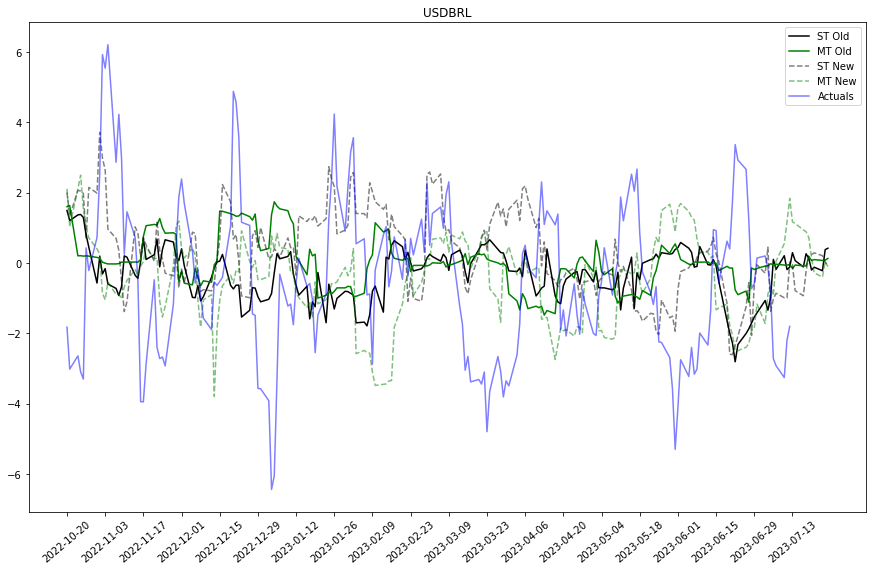

<Figure size 864x576 with 0 Axes>

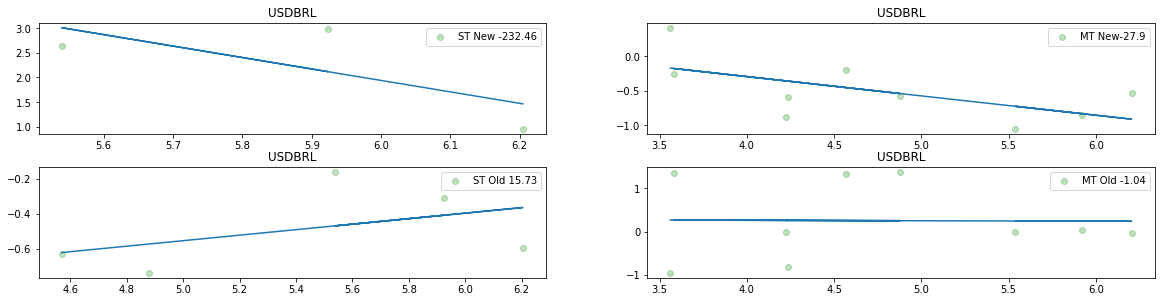

In [42]:
#RECENT PAIR VISUALIZATION

def on_selection(value):
    global choice_pair
    choice_pair = value  # store the user's choice
    root.destroy()  # close window
    
query_rv = 'SELECT * FROM best_fxrv_parameters_instant'
RV_o_df = pd.read_sql_query(query_rv, engine)
RV_o_df = Set_DF(RV_o_df)
RV_o_df = DD_Index(RV_o_df)

query_rv = 'SELECT * FROM best_fxrv_parameters_instant_new'
RV_n_df = pd.read_sql_query(query_rv, engine)
RV_n_df = Set_DF(RV_n_df)
RV_n_df = DD_Index(RV_n_df)

up_st_old = RV_o_df.loc['last', '1']
down_st_old = RV_o_df.loc['last', '2']
up_mt_old = RV_o_df.loc['last', '3']
down_mt_old = RV_o_df.loc['last', '4']

up_st_new = RV_n_df.loc['last', '1']
down_st_new = RV_n_df.loc['last', '2']
up_mt_new = RV_n_df.loc['last', '3']
down_mt_new = RV_n_df.loc['last', '4']
    
choice_list = FXPairs_List
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *choice_list, command = on_selection)
tk.Label(root, text = "Choose a pair").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

ret_series_o = (100 * (FX_Prices_df.shift(-LAG_returns) / FX_Prices_df - 1)).loc[LR_FX_Forecast_df.index][choice_pair]
ret_series_n = (100 * (FX_Prices_df.shift(-LAG_returns) / FX_Prices_df - 1)).loc[LR_FX_Forecast_N_df.index][choice_pair]

win = input('Enter window (empty for max): ')
if (win == ''):
    window = len(mix_cp_forecast_df.index)
else:
    window = int(win)
    
direction = input('(U)p or (D)own (empty = Up): ').upper()
cut = input('Enter actual threshold: ')
if (cut != ''):
    st_old = float(cut)
    mt_old = float(cut)
    st_new = float(cut)
    mt_new = float(cut)
else:
    if (direction != 'D'):
        st_old = up_st_old
        mt_old = up_mt_old
        st_new = up_st_new
        mt_new = up_mt_new
    else:
        st_old = down_st_old
        mt_old = down_mt_old
        st_new = down_st_new
        mt_new = down_mt_new

cp_o = int(mix_forecast_df[-window:].T[mix_forecast_df.columns.map(lambda x: x.find(choice_pair)) != -1].T.columns[0][-3:])
mp_o = int(mix_forecast_df[-window:].T[mix_forecast_df.columns.map(lambda x: x.find(choice_pair)) != -1].T.columns[1][-3:])
cp_n = int(mix_forecast_N_df[-window:].T[mix_forecast_N_df.columns.map(lambda x: x.find(choice_pair)) != -1].T.columns[0][-3:])
mp_n = int(mix_forecast_N_df[-window:].T[mix_forecast_N_df.columns.map(lambda x: x.find(choice_pair)) != -1].T.columns[1][-3:])

fig_1 = plt.figure(figsize = (15, 9))
fig2 = plt.figure(figsize = (12, 8))

ax0 = fig_1.add_subplot(1, 1, 1, title = choice_pair)
ax0.plot(mix_forecast_df[-window:][choice_pair + ' CORR ' + str(cp_o)], c = 'k', label = 'ST Old')
ax0.plot(mix_forecast_df[-window:][choice_pair + ' CORR ' + str(mp_o)], c = 'g', label = 'MT Old')
ax0.plot(mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(cp_n)], c = 'k', label = 'ST New', linestyle = 'dashed', alpha = 0.5)
ax0.plot(mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(mp_n)], c = 'g', label = 'MT New', linestyle = 'dashed', alpha = 0.5)
ax0.plot(ret_series_o[-window:], c = 'b', label = 'Actuals', alpha = 0.5)
ax0.legend(loc = 'best')
ax0.set_xticks(mix_cp_forecast_df[-window:].index[::int(round(window / 20, 0))])
ax0.set_xticklabels(mix_cp_forecast_df[-window:].index[::int(round(window / 20, 0))], rotation = 40)

x_labels_original = ret_series_o[-window:]
lin_reg_v = LinearRegression()

if (direction != 'D'):
    x_labels = x_labels_original[x_labels_original >= st_new]
else:
    x_labels = x_labels_original[x_labels_original <= st_new]

fig_1 = plt.figure(figsize = (20, 10))
y_labels = mix_cp_forecast_N_df[-window:][choice_pair + ' CORR ' + str(cp_n)].loc[x_labels.index]
st_n_model = lin_reg_v.fit(x_labels.dropna().values.reshape(-1, 1), y_labels.loc[x_labels.dropna().index].fillna(method = 'ffill').values)
st_n_lr = st_n_model.predict(x_labels.dropna().values.reshape(-1, 1))
st_n_lr_df = pd.DataFrame(st_n_lr, index = x_labels.dropna().values)
ax1 = fig_1.add_subplot(4, 2, 1, title = choice_pair)
ax1.scatter(x_labels, y_labels, c = 'g', label = 'ST New ' + str(round(100 * st_n_model.coef_[0], 2)), alpha = 0.25)
ax1.plot(st_n_lr_df[st_n_lr_df.columns[0]])
ax1.legend(loc = 'best')

if (direction != 'D'):
    x_labels = x_labels_original[x_labels_original >= mt_new]
else:
    x_labels = x_labels_original[x_labels_original <= mt_new]

y_labels = mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(mp_n)].loc[x_labels.index]
mt_n_model = lin_reg_v.fit(x_labels.dropna().values.reshape(-1, 1), y_labels.loc[x_labels.dropna().index].fillna(method = 'ffill').values)
mt_n_lr = mt_n_model.predict(x_labels.dropna().values.reshape(-1, 1))
mt_n_lr_df = pd.DataFrame(mt_n_lr, index = x_labels.dropna().values)
ax2 = fig_1.add_subplot(4, 2, 2, title = choice_pair)
ax2.scatter(x_labels, y_labels, c = 'g', label = 'MT New' + str(round(100 * mt_n_model.coef_[0], 2)), alpha = 0.25)
ax2.plot(mt_n_lr_df[mt_n_lr_df.columns[0]])
ax2.legend(loc = 'best')

if (direction != 'D'):
    x_labels = x_labels_original[x_labels_original >= st_old]
else:
    x_labels = x_labels_original[x_labels_original <= st_old]

y_labels = mix_forecast_df[-window:][choice_pair + ' CORR ' + str(cp_o)].loc[x_labels.index]
st_o_model = lin_reg_v.fit(x_labels.dropna().values.reshape(-1, 1), y_labels.loc[x_labels.dropna().index].fillna(method = 'ffill').values)
st_o_lr = mt_n_model.predict(x_labels.dropna().values.reshape(-1, 1))
st_o_lr_df = pd.DataFrame(st_o_lr, index = x_labels.dropna().values)
ax3 = fig_1.add_subplot(4, 2, 3, title = choice_pair)
ax3.scatter(x_labels, y_labels, c = 'g', label = 'ST Old ' + str(round(100 * st_o_model.coef_[0], 2)), alpha = 0.25)
ax3.plot(st_o_lr_df[st_o_lr_df.columns[0]])
ax3.legend(loc = 'best')

if (direction != 'D'):
    x_labels = x_labels_original[x_labels_original >= mt_old]
else:
    x_labels = x_labels_original[x_labels_original <= mt_old]

y_labels = mix_forecast_df[-window:][choice_pair + ' CORR ' + str(mp_o)].loc[x_labels.index]
mt_o_model = lin_reg_v.fit(x_labels.dropna().values.reshape(-1, 1), y_labels.loc[x_labels.dropna().index].fillna(method = 'ffill').values)
mt_o_lr = mt_o_model.predict(x_labels.dropna().values.reshape(-1, 1))
mt_o_lr_df = pd.DataFrame(mt_o_lr, index = x_labels.dropna().values)
ax4 = fig_1.add_subplot(4, 2, 4, title = choice_pair)
ax4.scatter(x_labels, y_labels, c = 'g', label = 'MT Old ' + str(round(100 * mt_o_model.coef_[0], 2)), alpha = 0.25)
ax4.plot(mt_o_lr_df[mt_o_lr_df.columns[0]])
ax4.legend(loc = 'best')



try:
    if (direction != 'D'):
        y_labels = mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(cp_n)][mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(cp_n)] >= st_new]
    else:
        y_labels = mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(cp_n)][mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(cp_n)] <= st_new]

    x_labels = x_labels_original.loc[y_labels.index]
    st_n_model = lin_reg_v.fit(x_labels.dropna().values.reshape(-1, 1), y_labels.loc[x_labels.dropna().index].fillna(method = 'ffill').values)
    st_n_lr = st_n_model.predict(x_labels.dropna().values.reshape(-1, 1))
    st_n_lr_df = pd.DataFrame(st_n_lr, index = x_labels.dropna().values)
    ax5 = fig_1.add_subplot(4, 2, 5, title = choice_pair + ' Forecast Filter ' + str(st_new))
    ax5.scatter(x_labels, y_labels, c = 'g', label = 'ST New ' + str(round(100 * st_n_model.coef_[0], 2)), alpha = 0.25)
    ax5.plot(st_n_lr_df[st_n_lr_df.columns[0]])
    ax5.legend(loc = 'best')
    
    h0 = fig2.add_subplot(2, 2, 1)
    h0.hist(x_labels, bins = 10)
    h0.set_title('ST NEW')
    print('')
    print('ST NEW median: ' + str(round(x_labels.median(), 2)))
    print('ST NEW mean: ' + str(round(x_labels.mean(), 2)))
    print('')
except:
    pass

try:
    if (direction != 'D'):
        y_labels = mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(mp_n)][mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(mp_n)] >= mt_new]
    else:
        y_labels = mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(mp_n)][mix_forecast_N_df[-window:][choice_pair + ' CORR ' + str(mp_n)] <= mt_new]

    x_labels = x_labels_original.loc[y_labels.index]
    mt_n_model = lin_reg_v.fit(x_labels.dropna().values.reshape(-1, 1), y_labels.loc[x_labels.dropna().index].fillna(method = 'ffill').values)
    mt_n_lr = mt_n_model.predict(x_labels.dropna().values.reshape(-1, 1))
    mt_n_lr_df = pd.DataFrame(mt_n_lr, index = x_labels.dropna().values)
    ax6 = fig_1.add_subplot(4, 2, 6, title = choice_pair + ' Forecast Filter Limit ' + str(mt_new))
    ax6.scatter(x_labels, y_labels, c = 'g', label = 'MT New' + str(round(100 * mt_n_model.coef_[0], 2)), alpha = 0.25)
    ax6.plot(mt_n_lr_df[mt_n_lr_df.columns[0]])
    ax6.legend(loc = 'best')
    
    h1 = fig2.add_subplot(2, 2, 2)
    h1.hist(x_labels, bins = 10)
    h1.set_title('MT NEW')
    print('')
    print('MT NEW median: ' + str(round(x_labels.median(), 2)))
    print('MT NEW mean: ' + str(round(x_labels.mean(), 2)))
    print('')    
except:
    pass

try:
    if (direction != 'D'):
        y_labels = mix_forecast_df[-window:][choice_pair + ' CORR ' + str(cp_o)][mix_forecast_df[-window:][choice_pair + ' CORR ' + str(cp_o)] >= st_old]
    else:
        y_labels = mix_forecast_df[-window:][choice_pair + ' CORR ' + str(cp_o)][mix_forecast_df[-window:][choice_pair + ' CORR ' + str(cp_o)] <= st_old]

    x_labels = x_labels_original.loc[y_labels.index]
    st_o_model = lin_reg_v.fit(x_labels.dropna().values.reshape(-1, 1), y_labels.loc[x_labels.dropna().index].fillna(method = 'ffill').values)
    st_o_lr = mt_n_model.predict(x_labels.dropna().values.reshape(-1, 1))
    st_o_lr_df = pd.DataFrame(st_o_lr, index = x_labels.dropna().values)
    ax7 = fig_1.add_subplot(4, 2, 7, title = choice_pair + ' Forecast Filter Limit ' + str(st_old))
    ax7.scatter(x_labels, y_labels, c = 'g', label = 'ST Old ' + str(round(100 * st_o_model.coef_[0], 2)), alpha = 0.25)
    ax7.plot(st_o_lr_df[st_o_lr_df.columns[0]])
    ax7.legend(loc = 'best')
    
    h2 = fig2.add_subplot(2, 2, 3)
    h2.hist(x_labels, bins = 10)
    h2.set_title('ST OLD')
    print('')
    print('ST OLD median: ' + str(round(x_labels.median(), 2)))
    print('ST OLD mean: ' + str(round(x_labels.mean(), 2)))
    print('')
except:
    pass

try:
    if (direction != 'D'):
        y_labels = mix_forecast_df[-window:][choice_pair + ' CORR ' + str(mp_o)][mix_forecast_df[-window:][choice_pair + ' CORR ' + str(mp_o)] >= mt_old]
    else:
        y_labels = mix_forecast_df[-window:][choice_pair + ' CORR ' + str(mp_o)][mix_forecast_df[-window:][choice_pair + ' CORR ' + str(mp_o)] <= mt_old]

    x_labels = x_labels_original.loc[y_labels.index]
    mt_o_model = lin_reg_v.fit(x_labels.dropna().values.reshape(-1, 1), y_labels.loc[x_labels.dropna().index].fillna(method = 'ffill').values)
    mt_o_lr = mt_o_model.predict(x_labels.dropna().values.reshape(-1, 1))
    mt_o_lr_df = pd.DataFrame(mt_o_lr, index = x_labels.dropna().values)
    ax8 = fig_1.add_subplot(4, 2, 8, title = choice_pair + ' Forecast Filter Limit ' + str(mt_old))
    ax8.scatter(x_labels, y_labels, c = 'g', label = 'MT Old ' + str(round(100 * mt_o_model.coef_[0], 2)), alpha = 0.25)
    ax8.plot(mt_o_lr_df[mt_o_lr_df.columns[0]])
    ax8.legend(loc = 'best')
    
    h3 = fig2.add_subplot(2, 2, 4)
    h3.hist(x_labels, bins = 10)
    h3.set_title('MT OLD')
    print('')
    print('MT OLD median: ' + str(round(x_labels.median(), 2)))
    print('MT OLD mean: ' + str(round(x_labels.mean(), 2)))
    print('')
except:
    pass

plt.subplots_adjust(hspace = 0.3)
AllMixed_df = mix_forecast_df[-15:].T[mix_forecast_df.columns.map(lambda x: x.find(choice_pair)) != -1].T.join(mix_forecast_N_df[-60:].T[mix_forecast_N_df.columns.map(lambda x: x.find(choice_pair)) != -1].T, rsuffix = '_NEW')
AllMixed_df

Enter Start Date: (YY/MM/DD)05/01/01
Log Scale? (Y/N)
Poly Order (6): 12
no models available


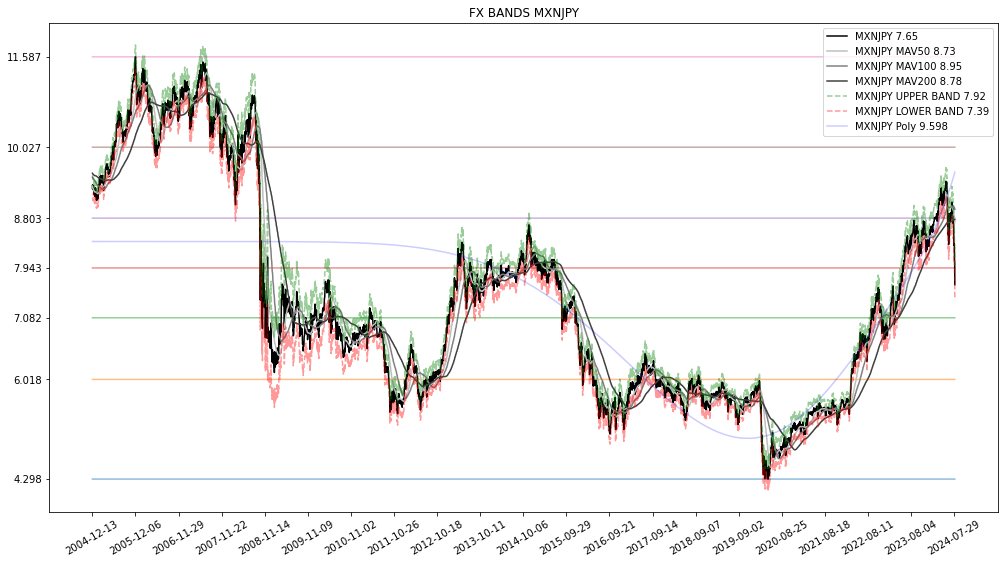

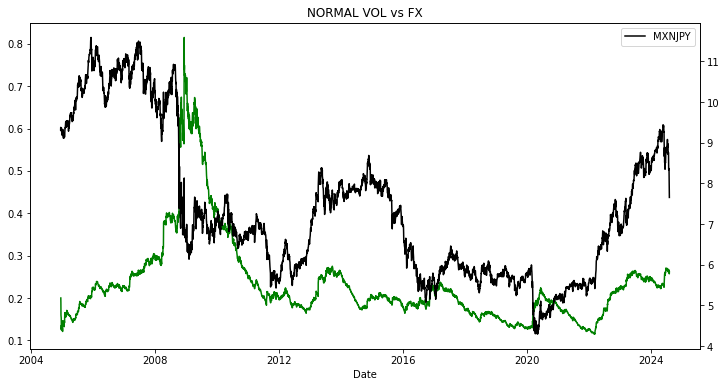

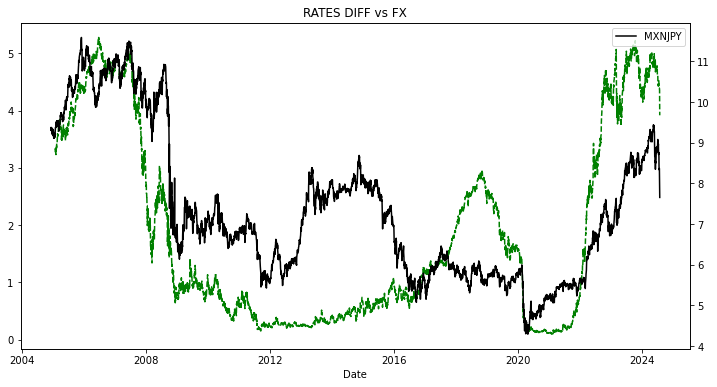

In [28]:
#FX Bands, Relations & Forecasts (Normal Vol & Rates Diff)

import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
#import mysql.connector
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
import warnings
import joblib
from datetime import datetime
from datetime import timedelta
from datetime import date
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def Average(lst):
    return sum(lst) / len(lst)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df


def on_selection(value):
    global choice
    choice = value
    root.destroy()
    
dbase = "visiblealpha_laptop"

conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list=[]
len_tl=len(tables_list)
cont_tl=0
while (cont_tl<len_tl):
    new_tables_list.append(re.sub(r'[^a-z_^0-9]', '', str(tables_list[cont_tl])))
    cont_tl=cont_tl+1

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))
    
today = date.today()    
    
query_prices = 'SELECT * FROM prices_relation'    
Prices_df = pd.read_sql_query(query_prices, engine)
Prices_df = Set_DF(Prices_df)
Prices_df = DD_Index(Prices_df)
Prices_df.sort_index(inplace = True)

query_DMRates = 'SELECT * FROM global_rates_dm'    
DM_Rates_df = pd.read_sql_query(query_DMRates, engine)
DM_Rates_df = Set_DF(DM_Rates_df)
DM_Rates_df = DD_Index(DM_Rates_df)

query_fxprices = 'SELECT * FROM fxprices_relation'    
FX_Prices_df = pd.read_sql_query(query_fxprices, engine)
FX_Prices_df = Set_DF(FX_Prices_df)
FX_Prices_df = DD_Index(FX_Prices_df)

us2y_series = DM_Rates_df.T[DM_Rates_df.columns.map(lambda x: x.find('US GOVT 2Y')) != -1].T['US GOVT 2Y']
FX_Pairs_List = FX_Prices_df.columns.values.tolist()
    
FX_Prices_df = pd.DataFrame(np.nan, index = Prices_df.index, columns = FX_Pairs_List)
for pair in FX_Pairs_List:
    aux_pair01 = ''
    aux_pair02 = ''
    query_pair = ''
    usd_pair = False
    inv = False
    if (pair[:3] != 'USD'):
        aux_pair01 = 'USD' + pair[:3]
    else:
        usd_pair = True
        query_pair = pair
    if (pair[3:6] != 'USD'):
        aux_pair02 = 'USD' + pair[3:6]
    else:
        usd_pair = True
        inv = True
        query_pair = pair[3:6] + pair[:3]
    if (usd_pair):
        if (inv):
            FX_Prices_df[pair] = (1 / Prices_df[query_pair])
        else:
            FX_Prices_df[pair] = Prices_df[query_pair]
    else:
        FX_Prices_df[pair] = Prices_df[aux_pair02] / Prices_df[aux_pair01]
    
FX_List = FX_Prices_df.columns.values.tolist()  
choice_list = FX_List.copy()
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *choice_list, command = on_selection)
tk.Label(root, text = "Choose a pair").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

lag_returns = 10
init = 500
fibonacci_seq = [0.00, 23.60, 38.20, 50.00, 61.80, 78.60, 100.00]
fibonacci_list = []
Start_Date = input("Enter Start Date: (YY/MM/DD)")
Start_Date = datetime.strptime(Start_Date, "%y/%m/%d").date()
#Start_Date = datetime.strptime('21-01-01', '%y-%m-%d').date()

pair = choice
Current_Pxs_df = FX_Prices_df[FX_Prices_df.index >= (Start_Date - timedelta(2 * lag_returns))]
mav50 = FX_Prices_df[pair].rolling(50).mean()
mav100 = FX_Prices_df[pair].rolling(100).mean()
mav200 = FX_Prices_df[pair].rolling(200).mean()
mav50_series = mav50[mav50.index >= (Start_Date - timedelta(2 * lag_returns))]
mav100_series = mav100[mav100.index >= (Start_Date - timedelta(2 * lag_returns))]
mav200_series = mav200[mav200.index >= (Start_Date - timedelta(2 * lag_returns))]
FX_daily_returns_df = Current_Pxs_df.pct_change()
FX_window_std_df = round(100 * FX_daily_returns_df.ewm(halflife = 100).std() * np.sqrt(lag_returns), 2)
Upperband_df = Current_Pxs_df * (1 + FX_window_std_df / 100)
Lowerband_df = Current_Pxs_df * (1 - FX_window_std_df / 100)
last_px = round(Current_Pxs_df[pair].iloc[-1], 2)
last_up = round(Upperband_df[pair].iloc[-1], 2)
last_down = round(Lowerband_df[pair].iloc[-1], 2)
last_50 = round(mav50_series.iloc[-1], 2)
last_100 = round(mav100_series.iloc[-1], 2)
last_200 = round(mav200_series.iloc[-1], 2)

fig1 = plt.figure(0, figsize = (17, 9))
ax1 = fig1.add_subplot(1, 1, 1)

local_max = Current_Pxs_df[pair].max()
local_min = Current_Pxs_df[pair].min()
hl_gap = (local_max - local_min)
for f_level in fibonacci_seq:
    f_array = local_min + np.ones(len(Current_Pxs_df.index)) * (f_level / 100) * hl_gap
    f_series = pd.Series(f_array, index = Current_Pxs_df.index)
    fibonacci_list.append(round(f_series.iloc[0], 3))
    ax1.plot(f_series, alpha = 0.5)

len_f = len(Current_Pxs_df.index)
ax1.set_xticks(Current_Pxs_df.index[::int(round(len_f / 20, 0))])        
ax1.set_xticklabels(Current_Pxs_df.index[::int(round(len_f / 20, 0))], rotation = 30)
  
log = input('Log Scale? (Y/N)').upper()
if (log == 'Y'):
    ax1.set_yscale('log')

ax1.plot(Current_Pxs_df[pair], c = 'k', label = pair + ' ' + str(last_px))
ax1.plot(mav50_series, c = '0.75', label = pair + ' MAV50 ' + str(last_50))
ax1.plot(mav100_series, c = '0.50', label = pair + ' MAV100 ' + str(last_100))
ax1.plot(mav200_series, c = '0.25', label = pair + ' MAV200 ' + str(last_200))
ax1.plot(Upperband_df[pair], c = 'g', label = pair + ' UPPER BAND ' + str(last_up), alpha = 0.4, linestyle = 'dashed')
ax1.plot(Lowerband_df[pair], c = 'r', label = pair + ' LOWER BAND ' + str(last_down), alpha = 0.4, linestyle = 'dashed')

#pace = max(1, Current_Pxs_df.index[-1].year - Current_Pxs_df.index[0].year)
pair_df = pd.DataFrame(Current_Pxs_df[pair].values, index = np.arange(len(Current_Pxs_df.index)), columns = [pair])
p_degree = int(input('Poly Order (6): '))
first_deriv = 1
second_deriv = 2
lin_reg = LinearRegression()
x_Values = pair_df.index.values.reshape(-1, 1)
y_Values = np.array(pair_df)
poly_features = PolynomialFeatures(degree = p_degree, include_bias = False)
poly_X = poly_features.fit_transform(x_Values)
LR_Fit = lin_reg.fit(poly_X, y_Values)
Predictions_df = pd.DataFrame(LR_Fit.predict(poly_X), index = pair_df.index, columns = ['Forecast'])
PredictionsPlot_df = pd.DataFrame(LR_Fit.predict(poly_X), index = Current_Pxs_df.index, columns = ['Forecast'])

poly_features_1d = PolynomialFeatures(degree = (p_degree - first_deriv), include_bias = False)
poly_dX = poly_features_1d.fit_transform(x_Values)
n, m = poly_dX.shape
x0 = np.ones((n, 1))
poly_dX_base = np.c_[x0, poly_dX]
poly_deriv = np.array(list(np.poly1d(np.array(list(LR_Fit.coef_[0][::-1]) + [1])).deriv())[::-1])

poly_features_2d = PolynomialFeatures(degree = (p_degree - second_deriv), include_bias = False)
poly_2dX = poly_features_2d.fit_transform(x_Values)
n2, m2 = poly_2dX.shape
x0_2 = np.ones((n2, 1))
poly_2dX_base = np.c_[x0_2, poly_2dX]
poly_2deriv = np.array(list(np.poly1d(np.array(list(poly_deriv)[::-1])).deriv())[::-1])

deriv01_df = pd.DataFrame(poly_dX_base.dot(poly_deriv), columns = ['Deriv 01'])
deriv02_df = pd.DataFrame(poly_2dX_base.dot(poly_2deriv), columns = ['Deriv 02'])

d01_df = deriv01_df.copy()
d01_df['Abs'] = abs(d01_df['Deriv 01'])
d01_df['Original Index'] = d01_df.index

prev = 0
Deriv0_pts_df = pd.DataFrame(np.nan, index = [0], columns = ['Local'])
for idx in d01_df.index[1:]:
    if (d01_df.iloc[idx]['Deriv 01'] > 0) & (d01_df.iloc[prev]['Deriv 01'] < 0):
        Deriv0_pts_df.loc[idx] = 'Min'
    if (d01_df.iloc[idx]['Deriv 01'] < 0) & (d01_df.iloc[prev]['Deriv 01'] > 0):
        Deriv0_pts_df.loc[idx] = 'Max'
    prev = idx
Deriv0_pts_df.drop([0], inplace = True)

p = Deriv0_pts_df.index[0]
lows_list = []
highs_list = []
sign = 1
if (Deriv0_pts_df.loc[p][0] == 'Max'):
    sign = -1
    lows_list.append((pair_df.loc[:p][pair] * sign).max() * sign)
else:
    highs_list.append((pair_df.loc[:p][pair] * sign).max() * sign)
p = 0
for i in Deriv0_pts_df.index[:-1]:
    n = Deriv0_pts_df.index[Deriv0_pts_df.index.values.tolist().index(i) + 1]
    sign = 1
    if (Deriv0_pts_df.loc[i][0] == 'Min'):
        sign = -1
        lows_list.append((pair_df.loc[p: n][pair] * sign).max() * sign)
    else:
        highs_list.append((pair_df.loc[p: n][pair] * sign).max() * sign)
    p = i  
sign = 1
if (len(Deriv0_pts_df.index) > 1):
    p = Deriv0_pts_df.index[-2]
    if (Deriv0_pts_df.iloc[-1][-1] == 'Max'):
        highs_list.append((pair_df.loc[p:][pair] * sign).max() * sign)
    else:
        sign = -1
        lows_list.append((pair_df.loc[p:][pair] * sign).max() * sign)

lows_df = pd.DataFrame(lows_list, index = np.arange(len(lows_list)), columns = ['Levels'])
highs_df = pd.DataFrame(highs_list, index = np.arange(len(highs_list)), columns = ['Levels'])
lows_df['Positions'] = np.nan
highs_df['Positions'] = np.nan
for idx in lows_df.index:
    lows_df.loc[idx, 'Positions'] = pair_df[pair_df[pair] == lows_list[idx]].index[0]
for idx in highs_df.index:
    highs_df.loc[idx, 'Positions'] = pair_df[pair_df[pair] == highs_list[idx]].index[0]    
    
if (len(lows_df.index) > 1):  
    base_x = lows_df.loc[0, 'Positions']
    base_y = lows_df.loc[0, 'Levels']
    for i, curr in enumerate(lows_df.index[1:]):
        lx_values = np.array([base_x, lows_df.loc[curr, 'Positions']]).reshape(-1, 1)
        ly_values = np.array([base_y, lows_df.loc[curr, 'Levels']])
        Low_Fit = lin_reg.fit(lx_values, ly_values)
        lx_values = np.array([Predictions_df.index[0], base_x, lows_df.loc[curr, 'Positions'], Predictions_df.index[-1]]).reshape(-1, 1)
        Low_df = pd.DataFrame(Low_Fit.predict(lx_values), index = [Predictions_df.index[0], base_x, lows_df.loc[curr, 'Positions'], Predictions_df.index[-1]], columns = ['Low'])
        Low_df.index = Low_df.T.columns.map(lambda x: Current_Pxs_df.index[int(x)]).T
        ax1.plot(Low_df, c = 'g', alpha = 0.35, label = 'Support ' + str(round(Low_df.iloc[-1][0], 3)))

if (len(highs_df.index) > 1):  
    base_x = highs_df.loc[0, 'Positions']
    base_y = highs_df.loc[0, 'Levels']
    for i, curr in enumerate(highs_df.index[1:]):
        lx_values = np.array([base_x, highs_df.loc[curr, 'Positions']]).reshape(-1, 1)
        ly_values = np.array([base_y, highs_df.loc[curr, 'Levels']])
        High_Fit = lin_reg.fit(lx_values, ly_values)
        lx_values = np.array([Predictions_df.index[0], base_x, highs_df.loc[curr, 'Positions'], Predictions_df.index[-1]]).reshape(-1, 1)
        High_df = pd.DataFrame(High_Fit.predict(lx_values), index = [Predictions_df.index[0], base_x, highs_df.loc[curr, 'Positions'], Predictions_df.index[-1]], columns = ['High'])
        High_df.index = High_df.T.columns.map(lambda x: Current_Pxs_df.index[int(x)]).T
        ax1.plot(High_df, c = 'r', alpha = 0.35, label = 'Resistance ' + str(round(High_df.iloc[-1][0], 3)))


ax1.plot(PredictionsPlot_df, c = 'b', alpha = 0.2, label = pair + ' Poly ' + str(round(PredictionsPlot_df['Forecast'][-1], 3)))
ax1.legend(loc = 'best')
ax1.set_title('FX BANDS ' + pair)
ax1.set_yticks(fibonacci_list)
ax1.set_yticklabels(fibonacci_list)

plt.figure(1)
(Upperband_df[pair] - Current_Pxs_df[pair]).dropna().plot(c = 'g').twinx()
Current_Pxs_df[pair].plot(figsize = (12, 6), c = 'k', label = pair).legend(loc = 'best')
plt.title('NORMAL VOL vs FX')

plt.figure(2)
us2y_series[us2y_series.index >= Current_Pxs_df.index[0]].plot(figsize = (12, 8), c = 'g', linestyle = 'dashed').twinx()
Current_Pxs_df[pair].plot(figsize = (12, 6), c = 'k', label = pair).legend(loc = 'best')
plt.title('RATES DIFF vs FX')

try:
    forecast_list = EN_FX_Forecast_df.T[EN_FX_Forecast_df.columns.map(lambda x: x.find(pair)) != -1].T.columns.values.tolist()
    c = 3
    for idx, cur in enumerate(forecast_list):
        plt.figure(c, figsize = (13, 5))
        FX_Prices_df[pair].loc[EN_FX_Forecast_df.index].plot(c = 'k').twinx()
        EN_FX_Forecast_df[cur].plot(alpha = 0.5)
        LR_FX_Forecast_df[cur].clip(-2, 2).plot(alpha = 0.5, label = pair).legend(loc = 'best')
        RF_FX_Forecast_df[cur].clip(-2, 2).plot(alpha = 0.5)
        ttl = round(EN_FX_Forecast_df.iloc[-1][cur] + LR_FX_Forecast_df.iloc[-1][cur] + RF_FX_Forecast_df.iloc[-1][cur], 2)
        if (idx == 0):
            print(pair + ' ST TTL FORECAST: ' + str(ttl))
        else:
            print(pair + ' MT TTL FORECAST: ' + str(ttl))
        c = c + 1
except:
    print('no models available')

Enter Days: 225
Enter polynomial order (empty for 10): 15


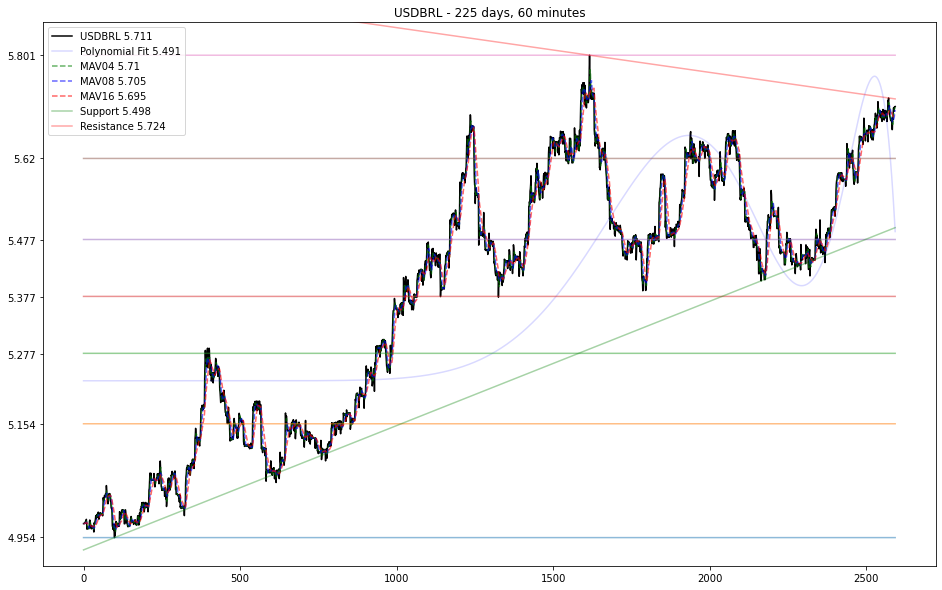

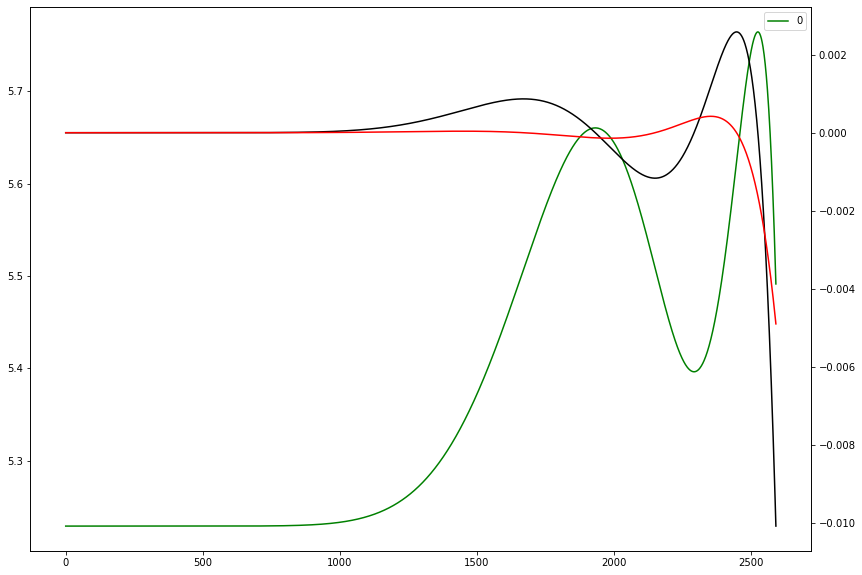

In [22]:
#INTRADAY FX GRAPHS

import pandas as pd
import os
import csv
import re
import psycopg2
import yfinance as yf
import tkinter as tk
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from datetime import date
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def Average(lst):
    return sum(lst) / len(lst)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df

def on_selection(value):
    global choice_lag
    choice_lag = value  # store the user's choice
    root.destroy()  # close window
    
def on_selection_pair(value):
    global choice_pair
    choice_pair = value  # store the user's choice
    root.destroy()  # close window
    
dbase = "visiblealpha_laptop"

conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list=[]
len_tl=len(tables_list)
cont_tl=0
while (cont_tl<len_tl):
    new_tables_list.append(re.sub(r'[^a-z_^0-9]', '', str(tables_list[cont_tl])))
    cont_tl=cont_tl+1

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))
    
today = date.today()
fibonacci_seq = [0.00, 23.60, 38.20, 50.00, 61.80, 78.60, 100.00]
fibonacci_list = []
fig1 = plt.figure(figsize = (16, 10))
ax1 = fig1.add_subplot(1, 1, 1)

query_fxprices = 'SELECT * FROM fxprices_relation'    
FX_Prices_df = pd.read_sql_query(query_fxprices, engine)
FX_Prices_df = Set_DF(FX_Prices_df)
FX_Prices_df = DD_Index(FX_Prices_df)

FXPairs_List = FX_Prices_df.columns.values.tolist()

pairs_list = FXPairs_List
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *pairs_list, command = on_selection_pair)
tk.Label(root, text = "Choose a pair").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

day_lag = int(input('Enter Days: '))  
start_date = today - timedelta(day_lag)

choice_list = ['5', '15', '30', '45', '60']
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *choice_list, command = on_selection)
tk.Label(root, text = "Choose a lag (minutes)").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()

ext = '=X'
ccy1 = choice_pair[:3]
ccy2 = choice_pair[3:]

if (ccy1 != 'USD'):
    usdpair1 = yf.Ticker(ccy1 + ext)
    usdpair_historical1 = usdpair1.history(start = start_date - timedelta(days = 1), end = today + timedelta(days = 1), interval = choice_lag + "m")
    usdpair1_df = pd.DataFrame(usdpair_historical1['Close'].values, index = np.arange(len(usdpair_historical1.index)), columns = [ccy1])
if (ccy2 != 'USD'):
    usdpair2 = yf.Ticker(ccy2 + ext)
    usdpair_historical2 = usdpair2.history(start = start_date - timedelta(days = 1), end = today + timedelta(days = 1), interval = choice_lag + "m")
    usdpair2_df = pd.DataFrame(usdpair_historical2['Close'].values, index = np.arange(len(usdpair_historical2.index)), columns = [ccy2])
if (ccy1 == 'USD'):
    usdpair1_df = pd.DataFrame(1, index = np.arange(len(usdpair_historical2.index)), columns = [ccy1])
if (ccy2 == 'USD'):
    usdpair2_df = pd.DataFrame(1, index = np.arange(len(usdpair_historical1.index)), columns = [ccy2])

try:
    pair_df = pd.DataFrame(np.array(usdpair2_df) / np.array(usdpair1_df.loc[usdpair2_df.index]), index = np.arange(len(usdpair2_df.index)), columns = [choice_pair])
except:
    pair_df = pd.DataFrame(np.array(usdpair2_df.loc[usdpair1_df.index]) / np.array(usdpair1_df), index = np.arange(len(usdpair1_df.index)), columns = [choice_pair])

p_degree = 10
MOD_ORDER = input('Enter polynomial order (empty for 10): ')
try:
    p_degree = int(MOD_ORDER)
except:
    pass

first_deriv = 1
second_deriv = 2
lin_reg = LinearRegression()
x_Values = pair_df.index.values.reshape(-1, 1)
y_Values = np.array(pair_df)
poly_features = PolynomialFeatures(degree = p_degree, include_bias = False)
poly_X = poly_features.fit_transform(x_Values)
LR_Fit = lin_reg.fit(poly_X, y_Values)
Predictions_df = pd.DataFrame(LR_Fit.predict(poly_X), index = pair_df.index, columns = ['Forecast'])

mav04 = pair_df.rolling(4, min_periods = 1).mean()
mav08 = pair_df.rolling(8, min_periods = 1).mean()
mav16 = pair_df.rolling(16, min_periods = 1).mean()

ax1.plot(pair_df, c = 'k', label = choice_pair + ' ' + str(round(pair_df.iloc[-1][choice_pair], 3)))
ax1.plot(Predictions_df, c = 'b', alpha = 0.15, label = 'Polynomial Fit ' + str(round(Predictions_df.iloc[-1][0], 3)))
ax1.plot(mav04, c = 'g', alpha = 0.6, linestyle = 'dashed', label = 'MAV04' + ' ' + str(round(mav04.iloc[-1][choice_pair], 3)))
ax1.plot(mav08, c = 'b', alpha = 0.6, linestyle = 'dashed', label = 'MAV08' + ' ' + str(round(mav08.iloc[-1][choice_pair], 3)))
ax1.plot(mav16, c = 'r', alpha = 0.6, linestyle = 'dashed', label = 'MAV16' + ' ' + str(round(mav16.iloc[-1][choice_pair], 3)))

local_max = pair_df[choice_pair].max()
local_min = pair_df[choice_pair].min()
hl_gap = (local_max - local_min)
for f_level in fibonacci_seq:
    f_array = local_min + np.ones(len(pair_df.index)) * (f_level / 100) * hl_gap
    f_series = pd.Series(f_array, index = pair_df.index)
    fibonacci_list.append(round(f_series.iloc[0], 3))
    ax1.plot(f_series, alpha = 0.5)  
    
    
poly_features_1d = PolynomialFeatures(degree = (p_degree - first_deriv), include_bias = False)
poly_dX = poly_features_1d.fit_transform(x_Values)
n, m = poly_dX.shape
x0 = np.ones((n, 1))
poly_dX_base = np.c_[x0, poly_dX]
poly_deriv = np.array(list(np.poly1d(np.array(list(LR_Fit.coef_[0][::-1]) + [1])).deriv())[::-1])

poly_features_2d = PolynomialFeatures(degree = (p_degree - second_deriv), include_bias = False)
poly_2dX = poly_features_2d.fit_transform(x_Values)
n2, m2 = poly_2dX.shape
x0_2 = np.ones((n2, 1))
poly_2dX_base = np.c_[x0_2, poly_2dX]
poly_2deriv = np.array(list(np.poly1d(np.array(list(poly_deriv)[::-1])).deriv())[::-1])


pd.DataFrame(poly_X.dot(LR_Fit.coef_[0]) + LR_Fit.intercept_).plot(figsize = (14, 10), c = 'g').twinx()
plt.plot(poly_dX_base.dot(poly_deriv), c = 'k')
plt.plot(20 * poly_2dX_base.dot(poly_2deriv), c = 'r')


deriv01_df = pd.DataFrame(poly_dX_base.dot(poly_deriv), columns = ['Deriv 01'])
deriv02_df = pd.DataFrame(poly_2dX_base.dot(poly_2deriv), columns = ['Deriv 02'])

d01_df = deriv01_df.copy()
d01_df['Abs'] = abs(d01_df['Deriv 01'])
d01_df['Original Index'] = d01_df.index

prev = 0
Deriv0_pts_df = pd.DataFrame(np.nan, index = [0], columns = ['Local'])
for idx in d01_df.index[1:]:
    if (d01_df.iloc[idx]['Deriv 01'] > 0) & (d01_df.iloc[prev]['Deriv 01'] < 0):
        Deriv0_pts_df.loc[idx] = 'Min'
    if (d01_df.iloc[idx]['Deriv 01'] < 0) & (d01_df.iloc[prev]['Deriv 01'] > 0):
        Deriv0_pts_df.loc[idx] = 'Max'
    prev = idx
Deriv0_pts_df.drop([0], inplace = True)

p = Deriv0_pts_df.index[0]
lows_list = []
highs_list = []
sign = 1
if (Deriv0_pts_df.loc[p][0] == 'Max'):
    sign = -1
    lows_list.append((pair_df.loc[:p][choice_pair] * sign).max() * sign)
else:
    highs_list.append((pair_df.loc[:p][choice_pair] * sign).max() * sign)
p = 0
for i in Deriv0_pts_df.index[:-1]:
    n = Deriv0_pts_df.index[Deriv0_pts_df.index.values.tolist().index(i) + 1]
    sign = 1
    if (Deriv0_pts_df.loc[i][0] == 'Min'):
        sign = -1
        lows_list.append((pair_df.loc[p: n][choice_pair] * sign).max() * sign)
    else:
        highs_list.append((pair_df.loc[p: n][choice_pair] * sign).max() * sign)
    p = i  
sign = 1
if (len(Deriv0_pts_df.index) > 1):
    p = Deriv0_pts_df.index[-2]
    if (Deriv0_pts_df.iloc[-1][-1] == 'Max'):
        highs_list.append((pair_df.loc[p:][choice_pair] * sign).max() * sign)
    else:
        sign = -1
        lows_list.append((pair_df.loc[p:][choice_pair] * sign).max() * sign)
lows_df = pd.DataFrame(lows_list, index = np.arange(len(lows_list)), columns = ['Levels'])
highs_df = pd.DataFrame(highs_list, index = np.arange(len(highs_list)), columns = ['Levels'])
lows_df['Positions'] = np.nan
highs_df['Positions'] = np.nan
for idx in lows_df.index:
    lows_df.loc[idx, 'Positions'] = pair_df[pair_df[choice_pair] == lows_list[idx]].index[0]
for idx in highs_df.index:
    highs_df.loc[idx, 'Positions'] = pair_df[pair_df[choice_pair] == highs_list[idx]].index[0]    
    
if (len(lows_df.index) > 1):  
    base_x = lows_df.loc[0, 'Positions']
    base_y = lows_df.loc[0, 'Levels']
    for i, curr in enumerate(lows_df.index[1:]):
        lx_values = np.array([base_x, lows_df.loc[curr, 'Positions']]).reshape(-1, 1)
        ly_values = np.array([base_y, lows_df.loc[curr, 'Levels']])
        Low_Fit = lin_reg.fit(lx_values, ly_values)
        lx_values = np.array([Predictions_df.index[0], base_x, lows_df.loc[curr, 'Positions'], Predictions_df.index[-1]]).reshape(-1, 1)
        Low_df = pd.DataFrame(Low_Fit.predict(lx_values), index = [Predictions_df.index[0], base_x, lows_df.loc[curr, 'Positions'], Predictions_df.index[-1]], columns = ['Low'])
        ax1.plot(Low_df, c = 'g', alpha = 0.35, label = 'Support ' + str(round(Low_df.iloc[-1][0], 3)))

if (len(highs_df.index) > 1):  
    base_x = highs_df.loc[0, 'Positions']
    base_y = highs_df.loc[0, 'Levels']
    for i, curr in enumerate(highs_df.index[1:]):
        lx_values = np.array([base_x, highs_df.loc[curr, 'Positions']]).reshape(-1, 1)
        ly_values = np.array([base_y, highs_df.loc[curr, 'Levels']])
        High_Fit = lin_reg.fit(lx_values, ly_values)
        lx_values = np.array([Predictions_df.index[0], base_x, highs_df.loc[curr, 'Positions'], Predictions_df.index[-1]]).reshape(-1, 1)
        High_df = pd.DataFrame(High_Fit.predict(lx_values), index = [Predictions_df.index[0], base_x, highs_df.loc[curr, 'Positions'], Predictions_df.index[-1]], columns = ['High'])
        ax1.plot(High_df, c = 'r', alpha = 0.35, label = 'Resistance ' + str(round(High_df.iloc[-1][0], 3)))
    

ax1.set_yticks(fibonacci_list)
ax1.set_yticklabels(fibonacci_list)
ax1.set_ylim([local_min * 0.99, local_max * 1.01])
ax1.set_title(choice_pair + ' - ' + str(day_lag) + ' days, ' + str(choice_lag) + ' minutes')
ax1.legend(loc = 'best')
plt.show()

Years: 15
Choose asset (Y/N): y

Seasonality EURUSD:
Date     Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
Date                                                                          
2009                                                          0.55  2.08 -4.74
2010    -3.2  -1.7 -0.91 -1.56 -7.59 -0.48  6.62 -2.86  7.59   1.1 -4.89   1.5
2011    2.04  1.19  2.81  5.12 -3.51  1.09  -1.0  0.71 -5.88  4.09 -5.77 -2.76
2012    1.41  2.59 -1.22 -0.54 -6.55  0.53 -1.46  2.05  3.22  0.39  0.08  1.96
2013    2.58 -3.08 -2.55  2.19 -0.39 -0.07  1.75 -0.21  1.96   1.7 -0.88  1.52
2014   -1.82   1.1  0.32  0.46 -1.52   0.3 -1.82 -1.57 -3.76 -0.61  -1.2 -2.41
2015    -6.8 -1.14 -3.35  2.62 -1.39   2.4 -2.53  2.51  0.37 -2.33 -3.74  3.31
2016    0.03 -0.12  3.75  0.19 -1.83 -0.18  -0.4  0.62  0.59  -2.1 -3.06 -0.69
2017    1.26 -1.16  0.97  1.66  2.83  2.41  2.67  1.25 -0.94  -1.1  1.72  0.75
2018    3.92 -1.44  0.59 -1.47 -3.76 -0.89  1.24 -0.36 -0.23  -2.5  0.41  0.41

,EURUSD,EURGBP,EURJPY,EURAUD,EURCAD,EURMXN,EURBRL,GBPUSD,GBPJPY,GBPAUD,...,USDJPY,USDCAD,USDMXN,USDBRL,CADJPY,CADMXN,CADBRL,BRLMXN,BRLJPY,MXNJPY
Date,,,,,,,,,,,,,,,,,,,,,
2009-09-14,22.14,20.72,39.69,24.19,20.69,23.62,32.91,14.38,28.02,16.82,...,22.56,14.43,19.12,26.45,28.87,17.06,24.11,28.47,35.07,33.78
2009-09-15,22.06,20.68,39.55,24.11,20.64,23.54,32.80,14.36,27.94,16.80,...,22.49,14.43,19.06,26.37,28.79,17.01,24.03,28.37,34.96,33.67
2009-09-16,21.99,20.61,39.42,24.05,20.57,23.47,32.69,14.31,27.84,16.80,...,22.41,14.39,19.03,26.28,28.71,16.96,23.95,28.28,34.84,33.58
2009-09-17,21.91,20.54,39.28,23.97,20.50,23.41,32.59,14.27,27.75,16.74,...,22.33,14.34,18.98,26.21,28.61,16.92,23.89,28.18,34.73,33.47
2009-09-18,21.84,20.51,39.15,23.89,20.44,23.34,32.48,14.28,27.68,16.70,...,22.26,14.32,18.92,26.12,28.52,16.90,23.82,28.09,34.61,33.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-09,5.89,4.18,9.73,6.51,5.10,14.27,11.95,6.57,10.54,6.18,...,10.52,4.85,13.98,12.04,10.64,13.28,11.37,13.35,16.08,18.53
2024-09-10,5.87,4.17,9.71,6.49,5.08,14.26,11.99,6.55,10.51,6.16,...,10.49,4.85,13.99,12.11,10.63,13.27,11.41,13.31,16.17,18.54
2024-09-11,5.85,4.17,9.68,6.48,5.08,14.37,11.95,6.54,10.49,6.18,...,10.45,4.84,14.09,12.07,10.60,13.34,11.37,13.40,16.11,18.59


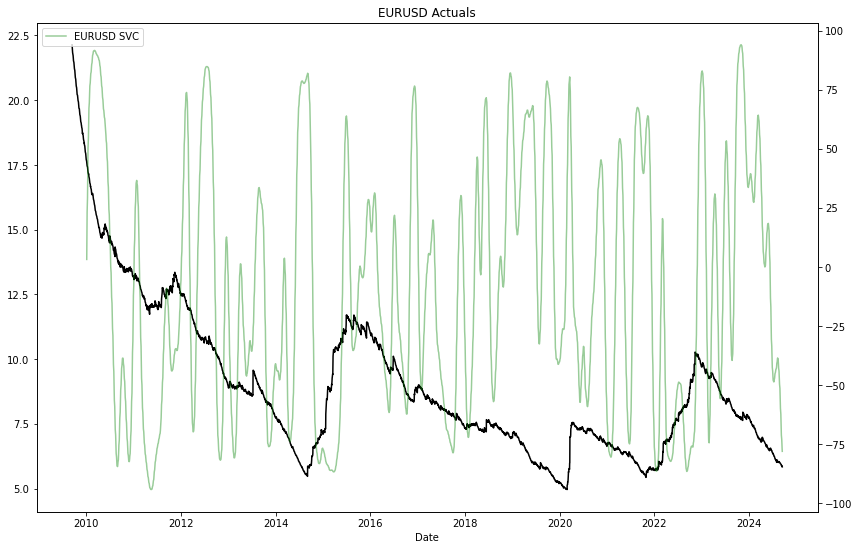

In [5]:
#%%writefile C:\Users\Utilizador\OneDrive\Documentos\Malta\Systematic\seasonals.py

#SEASONALS & VOLS

import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
#import mysql.connector
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
from datetime import datetime
from datetime import timedelta
from datetime import date
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression

def Average(lst):
    return sum(lst) / len(lst)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df

def round_down(n, decimals = 0): 
    multiplier = 10 ** decimals 
    return int(math.floor(n * multiplier) / multiplier)

def Filter_df(tbf_df, merging_dates_list):
    
    filter_df = pd.DataFrame(merging_dates_list, columns=['Date'])
    merged_df = pd.merge(tbf_df, filter_df, on='Date')
    merged_df.index = filter_df['Date'] 
    merged_df.index.name = 'Date'
    merged_df.drop(['Date'], axis=1, inplace=True)
    
    
    return merged_df

def offset(c_stock, i_list, d_list, t_date, r_date, div_i):
    
    cutoff_date = r_date
    Start_Date = t_date
    ed_list = d_list
    y_list = i_list
    cur_index = 0
    nd_list = []
    for cur_ed_date in ed_list:                            
        cont=0
        seek_element = True
        ced = cur_ed_date
        cur_index = ed_df[c_stock].values.tolist()[cur_index:].index(cur_ed_date) + cur_index
        cur_index_plus = cur_index + 1
        if (cur_index_plus<len(ed_df.index)):
            cur_year = ed_df.index[cur_index_plus][len(ed_df.index[cur_index_plus])-4:]
        else:
            cur_year = today.year
        cur_ed_date = str(cur_year) + '-' + cur_ed_date[0:2] + '-' + cur_ed_date[2:]
        cur_ed_date = datetime.strptime(cur_ed_date, "%Y-%m-%d").date()
        if (cur_ed_date < cutoff_date):
            nd_list.append(cur_ed_date)        
    
    offs = round_down(len(pd.Series(nd_list)[pd.Series(nd_list) > t_date]) / div_i, 0)
    
    return offs

def on_selection(value):
    global choice_pair
    choice_pair = value  # store the user's choice
    root.destroy()  # close window


dbase = "visiblealpha_laptop"
dbase_metrics = "metrics_laptop"

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")
engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))

conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list = list(pd.DataFrame(tables_list, columns=['Old'])['Old'])

conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase_metrics, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list_metrics = list(pd.DataFrame(tables_list, columns=['Old'])['Old'])

to_date = lambda x: datetime(x.year, x.month, x.day)
to_month = lambda x: x.strftime('%m')
to_int = lambda x: int(x)
to_month_2 = lambda x: datetime(1, x, 1).strftime('%b')

query_prices = 'SELECT * FROM prices_relation'    
Prices_df = pd.read_sql_query(query_prices, engine)
Prices_df = Set_DF(Prices_df)
Prices_df = DD_Index(Prices_df)
Prices_df = Prices_df.sort_index(ascending = False)
Prices_df = Prices_df[::-1]

FX_Pairs_List = ['EURUSD', 'EURGBP', 'EURJPY', 'EURAUD', 'EURCAD', 'EURMXN', 'EURBRL', 'GBPUSD', 'GBPJPY', 'GBPAUD', 'GBPCAD', 'GBPMXN', 'GBPBRL', 'AUDUSD', 'AUDJPY', 'AUDCAD', 'AUDMXN', 'AUDBRL', 'USDJPY', 'USDCAD', 'USDMXN', 'USDBRL', 'CADJPY', 'CADMXN', 'CADBRL', 'BRLMXN', 'BRLJPY', 'MXNJPY']
FX_Prices_df = pd.DataFrame(np.nan, index = Prices_df.index, columns = FX_Pairs_List)
for pair in FX_Pairs_List:
    aux_pair01 = ''
    aux_pair02 = ''
    query_pair = ''
    usd_pair = False
    inv = False
    if (pair[:3] != 'USD'):
        aux_pair01 = 'USD' + pair[:3]
    else:
        usd_pair = True
        query_pair = pair
    if (pair[3:6] != 'USD'):
        aux_pair02 = 'USD' + pair[3:6]
    else:
        usd_pair = True
        inv = True
        query_pair = pair[3:6] + pair[:3]
    if (usd_pair):
        if (inv):
            FX_Prices_df[pair] = (1 / Prices_df[query_pair])
        else:
            FX_Prices_df[pair] = Prices_df[query_pair]
    else:
        FX_Prices_df[pair] = Prices_df[aux_pair02] / Prices_df[aux_pair01]

last_date = FX_Prices_df.index[-1]

assets_list = FX_Pairs_List.copy()
y = int(input('Years: '))
first_date = datetime(last_date.year - y, last_date.month, last_date.day).date()

if ((first_date.day==25) & (first_date.month==12)) | ((first_date.day==1) & (first_date.month==1)):
    first_date = first_date + timedelta(1)
if (first_date.weekday()==5):
    first_date = first_date + timedelta(2)
if (first_date.weekday()==6):
    first_date = first_date + timedelta(1)
    
Prices_slice = FX_Prices_df[assets_list][Prices_df.index >= first_date]
Prices_slice.index = Prices_slice.T.columns.map(to_date)
Prices_slice_R = Prices_slice.resample('M').last()
Prices_slice_MR = round(100 * Prices_slice_R.pct_change().dropna(how = 'all'), 2)
Prices_grouped = Prices_slice_MR.T.groupby(Prices_slice_MR.T.columns.map(to_month), axis = 1)
Seasonals01_df = round(Prices_grouped.mean().sort_index(axis = 1), 2)
Seasonals01_df.columns = Seasonals01_df.columns.map(to_int).map(to_month_2)

Seasonals02_df = round(Prices_grouped.median().sort_index(axis = 1), 2)
Seasonals02_df.columns = Seasonals02_df.columns.map(to_int).map(to_month_2)

Seasonals03_df = round(Prices_grouped.min().sort_index(axis = 1), 2)
Seasonals03_df.columns = Seasonals03_df.columns.map(to_int).map(to_month_2)

Seasonals04_df = round(Prices_grouped.max().sort_index(axis = 1), 2)
Seasonals04_df.columns = Seasonals04_df.columns.map(to_int).map(to_month_2)

FXVol_EWMActuals_df = round(100 * FX_Prices_df.pct_change().dropna().ewm(halflife = 100).std().dropna() * np.sqrt(252), 2)
FXVol_EWMActuals_df = FXVol_EWMActuals_df[FXVol_EWMActuals_df.index >= first_date]
SVC_df = round(100 * FXVol_EWMActuals_df.rolling(62).corr(FX_Prices_df.loc[FXVol_EWMActuals_df.index]).dropna(), 2)

det = input('Choose asset (Y/N): ').upper()
if (det == 'Y'):
    choice_list = FX_Prices_df.columns.values.tolist()
    root = tk.Tk()
    tkvar = tk.StringVar(root)
    popupMenu = tk.OptionMenu(root, tkvar, *choice_list, command = on_selection)
    tk.Label(root, text = "Choose a PAIR").grid(row = 0, column = 0)
    popupMenu.grid(row = 1, column = 0)
    root.mainloop()
    
    slice_FX = Prices_slice[choice_pair]
    slice_FX = pd.DataFrame(Prices_slice[choice_pair].values, index = Prices_slice.index, columns = [choice_pair])
    slice_FX.index = slice_FX.T.columns.map(lambda x: datetime(x.year, x.month, x.day))
    slice_FX = slice_FX.resample('M').last()
    slice_FX_M = round(100 * slice_FX.pct_change(), 2).dropna()
    slice_FX_M.index = [slice_FX_M.T.columns.map(lambda x: x.year), slice_FX_M.T.columns.map(lambda x: x.month)]
    SEAG_df = slice_FX_M.unstack()
    SEAG_df = SEAG_df.replace({np.nan: ''})
    SEAG_df.loc['Median'] = Seasonals01_df.loc[choice_pair].values
    SEAG_df.columns = Seasonals01_df.columns
    print('')
    print('Seasonality ' + choice_pair + ':')
    print(SEAG_df)
    print('')
    FXVol_EWMActuals_df[choice_pair].plot(figsize = (14, 9), c = 'k', title = choice_pair + ' Actuals').twinx()
    SVC_df[choice_pair].rolling(21).mean().plot(alpha = 0.4, c = 'g', label = choice_pair + ' SVC').legend(loc = 'best')

print('Mean:')
print(Seasonals01_df)
print('')
print('Median:')
print(Seasonals02_df)
print('')
print('Min:')
print(Seasonals03_df)
print('')
print('Max:')
print(Seasonals04_df)
FXVol_EWMActuals_df

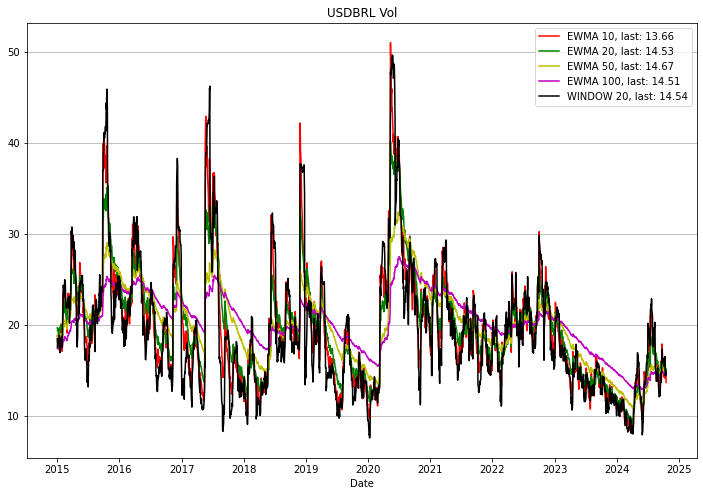

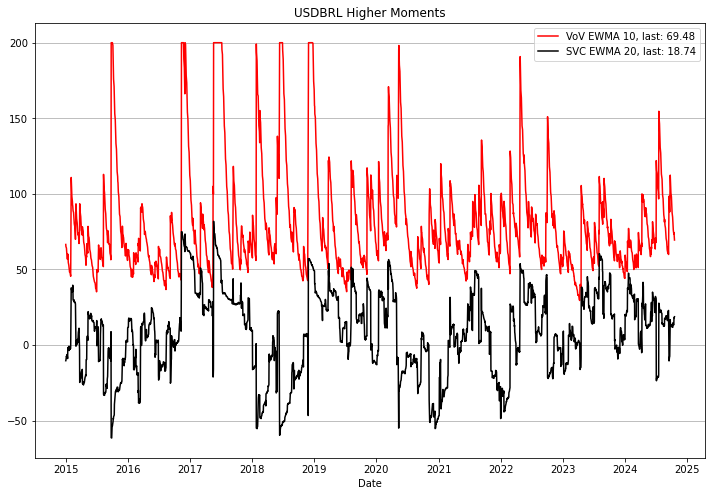

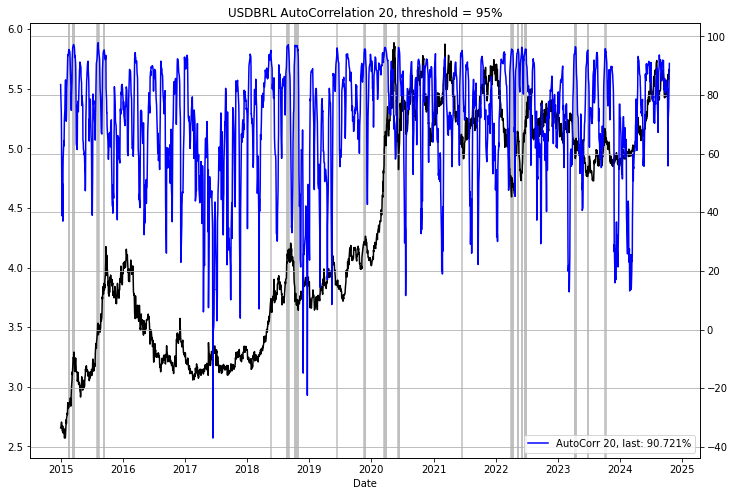

In [8]:
# FX VOL STUDIES

import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
import warnings
import joblib
from datetime import datetime
from datetime import timedelta
from datetime import date
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def on_selection(value):
    global choice_pair
    choice_pair = value
    root.destroy()
    
FX_Prices_df = open_df('fxprices_relation')

choice_list = FX_Prices_df.columns.values.tolist()
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *choice_list, command = on_selection)
tk.Label(root, text = "Choose a PAIR").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop()    
    
start_date = datetime(2015, 1, 1).date()
pair_s = FX_Prices_df[choice_pair]
pairReturns_s = pair_s.pct_change()

ewm10_s = round(100 * pairReturns_s.ewm(halflife = 10).std().dropna() * np.sqrt(360), 2).replace({0: np.nan}).dropna()
ewm20_s = round(100 * pairReturns_s.ewm(halflife = 20).std().dropna() * np.sqrt(360), 2).replace({0: np.nan}).dropna()
ewm50_s = round(100 * pairReturns_s.ewm(halflife = 50).std().dropna() * np.sqrt(360), 2).replace({0: np.nan}).dropna()
ewm100_s = round(100 * pairReturns_s.ewm(halflife = 100).std().dropna() * np.sqrt(360), 2).replace({0: np.nan}).dropna()
w20_s = round(100 * pairReturns_s.rolling(20).std().dropna() * np.sqrt(360), 2).replace({0: np.nan}).dropna()
pair_s = pair_s.loc[ewm10_s.index]
autocorr_s = pair_s.rolling(20).apply(lambda x: x.autocorr(lag = 1))
autocorr_s = round(100 * autocorr_s.dropna(), 3)
ewmAVG_s = (ewm10_s + ewm20_s) / 2
ewm10VOV_s = round(100 * ewmAVG_s.pct_change().ewm(halflife = 10).std().dropna() * np.sqrt(360), 2).replace({0: np.nan}).dropna()
svc_s = round(100 * (ewmAVG_s.pct_change().ewm(halflife = 20).corr(pairReturns_s.ewm(halflife = 20)).dropna()), 2)

pair_s = pair_s[pair_s.index >= start_date]
ewm10_s = ewm10_s[ewm10_s.index >= start_date]
ewm20_s = ewm20_s[ewm20_s.index >= start_date]
ewm50_s = ewm50_s[ewm50_s.index >= start_date]
ewm100_s = ewm100_s[ewm100_s.index >= start_date]
w20_s = w20_s[w20_s.index >= start_date]
autocorr_s = autocorr_s[autocorr_s.index >= start_date]
ewm10VOV_s = ewm10VOV_s[ewm10VOV_s.index >= start_date]
svc_s = svc_s[svc_s.index >= start_date]

# VOL PLOTS
ewm10_s.clip(0, 60).plot(c = 'r', figsize = (12, 8), label = 'EWMA 10, last: ' + str(ewm10_s.iloc[-1]))
ewm20_s.clip(0, 60).plot(c = 'g', figsize = (12, 8), label = 'EWMA 20, last: ' + str(ewm20_s.iloc[-1]))
ewm50_s.clip(0, 60).plot(c = 'y', figsize = (12, 8), label = 'EWMA 50, last: ' + str(ewm50_s.iloc[-1]))
ewm100_s.clip(0, 60).plot(c = 'm', figsize = (12, 8), label = 'EWMA 100, last: ' + str(ewm100_s.iloc[-1]))
w20_s.clip(0, 60).plot(c = 'k', figsize = (12, 8), label = 'WINDOW 20, last: ' + str(w20_s.iloc[-1])).legend(loc = 'best')
plt.grid(axis = 'y')
plt.title(choice_pair + ' Vol')
plt.show()

# VoV vs SVC
ewm10VOV_s.clip(0, 200).plot(figsize = (12, 8), c = 'r', label = 'VoV EWMA 10, last: ' + str(ewm10VOV_s.iloc[-1]))
svc_s.plot(c = 'k', label = 'SVC EWMA 20, last: ' + str(svc_s.iloc[-1])).legend(loc = 'best')
plt.grid(axis = 'y')
plt.title(choice_pair + ' Higher Moments')
plt.show()

# AUTOCORR
ac_thresh = 95
ac_highs_s = autocorr_s[autocorr_s > ac_thresh]
for dt_spam in autocorr_s.index:
    if (dt_spam in ac_highs_s.index):
        plt.axvline(x = dt_spam, c = '0.75')
(pair_s).plot(figsize = (12, 8), c = 'k').twinx()        
autocorr_s.plot(c = 'b', label = 'AutoCorr 20, last: ' + str(autocorr_s.iloc[-1]) + '%').legend(loc = 'lower right')        
plt.grid()
plt.title(choice_pair + ' AutoCorrelation 20, threshold = ' + str(ac_thresh) + '%')
plt.show()

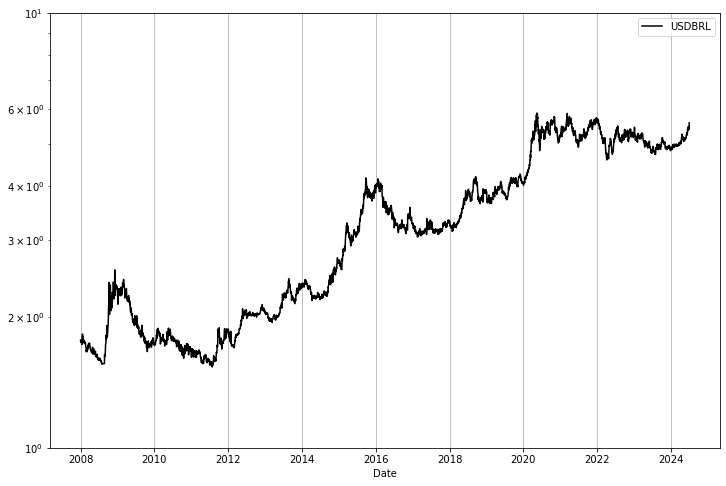

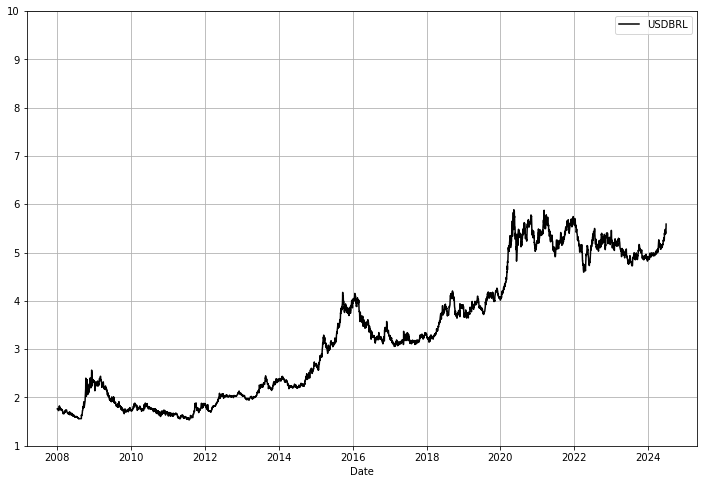

In [168]:
# N vs LN

#choice_pair = 'USDBRL'
start_dt = datetime(2008, 1, 1).date()
pair_s = FX_Prices_df[choice_pair]
pair_s = pair_s[pair_s.index >= start_dt]
pair_s.plot(figsize = (12, 8), c = 'k', label = 'USDBRL').legend(loc = 'best')
plt.yscale('log')
plt.ylim([1, 10])
plt.grid()
plt.show()

pair_s.plot(figsize = (12, 8), c = 'k', label = 'USDBRL').legend(loc = 'best')
plt.ylim([1, 10])
plt.grid()
plt.show()

C/c for carry (empty for inflation adj): C
Enter start date (empty for 01-Jan-2015 or YY/MM/DD): 23/01/01
Enter end date (empty for last or YY/MM/DD): 


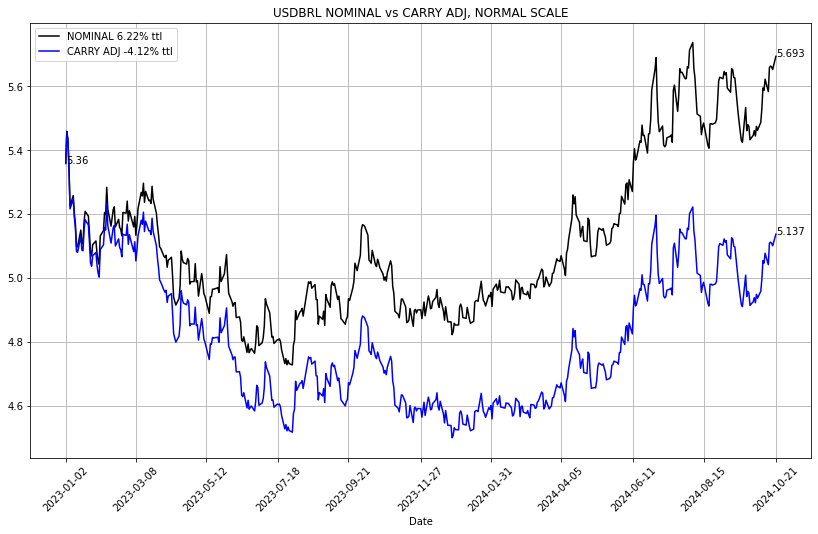

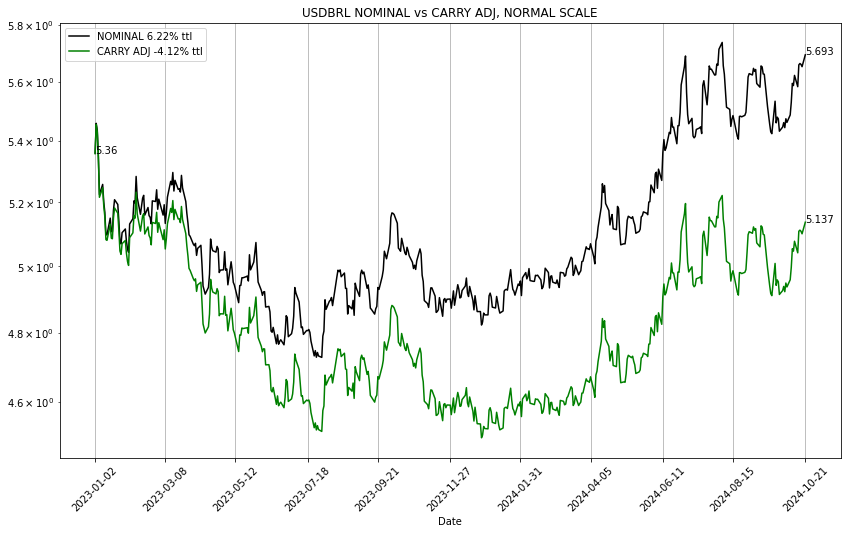

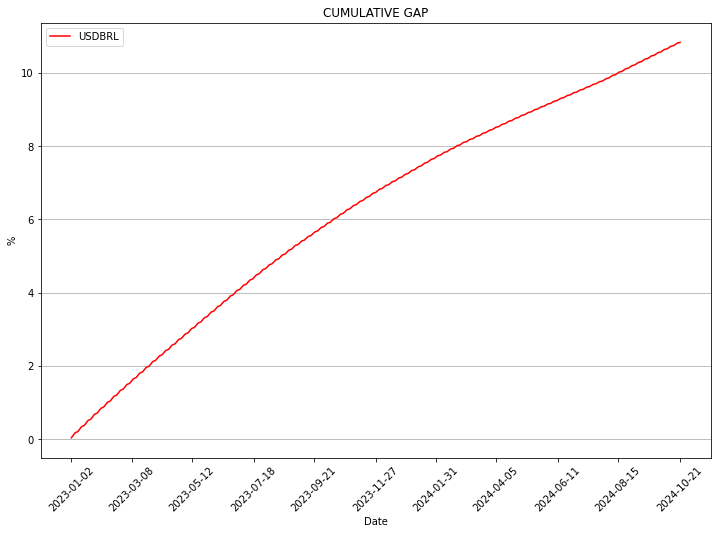

In [20]:
# PLOTS REAL FX RATES OVER TIME

def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df

def on_selection(value):
    global choice_pair
    choice_pair = value
    root.destroy()

macro_dikt = {'EUR': 'EA_', 'USD': 'US_', 'AUD': 'AU_', 'CAD': 'CA','JPY': 'JP_', 'GBP': 'GB_', 'BRL': 'BR_', 
              'MXN': 'MX_', 'ZAR': 'ZA_'}
inflation_dikt = {'EUR': 'INFLATION RATE MOM', 'USD': 'INFLATION RATE MOM', 'AUD': 'CONSUMER INFLATION EXPECTATIONS', 
                  'CAD': 'INFLATION RATE MOM', 'JPY': 'INFLATION RATE YOY', 'GBP': 'INFLATION RATE MOM', 
                  'BRL': 'INFLATION RATE MOM', 'MXN': 'INFLATION RATE MOM', 'ZAR': 'INFLATION RATE MOM'}
rates_dikt = {'EUR': 'EUROPE 2Y', 'USD': 'US GOVT 2Y', 'AUD': 'AUS GOVT 2Y', 
              'CAD': 'CAN GOVT 2Y', 'JPY': 0, 'GBP': 'UK GOVT 2Y', 'BRL': 0, 'MXN': 0, 'ZAR': 0}
carry_dikt = {'EUR': 'MKT', 'USD': 'FED INTEREST RATE DEC', 'AUD': 'RBA INTEREST RATE DEC', 
              'CAD': 'BOC INTEREST RATE DEC', 'JPY': 0, 'GBP': 'BOE INTEREST RATE DEC', 
              'BRL': 'SELIC RATE', 'MXN': 'INTEREST RATE DEC', 'ZAR': 'INTEREST RATE DEC'}
mult_dikt = {'EUR': 1, 'USD': 1, 'AUD': 12, 'CAD': 1, 'JPY': 12, 'GBP': 1, 'BRL': 1, 'MXN': 1, 'ZAR': 1}

FX_Prices_df = open_df('fxprices_relation')
Rates_df = open_df('global_rates_dm')

choice_list = FX_Prices_df.columns.values.tolist()
root = tk.Tk()
tkvar = tk.StringVar(root)
popupMenu = tk.OptionMenu(root, tkvar, *choice_list, command = on_selection)
tk.Label(root, text = "Choose a PAIR").grid(row = 0, column = 0)
popupMenu.grid(row = 1, column = 0)
root.mainloop() 

carry_b = False
carry_c = input('C/c for carry (empty for inflation adj): ').upper()
if (carry_c == 'C'):
    carry_b = True
    
start_date = datetime(2015, 1, 1).date()
end_date = FX_Prices_df.index[-1]

st_c = input('Enter start date (empty for 01-Jan-2015 or YY/MM/DD): ')
try:
    start_date = datetime.strptime(st_c, "%y/%m/%d").date()
except:
    pass
ed_c = input('Enter end date (empty for last or YY/MM/DD): ')
try:
    end_date = datetime.strptime(ed_c, "%y/%m/%d").date()
except:
    pass

Npair_s = FX_Prices_df[FX_Prices_df.index >= start_date][FX_Prices_df[FX_Prices_df.index >= start_date].index <= end_date][choice_pair]
Npair_s.name = choice_pair + '_NOMINAL'

ccy01 = choice_pair[:3]
ccy02 = choice_pair[3:]
macro1_df = open_df(macro_dikt[ccy01] + 'macro')
macro2_df = open_df(macro_dikt[ccy02] + 'macro')

infl1_s = macro1_df[macro1_df.index >= start_date][macro1_df[macro1_df.index >= start_date].index <= end_date][inflation_dikt[ccy01]] / 100
infl2_s = macro2_df[macro2_df.index >= start_date][macro2_df[macro2_df.index >= start_date].index <= end_date][inflation_dikt[ccy02]] / 100

if (carry_dikt[ccy01] == 0):
    carry1_s = infl1_s.clip(0, 0)
elif (carry_dikt[ccy01] == 'MKT'):
    carry1_s = Rates_df[Rates_df.index >= start_date][Rates_df[Rates_df.index >= start_date].index <= end_date][rates_dikt[ccy01]] / 100
else:
    carry1_s = macro1_df[macro1_df.index >= start_date][macro1_df[macro1_df.index >= start_date].index <= end_date][carry_dikt[ccy01]] / 100
    
if (carry_dikt[ccy02] == 0):
    carry2_s = infl2_s.clip(0, 0)
elif (carry_dikt[ccy02] == 'MKT'):
    carry2_s = Rates_df[Rates_df.index >= start_date][Rates_df[Rates_df.index >= start_date].index <= end_date][rates_dikt[ccy02]] / 100
else:
    carry2_s = macro2_df[macro2_df.index >= start_date][macro2_df[macro2_df.index >= start_date].index <= end_date][carry_dikt[ccy02]] / 100

if (carry_b):
    adj1_s = carry1_s.copy()
    adj2_s = carry2_s.copy()  
    adj_str = 'CARRY ADJ'
else:
    adj1_s = infl1_s.copy()
    adj2_s = infl2_s.copy()
    adj_str = 'INFL ADJ'

adj1_s.index = adj1_s.index.map(lambda x: datetime(x.year, x.month, x.day))
adj2_s.index = adj2_s.index.map(lambda x: datetime(x.year, x.month, x.day))
if (carry_b):
    adj1_s = (1 + adj1_s.resample('M').last()) ** (1 / 12) - 1
    adj2_s = (1 + adj2_s.resample('M').last()) ** (1 / 12) - 1
else:
    adj1_s = (1 + adj1_s.resample('M').last()) ** (1 / mult_dikt[ccy01]) - 1
    adj2_s = (1 + adj2_s.resample('M').last()) ** (1 / mult_dikt[ccy02]) - 1

adj1_s.index = adj1_s.index.map(lambda x: x.date())
adj2_s.index = adj2_s.index.map(lambda x: x.date())

pair_df = pd.DataFrame(Npair_s).join(adj1_s).join(adj2_s, rsuffix = '_' + ccy2).fillna(method = 'bfill').fillna(method = 'ffill')
pair_df['adj IDX 1'] = (pd.Series(pair_df[pair_df.columns[1]].values / 21).expanding().sum() + 1).values
pair_df['adj IDX 2'] = (pd.Series(pair_df[pair_df.columns[2]].values / 21).expanding().sum() + 1).values
pair_df[choice_pair + '_' + adj_str] = pair_df[choice_pair + '_NOMINAL'] * pair_df['adj IDX 1'] / pair_df['adj IDX 2']

period_changeN = round(100 * (pair_df[choice_pair + '_NOMINAL'].iloc[-1] / pair_df[choice_pair + '_NOMINAL'].iloc[0] - 1), 2)
period_changeR = round(100 * (pair_df[choice_pair + '_' + adj_str].iloc[-1] / pair_df[choice_pair + '_' + adj_str].iloc[0] - 1), 2)

y1 = pair_df[choice_pair + '_NOMINAL']
y2 = pair_df[choice_pair + '_' + adj_str]
x1 = y1.index.values
x2 = y2.index.values

y1.plot(figsize = (14, 8), c = 'k', label = 'NOMINAL ' + str(period_changeN) + '% ttl')
y2.plot(c = 'b', label = adj_str + ' ' + str(period_changeR) + '% ttl').legend(loc = 'best')
plt.text(x1[0], y1[0], str(round(y1[0], 3)))
plt.text(x1[-1], y1[-1], str(round(y1[-1], 3)))
plt.text(x2[-1], y2[-1], str(round(y2[-1], 3)))
plt.xticks(pair_df.index[:: pair_df.shape[0] // 10], rotation = 45)
plt.title(choice_pair + ' NOMINAL vs ' + adj_str + ', NORMAL SCALE')
plt.grid()
plt.show()

y1.plot(figsize = (14, 8), c = 'k', label = 'NOMINAL ' + str(period_changeN) + '% ttl')
y2.plot(c = 'g', label = adj_str + ' ' + str(period_changeR) + '% ttl').legend(loc = 'best')
plt.text(x1[0], y1[0], str(round(y1[0], 3)))
plt.text(x1[-1], y1[-1], str(round(y1[-1], 3)))
plt.text(x2[-1], y2[-1], str(round(y2[-1], 3)))
plt.xticks(pair_df.index[:: pair_df.shape[0] // 10], rotation = 45)
plt.title(choice_pair + ' NOMINAL vs ' + adj_str + ', NORMAL SCALE')
plt.yscale('log')
plt.grid()
plt.show()

y = round(100 * (pair_df[choice_pair + '_NOMINAL'] / pair_df[choice_pair + '_' + adj_str] - 1), 3)
x = y.index.values
y.plot(c = 'r', figsize = (12, 8), label = choice_pair).legend(loc = 'best')
plt.xticks(pair_df.index[:: pair_df.shape[0] // 10], rotation = 45)
plt.title('CUMULATIVE GAP')
plt.ylabel('%')
plt.grid(axis = 'y')
plt.show()

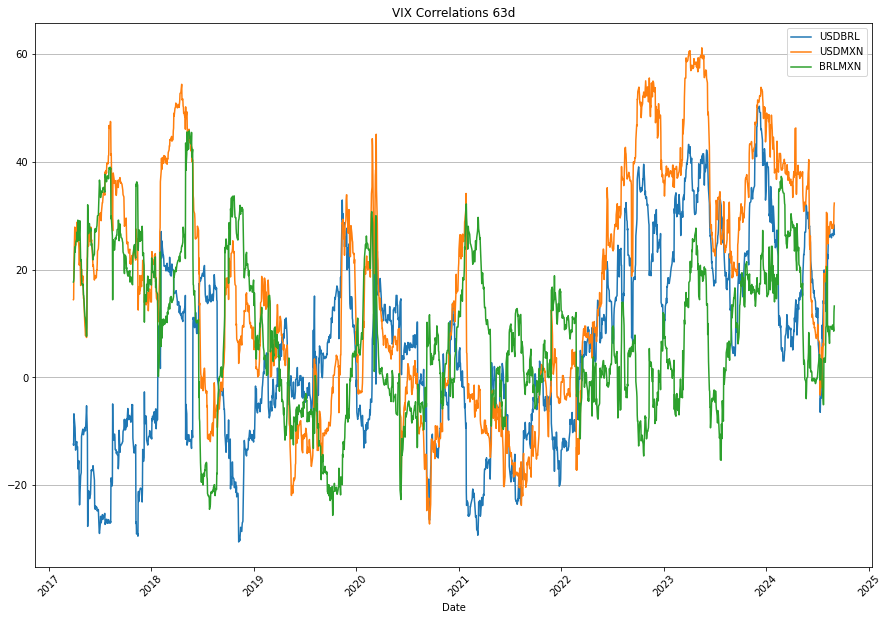

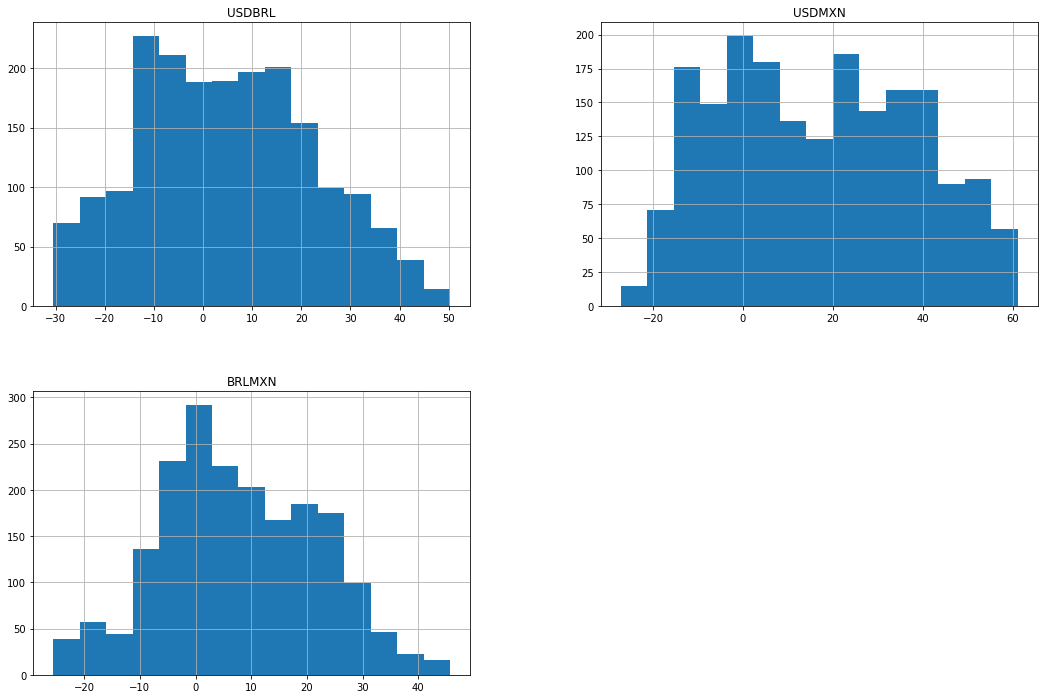

In [39]:
#VIX CORRS

import pandas as pd
import os
import csv
import re
import psycopg2
import yfinance as yf
import tkinter as tk
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from datetime import date
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def Average(lst):
    return sum(lst) / len(lst)

def Set_DF(dframe):
    
    dframe.index = dframe[dframe.columns.values.tolist()[0]]
    dframe.index.name = dframe.columns.values.tolist()[0]
    New_df = dframe.drop(dframe.columns.values.tolist()[0], axis=1)
    
    return New_df

def DD_Index(dframe):
    
    dframe['dummy'] = dframe.index
    dframe.drop_duplicates(['dummy'], inplace=True)
    dframe.drop('dummy', axis=1, inplace=True)
    New_df = dframe
    
    return New_df

def on_selection(value):
    global choice_lag
    choice_lag = value  # store the user's choice
    root.destroy()  # close window
    
def open_df(*args):
    open_str = args[0]
    
    query_open = 'SELECT * FROM ' + open_str
    opened_df = pd.read_sql_query(query_open, engine)
    opened_df = Set_DF(opened_df)
    opened_df = DD_Index(opened_df)
    opened_df = opened_df.sort_index()
    
    return opened_df    
    
def on_selection_pair(value):
    global choice_pair
    choice_pair = value  # store the user's choice
    root.destroy()  # close window
    
dbase = "visiblealpha_laptop"

conn = psycopg2.connect(host="localhost", user="postgres", password="akf7a7j5", dbname=dbase, port=5432)
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
tables_list = cursor.fetchall()
new_tables_list=[]
len_tl=len(tables_list)
cont_tl=0
while (cont_tl<len_tl):
    new_tables_list.append(re.sub(r'[^a-z_^0-9]', '', str(tables_list[cont_tl])))
    cont_tl=cont_tl+1

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
              "@{host}:{port}/{database}")

engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="akf7a7j5",
    host="localhost",
    port=5432,
    database=dbase))
    
today = date.today()
corr_spam = 2000
corr_window = 63
base = 'VIX'

Pxs_df = open_df('prices_relation')
FX_Prices_df = open_df('fxprices_relation')
FXPairs_List = FX_Prices_df.columns.tolist()
pairs_list = FXPairs_List
pairs_list.append('')
keep_asking = True
count = 0
vix_s = Pxs_df[base].pct_change()[-corr_spam: ]

while (keep_asking):
    root = tk.Tk()
    tkvar = tk.StringVar(root)
    popupMenu = tk.OptionMenu(root, tkvar, *pairs_list, command = on_selection_pair)
    tk.Label(root, text = "Choose a pair").grid(row = 0, column = 0)
    popupMenu.grid(row = 1, column = 0)
    root.mainloop()
    if (choice_pair != ''):                    
        fx_s = FX_Prices_df[choice_pair].pct_change()[-corr_spam: ]
        if (count == 0):
            fx_df = pd.DataFrame(fx_s)
        else:
            fx_df = fx_df.join(fx_s)
        count += 1
    else:
        keep_asking = False
        
if (fx_df.shape[1] > 0):                    
    corr_df = fx_df.rolling(corr_window).corr(vix_s.rolling(corr_window)).dropna().apply(lambda x: round(100 * x, 2))
    corr_df.plot(figsize = (15, 10)).legend(loc = 'best')
    plt.xticks(rotation = '45')
    plt.grid(axis = 'y')
    plt.title('VIX Correlations ' + str(corr_window) + 'd')
    plt.show()
    
    corr_df.hist(bins = 15, figsize = (18, 12))
    plt.show()    

Fwd: 5.8712, continue? (N/n to stop)
# of paths (empty for 700): 5000

10- spot: 6.788, vol: 11.69
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4846.08
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 384.08

20- spot: 5.7112, vol: 12.56
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -5805.74
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 538.03

30- spot: 5.6428, vol: 8.3
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -5743.26
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 535.31

40- spot: 5.6151, vol: 5.03
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -5576.97
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 550.87

50- spot: 5.866, vol: 15.97
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -5542.09
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 555.78

60- spot: 6.5222, vol: 24.24
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -5286.53
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 517.24

70- spot: 5.59, vol: 11.36
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -5382.63
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 525.21

620- spot: 6.4932, vol: 14.33
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4851.28
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 466.09

630- spot: 5.4832, vol: 8.63
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4821.8
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 461.21

640- spot: 4.8988, vol: 17.58
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4810.4
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 460.52

650- spot: 8.3101, vol: 16.69
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4847.91
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 465.37

660- spot: 6.5699, vol: 14.76
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4837.91
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 463.22

670- spot: 5.8338, vol: 16.13
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4824.23
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 464.56

680- spot: 5.4164, vol: 8.23
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4817.17
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 460.06

690- spot: 7.0746, vol: 13.43
Price CS 1-1 (bps): 0.0
Price

1230- spot: 7.4295, vol: 9.91
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4665.56
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 441.85

1240- spot: 5.5974, vol: 12.92
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4646.51
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 438.94

1250- spot: 5.955, vol: 26.96
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4662.01
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 441.47

1260- spot: 6.5288, vol: 8.7
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4667.53
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 442.25

1270- spot: 7.0148, vol: 10.25
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4674.21
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 442.27

1280- spot: 4.8445, vol: 4.56
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4666.7
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 441.15

1290- spot: 8.4209, vol: 28.18
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4671.43
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 442.19

1300- spot: 5.6697, vol: 4.24
Price CS 1-1 (bps): 0.0


1840- spot: 6.4132, vol: 16.23
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4711.52
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 440.61

1850- spot: 6.2519, vol: 17.56
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4710.91
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 441.48

1860- spot: 6.0019, vol: 11.76
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4714.17
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 441.17

1870- spot: 5.2566, vol: 5.34
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4727.17
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 444.72

1880- spot: 5.4139, vol: 22.22
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4731.09
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 445.12

1890- spot: 5.4958, vol: 9.95
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4723.64
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 443.89

1900- spot: 5.8718, vol: 10.6
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4731.77
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 444.73

1910- spot: 6.7704, vol: 22.6
Price CS 1-1 (bps): 0

2450- spot: 6.1033, vol: 9.24
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4683.01
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 439.95

2460- spot: 5.6146, vol: 10.94
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4687.3
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 440.2

2470- spot: 6.9906, vol: 22.14
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4693.71
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 442.18

2480- spot: 4.8254, vol: 9.75
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4692.55
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 441.97

2490- spot: 6.2834, vol: 7.14
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4697.91
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 442.74

2500- spot: 6.035, vol: 13.45
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4702.66
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 444.06

2510- spot: 5.3242, vol: 11.34
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4709.97
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 445.1

2520- spot: 5.2994, vol: 7.76
Price CS 1-1 (bps): 0.0
P

3060- spot: 5.5304, vol: 7.49
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4660.9
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 445.08

3070- spot: 5.7676, vol: 9.32
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4661.78
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 445.33

3080- spot: 5.0157, vol: 8.4
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4661.93
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 446.26

3090- spot: 5.5221, vol: 6.28
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4656.87
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 445.69

3100- spot: 4.7153, vol: 12.46
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4652.23
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 445.49

3110- spot: 5.4292, vol: 11.3
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4656.16
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 446.15

3120- spot: 6.2601, vol: 18.89
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4653.83
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 445.01

3130- spot: 5.7135, vol: 13.85
Price CS 1-1 (bps): 0.0


3670- spot: 4.9064, vol: 11.72
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4655.97
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 447.33

3680- spot: 4.9023, vol: 7.57
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4658.02
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 447.34

3690- spot: 6.2752, vol: 11.66
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4653.69
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 446.89

3700- spot: 5.7186, vol: 12.16
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4650.79
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 446.37

3710- spot: 6.766, vol: 15.31
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4652.35
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 446.92

3720- spot: 5.1099, vol: 10.21
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4651.84
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 447.22

3730- spot: 7.8478, vol: 22.44
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4655.23
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 448.61

3740- spot: 4.9293, vol: 10.79
Price CS 1-1 (bps):

4280- spot: 4.5906, vol: 20.06
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4707.23
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 460.05

4290- spot: 6.4574, vol: 7.64
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4705.6
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 460.0

4300- spot: 5.8168, vol: 16.36
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4703.82
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 460.01

4310- spot: 7.8357, vol: 12.79
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4704.19
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 460.61

4320- spot: 5.5235, vol: 10.49
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4703.25
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 460.22

4330- spot: 5.8067, vol: 18.81
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4702.0
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 459.78

4340- spot: 6.2262, vol: 16.19
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4701.08
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 458.89

4350- spot: 5.5608, vol: 7.79
Price CS 1-1 (bps): 0.

4890- spot: 5.7771, vol: 12.3
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4712.62
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 462.27

4900- spot: 5.0373, vol: 8.5
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4709.23
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 462.04

4910- spot: 5.6447, vol: 7.68
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4711.12
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 462.41

4920- spot: 6.7485, vol: 20.11
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4709.91
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 462.36

4930- spot: 5.2847, vol: 8.21
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4706.99
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 461.78

4940- spot: 6.3359, vol: 4.32
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4710.73
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 462.43

4950- spot: 4.8597, vol: 13.63
Price CS 1-1 (bps): 0.0
Price CS 1-5 (bps): -4708.32
Price ERKO (bps)  : 0.0
Price RKO (bps)   : 462.13

4960- spot: 5.1439, vol: 5.46
Price CS 1-1 (bps): 0.0


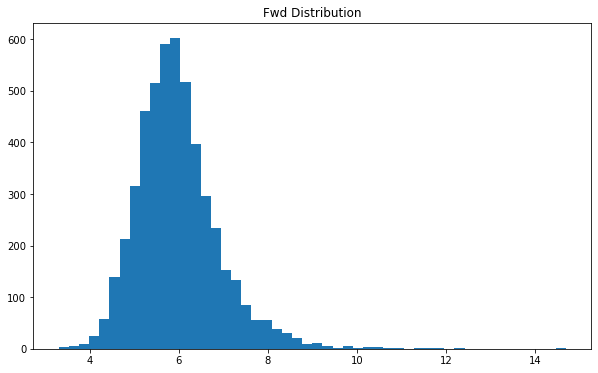

In [3]:
## AMERICAN OPTIONS DRAFT PRICER - MONTECARLO W/ STOCH VOL (SABR)

import pandas as pd
import math
import numpy as np
import os
import csv
import yfinance as yf
#import mysql.connector
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import tkinter as tk
import re
from datetime import datetime
from datetime import timedelta
from datetime import date
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression

def on_selection(value):
    global choice_nature
    choice_nature = value  # store the user's choice
    root.destroy()  # close window

class random_walk:
    
    def __init__(self, *args):
        self.id_samples = args[0]
        self.days = args[1]
        self.d_rate = args[2]
        self.f_rate = args[3]
        self.spot0 = args[4]
        self.vol0 = args[5] * np.sqrt(1 / 360)
        self.vov = args[6] * np.sqrt(1 / 360)
        self.svc = args[7]
        self.k = args[8]
        self.h = args[9]
        self.spot_b = args[10]
        self.vol_b = args[11]
        self.direction = args[12]
        self.inv = args[13]
        
    def intraday_move(self, *args):
        spot = args[0]
        id_tau = 1 / self.id_samples
        vol_s = args[1]
        vol_bumped = args[2]
        spot_vb = args[3]
        i = 0
        while (i < self.id_samples):
            ws = np.random.normal(0, 1)
            wv_ = np.random.normal(0, 1)
            wv = (ws * self.svc) + (wv_ * np.sqrt(1 - self.svc ** 2))
            spot = spot * np.exp(- id_tau * (vol_s ** 2) / 2 + vol_s * ws * np.sqrt(id_tau))
            vol_s = vol_s * np.exp(- id_tau * (self.vov ** 2) / 2 + self.vov * wv * np.sqrt(id_tau)) 
            spot_vb = spot_vb * np.exp(- id_tau * (vol_bumped ** 2) / 2 + vol_bumped * ws * np.sqrt(id_tau))
            vol_bumped = vol_bumped * np.exp(- id_tau * (self.vov ** 2) / 2 + self.vov * wv * np.sqrt(id_tau))            
            i = i + 1
            
        return spot, vol_s, vol_bumped, spot_vb
    
    def daily_moves(self):
        day_count = 0
        triggered = False
        triggered_sb_up = False
        triggered_sb_down = False
        triggered_vb = False
        spot = self.spot0
        spot_d0 = self.spot0
        vol = self.vol0
        vol_bumped = (vol * np.sqrt(360) + self.vol_b) * np.sqrt(1 / 360)
        spot_bu = spot
        spot_bd = spot        
        spot_vb = spot
        direction = -1
        if (self.direction):
            direction = 1
        while (day_count < self.days):
            spot, vol, vol_bumped, spot_vb = self.intraday_move(spot, vol, vol_bumped, spot_vb)
            spot = spot * (1 + (self.d_rate - self.f_rate) * (1 / 360))                       
            spot_bu = spot * (1 + self.inv * self.spot_b)
            spot_bd = spot * (1 - self.inv * self.spot_b)
            spot_vb = spot_vb * (1 + (self.d_rate - self.f_rate) * (1 / 360))
            if (direction * spot >= direction * self.h):
                triggered = True
            if (direction * spot_bu >= direction * self.h):
                triggered_sb_up = True
            if (direction * spot_bd >= direction * self.h):
                triggered_sb_down = True
            if (direction * spot_vb >= direction * self.h):
                triggered_vb = True
            day_count = day_count + 1
        
        return spot, vol, spot_vb, triggered, triggered_sb_up, triggered_sb_down, triggered_vb
    
class payouts:
    
    def __init__(self, *args):
        self.k = args[0]
        self.h = args[1]
        self.cp = args[2]
        self.trigger = args[3]
        self.days = args[4]
        self.rate = args[5]
        self.spot = args[6]
        self.ratio = args[7]
    
    def reg_opt_spread(self):
        payout =  max(min(self.cp * self.spot, self.cp * self.h) - self.cp * self.k, 0) * (self.k ** (-1)) * ((1 + self.rate * (self.days / 360)) ** (-1))
        
        return payout
    
    def lev_opt_spread(self):
        payout = (max(self.cp * self.spot - self.cp * self.k, 0) * (self.k ** (-1)) - self.ratio * max(self.cp * self.spot - self.cp * self.h, 0) * (self.h ** (-1))) * ((1 + self.rate * (self.days / 360)) ** (-1))
        
        return payout
    
    def erko(self):
        payout = 0
        if (self.cp * self.spot < self.cp * self.h):
            payout = max(self.cp * self.spot - self.cp * self.k, 0) * (self.k ** (-1)) * ((1 + self.rate * (self.days / 360)) ** (-1))
        
        return payout
    
    def rko(self):
        payout = 0
        if (not self.trigger):
            payout = max(self.cp * self.spot - self.cp * self.k, 0) * (self.k ** (-1)) * ((1 + self.rate * (self.days / 360)) ** (-1))
        
        return payout   
    
today = date.today()   
today = today + timedelta((3 - (today.weekday() % 4)) * (today.weekday() // 4))
id_samples = 20
bump_spot = 0.5 / 100
bump_vol = 0.005

############################################################

vol0 = 0.14 #0.145
vov = 0.40 #0.65
svc = 0.25 #0.375

d_rate = 10 / 100
f_rate = 5.25 / 100
spot0 = 5.590
spec_date = datetime(2025, 9, 15).date()
dc = (spec_date - today).days
days = 126
days = (dc - 1)  #################################################

call = True
k = 5.75
h = 5.30
invert = True
ratio = 5

#############################################################

spot_sum = 0
spot_vb_sum = 0
vol_sum = 0
payout_sum_i = 0
payout_sum_ii = 0
payout_sum_iii = 0
payout_sum_iv = 0
payout_sum_u_i = 0
payout_sum_u_ii = 0
payout_sum_u_iii = 0
payout_sum_u_iv = 0
payout_sum_d_i = 0
payout_sum_d_ii = 0
payout_sum_d_iii = 0
payout_sum_d_iv = 0
payout_sum_vb_i = 0
payout_sum_vb_ii = 0
payout_sum_vb_iii = 0
payout_sum_vb_iv = 0
count_path = 0
spot_list = []

trigger = False
trigger_sb = False
trigger_vb = False
cp = call * 2 - 1
inv = invert * (-2) + 1

if (invert):
    call = np.invert(call)
    cp = cp * (-1)
    rate_bu = d_rate
    d_rate = f_rate
    f_rate = rate_bu
    svc = svc * (-1)
    k = k ** (-1)
    h = h ** (-1)
    spot0 = spot0 ** (-1)
    
opt_str = 'CS'
if (call):
    opt_str = 'PS'
fwd = (spot0 * (1 + (d_rate - f_rate) * (days / 360))) ** (inv)
move_on = input('Fwd: ' + str(round(fwd, 4)) + ', continue? (N/n to stop)').upper()

if (move_on != 'N'):
    choice_list = ['Up & Out', 'Up & In', 'Down & Out', 'Down & In']
    root = tk.Tk()
    tkvar = tk.StringVar(root)
    popupMenu = tk.OptionMenu(root, tkvar, *choice_list, command = on_selection)
    tk.Label(root, text = "Nature of the Option").grid(row = 0, column = 0)
    popupMenu.grid(row = 1, column = 0)
    root.mainloop() 

    Out = True
    Up = True
    if (choice_nature == 'Up & In') | (choice_nature == 'Down & In'):
        Out = False
    if (choice_nature == 'Down & Out') | (choice_nature == 'Down & In'):
        Up = False     
    if (invert):
        Up = np.invert(Up)        

    paths = str(input('# of paths (empty for 700): '))
    print('')
    try:
        paths = int(paths)
    except:
        paths = 700    
    while (count_path < paths):
        spot, vol, spot_vb, trigger, trigger_sb_up, trigger_sb_down, trigger_vb = random_walk(id_samples, days, d_rate, f_rate, spot0, vol0, vov, svc, k, h, bump_spot, bump_vol, Up, inv).daily_moves()
        spot_list.append(spot ** (inv))
        vol = vol * np.sqrt(360)
        spot_sum = spot_sum + spot
        spot_vb_sum = spot_vb_sum + spot_vb
        vol_sum = vol_sum + vol
        count_path += 1
        spot_up = spot * (1 + inv * bump_spot)
        spot_down = spot * (1 - inv * bump_spot)
        
        price = payouts(k, h, cp, trigger, days, d_rate, spot, ratio)
        price_up = payouts(k, h, cp, trigger_sb_up, days, d_rate, spot_up, ratio)
        price_down = payouts(k, h, cp, trigger_sb_down, days, d_rate, spot_down, ratio)
        price_vb = payouts(k, h, cp, trigger_vb, days, d_rate, spot_vb, ratio)
        
        payout_sum_i = payout_sum_i + price.reg_opt_spread()
        payout_sum_ii = payout_sum_ii + price.lev_opt_spread()
        payout_sum_iii = payout_sum_iii + price.erko()
        payout_sum_iv = payout_sum_iv + price.rko()
        
        payout_sum_u_i = payout_sum_u_i + price_up.reg_opt_spread()
        payout_sum_u_ii = payout_sum_u_ii + price_up.lev_opt_spread()
        payout_sum_u_iii = payout_sum_u_iii + price_up.erko()
        payout_sum_u_iv = payout_sum_u_iv + price_up.rko()
        
        payout_sum_d_i = payout_sum_d_i + price_down.reg_opt_spread()
        payout_sum_d_ii = payout_sum_d_ii + price_down.lev_opt_spread()
        payout_sum_d_iii = payout_sum_d_iii + price_down.erko()
        payout_sum_d_iv = payout_sum_d_iv + price_down.rko()
        
        payout_sum_vb_i = payout_sum_vb_i + price_vb.reg_opt_spread()
        payout_sum_vb_ii = payout_sum_vb_ii + price_vb.lev_opt_spread()
        payout_sum_vb_iii = payout_sum_vb_iii + price_vb.erko()
        payout_sum_vb_iv = payout_sum_vb_iv + price_vb.rko()        
        
        if ((count_path % 10) == 0):
            print(str(count_path) + '- spot: ' + str(round(spot ** (-1), 4)) + ', vol: ' + str(round(100 * vol, 2)))
            print('Price ' + opt_str + ' 1-1 (bps): ' + str(round(10000 * payout_sum_i / count_path, 2)))
            print('Price ' + opt_str + ' 1-' + str(ratio) + ' (bps): ' + str(round(10000 * payout_sum_ii / count_path, 2)))
            print('Price ERKO (bps)  : ' + str(round(10000 * payout_sum_iii / count_path, 2)))
            print('Price RKO (bps)   : ' + str(round(10000 * payout_sum_iv / count_path, 2)))
            print('')

    spot_final = (spot_sum / count_path) ** (inv)
    spot_vb_final = (spot_vb_sum ** (inv)) / count_path
    vol_final = vol_sum / count_path
    price_final_i = round(10000 * payout_sum_i / count_path, 2)
    price_final_ii = round(10000 * payout_sum_ii / count_path, 2)
    price_final_iii = round(10000 * payout_sum_iii / count_path, 2)
    price_final_iv = round(10000 * payout_sum_iv / count_path, 2)
    price_final_u_i = round(10000 * payout_sum_u_i / count_path, 2)
    price_final_u_ii = round(10000 * payout_sum_u_ii / count_path, 2)
    price_final_u_iii = round(10000 * payout_sum_u_iii / count_path, 2)
    price_final_u_iv = round(10000 * payout_sum_u_iv / count_path, 2)
    price_final_d_i = round(10000 * payout_sum_d_i / count_path, 2)
    price_final_d_ii = round(10000 * payout_sum_d_ii / count_path, 2)
    price_final_d_iii = round(10000 * payout_sum_d_iii / count_path, 2)
    price_final_d_iv = round(10000 * payout_sum_d_iv / count_path, 2)
    price_final_vb_i = round(10000 * payout_sum_vb_i / count_path, 2)
    price_final_vb_ii = round(10000 * payout_sum_vb_ii / count_path, 2)
    price_final_vb_iii = round(10000 * payout_sum_vb_iii / count_path, 2)
    price_final_vb_iv = round(10000 * payout_sum_vb_iv / count_path, 2)
    delta_i = round((price_final_u_i - price_final_d_i) / bump_spot / 100 / (1 / bump_spot / 100), 2)
    delta_ii = round((price_final_u_ii - price_final_d_ii) / bump_spot / 100 / (1 / bump_spot / 100), 2)
    delta_iii = round((price_final_u_iii - price_final_d_iii) / bump_spot / 100 / (1 / bump_spot / 100), 2)
    delta_iv = round((price_final_u_iv - price_final_d_iv) / bump_spot / 100 / (1 / bump_spot / 100), 2)
    vega_i = round(200 * (price_final_vb_i - price_final_i), 0)
    vega_ii = round(200 * (price_final_vb_ii - price_final_ii), 0)
    vega_iii = round(200 * (price_final_vb_iii - price_final_iii), 0)
    vega_iv = round(200 * (price_final_vb_iv - price_final_iv), 0)
    
    print('')
    print('RESULTS:')
    print('')
    print('Projected Spot: ' + str(round(spot_final, 4)))
    print('Vol: ' + str(round(100 * vol_final, 2)))
    print('')
    print('####################################################################################################################')
    print('PRICE 1-1 ' + opt_str + ': ' + str(price_final_i))
    print('PRICE 1-' + str(ratio) + ' ' + opt_str + ': ' + str(price_final_ii))
    print('PRICE ERKO  : ' + str(price_final_iii))
    print('PRICE RKO   : ' + str(price_final_iv))
    print('')
    print('DELTA % 1-1 ' + opt_str + ': ' + str(delta_i))
    print('DELTA % 1-' + str(ratio) + ' ' + opt_str + ': ' + str(delta_ii))
    print('DELTA % ERKO  : ' + str(delta_iii))
    print('DELTA % RKO   : ' + str(delta_iv))
    print('')
    print('VEGA 1mm Not, 1-1 ' + opt_str + ': ' + str("{:,.0f}".format(vega_i)))
    print('VEGA 1mm Not, 1-' + str(ratio) + ' ' + opt_str + ': ' + str("{:,.0f}".format(vega_ii)))
    print('VEGA 1mm Not, ERKO  : ' + str("{:,.0f}".format(vega_iii)))
    print('VEGA 1mm Not, RKO   : ' + str("{:,.0f}".format(vega_iv)))
    print('')
    pd.Series(spot_list).hist(bins = 50, figsize = (10, 6))
    plt.title('Fwd Distribution')
    plt.grid(False)

In [1377]:
#DOUBLE CHECK

F_Mixed_df = Mixed_df
F_FX_Prices_df = FX_Prices_df
MixedUP_df = F_Mixed_df[F_Mixed_df >= THRESH_UP].fillna(0).clip(0, 1)
MixedDOWN_df = F_Mixed_df[F_Mixed_df <= THRESH_DOWN].fillna(0).clip(-1, 0)
Mixed_Final = MixedUP_df + MixedDOWN_df
Dates_List = Mixed_Final.index.values.tolist()
Positions_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
Sizes_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
FXPrices_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])

for idx, current_date in enumerate(Dates_List):
    Long_List = []
    Short_List = []
    count_long = 0
    count_short = 0
    Long_List = Mixed_Final.loc[current_date][Mixed_Final.loc[current_date] == 1].index.values.tolist()
    Short_List = Mixed_Final.loc[current_date][Mixed_Final.loc[current_date] == -1].index.values.tolist()
    if (idx == 0):
        prev_Short_List = Short_List.copy()
        prev_Long_List = Long_List.copy()
    longs_nr = len(Long_List)
    shorts_nr = len(Short_List)
    if (longs_nr > 0) & (shorts_nr == 0):
        shorts_nr = 1
        Short_List = F_Mixed_df.loc[current_date].sort_values()[:1].index.values.tolist()
    if (shorts_nr > 0) & (longs_nr == 0):
        longs_nr = 1
        Long_List = F_Mixed_df.loc[current_date].sort_values()[-1:].index.values.tolist()
    if (shorts_nr > 0):
        long_size = Standard_Size / shorts_nr
    if (longs_nr > 0):
        short_size = Standard_Size / longs_nr
    if (longs_nr > 3):
        Long_List = F_Mixed_df.loc[current_date].sort_values()[-3:].index.values.tolist()
    if (shorts_nr > 3):
        Short_List = F_Mixed_df.loc[current_date].sort_values()[:3].index.values.tolist()
    for ccy01 in Long_List:
        for ccy02 in Short_List:
            pair = ccy01 + ccy02
            if (pair in FX_Pairs_List):
                exp = 1
                aux_pair = 'USD' + ccy01
                if (aux_pair not in FX_Pairs_List):
                    aux_pair = ccy01 + 'USD'
                    exp = -1
                count_long = count_long + 1
                col = 'Long ' + str(count_long)
                Positions_df.loc[current_date, col] = pair
                if (prev_Short_List == Short_List) & (prev_Long_List == Long_List) & (idx > 0):
                    Positions_df_s = Positions_df[:idx].copy()
                    lr_date = ((Positions_df_s == Positions_df_s.shift(1)).sum(axis = 1) == len(Positions_df_s.columns)).replace({True: np.nan}).dropna().index[-1]
                else:
                    lr_date = current_date
                FXPrices_df.loc[current_date, col] = F_FX_Prices_df.loc[current_date, pair]
                if (aux_pair == 'USDUSD'):
                    notional_adj = 1
                else:
                    notional_adj = F_FX_Prices_df.loc[lr_date, aux_pair] ** exp
                Sizes_df.loc[current_date, col] = long_size * notional_adj
            else:
                pair = ccy02 + ccy01
                exp = 1
                aux_pair = 'USD' + ccy02
                if (aux_pair not in FX_Pairs_List):
                    aux_pair = ccy02 + 'USD'
                    exp = -1
                count_short = count_short + 1
                col = 'Short ' + str(count_short)
                Positions_df.loc[current_date, col] = pair
                if (prev_Short_List == Short_List) & (prev_Long_List == Long_List) & (idx > 0):
                    Positions_df_s = Positions_df[:idx].copy()
                    lr_date = ((Positions_df_s == Positions_df_s.shift(1)).sum(axis = 1) == len(Positions_df_s.columns)).replace({True: np.nan}).dropna().index[-1]
                else:
                    lr_date = current_date
                FXPrices_df.loc[current_date, col] = F_FX_Prices_df.loc[current_date, pair]
                if (aux_pair == 'USDUSD'):
                    notional_adj = 1
                else:
                    notional_adj = F_FX_Prices_df.loc[lr_date, aux_pair] ** exp
                Sizes_df.loc[current_date, col] = long_size * notional_adj
    prev_Short_List = Short_List
    prev_Long_List = Long_List


pair = 'AUDMXN'

FX_PnL_df = pd.DataFrame(0, index = Positions_df.index, columns = F_FX_Prices_df.columns)
Pairs_List = FX_PnL_df.columns.values.tolist()
Long_df = Positions_df.T[Positions_df.columns.map(lambda x: x.find('Long')) != -1].T
Short_df = Positions_df.T[Positions_df.columns.map(lambda x: x.find('Short')) != -1].T
TradingCosts_ttl = 0
Pairs_List = [pair]
for current_pair in Pairs_List:
    go_ahead = False
    Long_Dates_List = Long_df[Long_df == current_pair].dropna(thresh = 1).index.values.tolist()
    Short_Dates_List = Short_df[Short_df == current_pair].dropna(thresh = 1).index.values.tolist()
    Px_Series = pd.Series(0, index = Positions_df.index)
    USDAcc_Series = pd.Series(0, index = Positions_df.index)
    USDUnd_Series = pd.Series(0, index = Positions_df.index)
    if (len(Long_Dates_List) > 0):
        go_ahead = True
        CP_df = pd.DataFrame(7, index = Positions_df.index, columns = [current_pair])
        CP_df.loc[Long_Dates_List, current_pair] = 1
    if (len(Short_Dates_List) > 0):
        go_ahead = True
        if (len(Long_Dates_List) > 0):
            CP_df.loc[Short_Dates_List, current_pair] = -1
        else:
            CP_df = pd.DataFrame(7, index = Positions_df.index, columns = [current_pair])
            Px_Series = pd.Series(0, index = Positions_df.index)
            CP_df.loc[Short_Dates_List, current_pair] = -1
    if (go_ahead):
        CP_df = CP_df.replace({7: 0})
        if (len(CP_df[current_pair][CP_df[current_pair] != 0].index) > 0):
            Dates_List = CP_df.index.values.tolist()
            unwind = False
            for current_date in Dates_List:
                Px_Series.loc[current_date] = F_FX_Prices_df.loc[current_date, current_pair]
                USD_pair_acc = 'USD' + current_pair[-3:]
                USD_pair_und = 'USD' + current_pair[:-3]
                mult = -1
                if (USD_pair_acc not in F_FX_Prices_df.columns):
                    USD_pair_acc = current_pair[-3:] + 'USD'
                    mult = 1
                if (USD_pair_acc == 'USDUSD'):
                    USDAcc_Series.loc[current_date] = 1
                else:
                    USDAcc_Series.loc[current_date] = F_FX_Prices_df.loc[current_date, USD_pair_acc] ** mult
                mult2 = -1
                if (USD_pair_und not in F_FX_Prices_df.columns):
                    USD_pair_und = current_pair[:-3] + 'USD'
                    mult2 = 1
                if (USD_pair_und == 'USDUSD'):
                    USDUnd_Series.loc[current_date] = 1
                else:
                    USDUnd_Series.loc[current_date] = F_FX_Prices_df.loc[current_date, USD_pair_und] ** mult2
                side = -1
                if (current_date == CP_df.index[0]):
                    if (CP_df.loc[current_date, current_pair] != 0):
                        pos = Positions_df.loc[current_date].values.tolist().index(current_pair)
                        if (Sizes_df.columns.values.tolist()[pos].split(' ')[0] == 'Short'):
                            side = 1
                        CP_df.loc[current_date, current_pair] = Sizes_df.loc[current_date].values.tolist()[pos] * side
                else:
                    previous_date = Dates_List[Dates_List.index(current_date) - 1]
                    if (CP_df.loc[current_date, current_pair] != 0):
                        pos = Positions_df.loc[current_date].values.tolist().index(current_pair)
                        if (Sizes_df.columns.values.tolist()[pos].split(' ')[0] == 'Short'):
                            side = 1
                        CP_df.loc[current_date, current_pair] = Sizes_df.loc[current_date].values.tolist()[pos] * side
                        unwind = False
                    elif (CP_df.loc[previous_date, current_pair] != 0) & (CP_df.loc[current_date, current_pair] == 0) & (not unwind):
                        unwind = True
            CP_df.iloc[-1] = 0
            Final_CP_df = CP_df - CP_df.shift(1)
            Final_CP_df.iloc[0] = CP_df.iloc[0]
            Final_CP_df['Und Amount'] = Final_CP_df[current_pair]
            Final_CP_df['Und Amount Cum'] = Final_CP_df['Und Amount'].expanding().sum()
            Final_CP_df['Acc Amount'] = -Final_CP_df[current_pair] * Px_Series
            Final_CP_df['Acc Amount Cum'] = 0
            Final_CP_df.loc[Dates_List[0], 'Acc Amount Cum'] = Final_CP_df['Acc Amount'].iloc[0]
            for idx, current_date in enumerate(Dates_List[1:]):
                Final_CP_df.loc[current_date, 'Acc Amount Cum'] = Final_CP_df.loc[current_date, 'Acc Amount']
                if (Final_CP_df.iloc[idx]['Und Amount Cum'] != 0):
                    Final_CP_df.loc[current_date, 'Acc Amount Cum'] = Final_CP_df['Acc Amount Cum'].iloc[idx] + Final_CP_df.loc[current_date, 'Acc Amount']
                
            Final_CP_df['USD P&L D'] = ((Final_CP_df['Acc Amount Cum'] * (Final_CP_df['Und Amount Cum'] == 0) * (Final_CP_df[pair] != 0)) * USDAcc_Series).replace({0: np.nan}).fillna(0)
            Final_CP_df['USD P&L'] = Final_CP_df['USD P&L D'].expanding().sum()
            
            Final_CP_df['Trading Costs'] = round(-abs(Final_CP_df['Und Amount']) * USDUnd_Series * FX_Costs, 0)
            FX_PnL_df[current_pair] = Final_CP_df['USD P&L'] + Final_CP_df['Trading Costs'].expanding().sum()
            TradingCosts_ttl = TradingCosts_ttl + Final_CP_df['Trading Costs'].sum()

aux_df = pd.DataFrame(0, index = Positions_df.index, columns = [pair])
long_df = Positions_df.T[Positions_df.columns.map(lambda x: x.find('Long')) != -1].T
short_df = Positions_df.T[Positions_df.columns.map(lambda x: x.find('Short')) != -1].T
for c_date in Positions_df.index:
    if (pair in long_df.loc[c_date].values.tolist()):
        aux_df.loc[c_date, pair] = 1
    if (pair in short_df.loc[c_date].values.tolist()):
        aux_df.loc[c_date, pair] = -1
Final_CP_df

,AUDMXN,Und Amount,Und Amount Cum,Acc Amount,Acc Amount Cum,USD P&L D,USD P&L,Trading Costs
2017-01-02,0.0,0.0,0.0,-0.000000e+00,-0.000000e+00,0.000000,0.000000,-0.0
2017-01-03,0.0,0.0,0.0,-0.000000e+00,-0.000000e+00,0.000000,0.000000,-0.0
2017-01-04,0.0,0.0,0.0,-0.000000e+00,-0.000000e+00,0.000000,0.000000,-0.0
2017-01-05,0.0,0.0,0.0,-0.000000e+00,-0.000000e+00,0.000000,0.000000,-0.0
2017-01-06,0.0,0.0,0.0,-0.000000e+00,-0.000000e+00,0.000000,0.000000,-0.0
...,...,...,...,...,...,...,...,...
2023-03-21,0.0,0.0,0.0,-0.000000e+00,-0.000000e+00,0.000000,76625.731651,-0.0
2023-03-22,0.0,0.0,0.0,-0.000000e+00,-0.000000e+00,0.000000,76625.731651,-0.0
2023-03-23,0.0,0.0,0.0,-0.000000e+00,-0.000000e+00,0.000000,76625.731651,-0.0
2023-03-24,1504200.0,1504200.0,1504200.0,-1.841800e+07,-1.841800e+07,0.000000,76625.731651,-500.0


19.935425278957148
20.24524649005248
19.853533510974827
20.246875420244262

Low List:
[19.935425278957148, 19.853533510974827, 20.214514895468273]
High List:
[20.47087681857802, 20.2539677613927, 20.296976686376546]


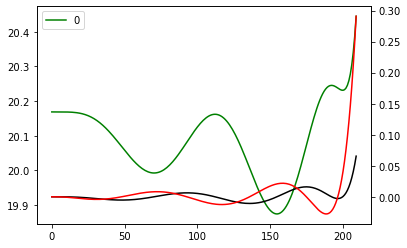

In [676]:
p_degree = 10
first_deriv = 1
second_deriv = 2

lin_reg = LinearRegression()
x_Values = pair_df.index.values.reshape(-1, 1)
y_Values = np.array(pair_df)
poly_features = PolynomialFeatures(degree = p_degree, include_bias = False)
poly_X = poly_features.fit_transform(x_Values)
LR_Fit = lin_reg.fit(poly_X, y_Values)

poly_features_1d = PolynomialFeatures(degree = (p_degree - first_deriv), include_bias = False)
poly_dX = poly_features_1d.fit_transform(x_Values)
n, m = poly_dX.shape
x0 = np.ones((n, 1))
poly_dX_base = np.c_[x0, poly_dX]
poly_deriv = np.array(list(np.poly1d(np.array(list(LR_Fit.coef_[0][::-1]) + [1])).deriv())[::-1])

poly_features_2d = PolynomialFeatures(degree = (p_degree - second_deriv), include_bias = False)
poly_2dX = poly_features_2d.fit_transform(x_Values)
n2, m2 = poly_2dX.shape
x0_2 = np.ones((n2, 1))
poly_2dX_base = np.c_[x0_2, poly_2dX]
poly_2deriv = np.array(list(np.poly1d(np.array(list(poly_deriv)[::-1])).deriv())[::-1])



pd.DataFrame(poly_X.dot(LR_Fit.coef_[0]) + LR_Fit.intercept_).plot(c = 'g').twinx()
plt.plot(poly_dX_base.dot(poly_deriv), c = 'k')
plt.plot(20 * poly_2dX_base.dot(poly_2deriv), c = 'r')



deriv01_df = pd.DataFrame(poly_dX_base.dot(poly_deriv), columns = ['Deriv 01'])
deriv02_df = pd.DataFrame(poly_2dX_base.dot(poly_2deriv), columns = ['Deriv 02'])

d01_df = deriv01_df.copy()
d01_df['Abs'] = abs(d01_df['Deriv 01'])
d01_df['Original Index'] = d01_df.index

prev = 0
Deriv0_pts_df = pd.DataFrame(np.nan, index = [0], columns = ['Local'])
for idx in d01_df.index[1:]:
    if (d01_df.iloc[idx]['Deriv 01'] > 0) & (d01_df.iloc[prev]['Deriv 01'] < 0):
        Deriv0_pts_df.loc[idx] = 'Min'
    if (d01_df.iloc[idx]['Deriv 01'] < 0) & (d01_df.iloc[prev]['Deriv 01'] > 0):
        Deriv0_pts_df.loc[idx] = 'Max'
    prev = idx
Deriv0_pts_df.drop([0], inplace = True)

p = Deriv0_pts_df.index[0]
lows_list = []
highs_list = []
sign = 1
if (Deriv0_pts_df.loc[p][0] == 'Max'):
    sign = -1
    lows_list.append((pair_df.loc[:p][choice_pair] * sign).max() * sign)
else:
    highs_list.append((pair_df.loc[:p][choice_pair] * sign).max() * sign)
p = 0
for i in Deriv0_pts_df.index[:-1]:
    n = Deriv0_pts_df.index[Deriv0_pts_df.index.values.tolist().index(i) + 1]
    sign = 1
    if (Deriv0_pts_df.loc[i][0] == 'Min'):
        sign = -1
        lows_list.append((pair_df.loc[p: n][choice_pair] * sign).max() * sign)
    else:
        highs_list.append((pair_df.loc[p: n][choice_pair] * sign).max() * sign)
    print((pair_df.loc[p: i][choice_pair] * sign).max() * sign)
    p = i  
    
sign = 1
p = Deriv0_pts_df.index[-2]
if (Deriv0_pts_df.iloc[-1][-1] == 'Max'):
    highs_list.append((pair_df.loc[p:][choice_pair] * sign).max() * sign)
else:
    sign = -1
    lows_list.append((pair_df.loc[p:][choice_pair] * sign).max() * sign)
print('')
print('Low List:')
print(lows_list)
print('High List:')
print(highs_list)
lows_df = pd.DataFrame(lows_list, index = np.arange(len(lows_list)), columns = ['Levels'])
highs_df = pd.DataFrame(highs_list, index = np.arange(len(highs_list)), columns = ['Levels'])
lows_df['Positions'] = np.nan
highs_df['Positions'] = np.nan
for idx in lows_df.index:
    lows_df.loc[idx, 'Positions'] = pair_df[pair_df[choice_pair] == lows_list[idx]].index[0]
for idx in highs_df.index:
    highs_df.loc[idx, 'Positions'] = pair_df[pair_df[choice_pair] == highs_list[idx]].index[0]

In [830]:
def ccy_score(*args):
    
    Choice_Old_df = args[0]
    Choice_New_df = args[1]
    CcyOld_df = pd.DataFrame(np.nan, index = Choice_Old_df.index, columns = ['USD', 'EUR', 'GBP', 'JPY', 'AUD', 'CAD', 'MXN', 'BRL'])
    CcyNew_df = pd.DataFrame(np.nan, index = Choice_New_df.index, columns = ['USD', 'EUR', 'GBP', 'JPY', 'AUD', 'CAD', 'MXN', 'BRL'])
    dates_list = Choice_Old_df.index.values.tolist()

    for current_date in dates_list:
        print(current_date)
        CCYOld_Score_df = pd.DataFrame(Choice_Old_df.loc[current_date].dropna().sort_values())
        CCYOld_Score_df['CCY01'] = CCYOld_Score_df.T.columns.map(lambda x: x[:3])
        CCYOld_Score_df['CCY02'] = CCYOld_Score_df.T.columns.map(lambda x: x[3:6])
        CCYOld_Score_df['Score'] = round(CCYOld_Score_df[CCYOld_Score_df.columns[0]], 0)
        CCYOld_Score01_df = pd.DataFrame(CCYOld_Score_df['Score'].values, index = CCYOld_Score_df['CCY01'], columns = ['Score 1'])
        CCYOld_Score02_df = pd.DataFrame(-CCYOld_Score_df['Score'].values, index = CCYOld_Score_df['CCY02'], columns = ['Score 2'])
        SummaryOld_Score01_df = CCYOld_Score01_df.groupby(CCYOld_Score01_df.index).sum()
        SummaryOld_Score02_df = CCYOld_Score02_df.groupby(CCYOld_Score02_df.index).sum()
        FinalScoreOld_df = pd.merge(SummaryOld_Score01_df, SummaryOld_Score02_df, left_index = True, right_index = True, how = 'outer')
        FinalScoreOld_df.fillna(0, inplace = True)
        FinalScoreOld_df['Final Score'] = FinalScoreOld_df['Score 1'] + FinalScoreOld_df['Score 2']
        FinalScoreOld_df.sort_values(by = ['Final Score'], ascending = False, inplace = True)
        CcyOld_df.loc[current_date] = FinalScoreOld_df.loc[CcyOld_df.columns.values.tolist()]['Final Score'].values
        
        CCYNew_Score_df = pd.DataFrame(Choice_New_df.loc[current_date].dropna().sort_values())
        CCYNew_Score_df['CCY01'] = CCYNew_Score_df.T.columns.map(lambda x: x[:3])
        CCYNew_Score_df['CCY02'] = CCYNew_Score_df.T.columns.map(lambda x: x[3:6])
        CCYNew_Score_df['Score'] = round(CCYNew_Score_df[CCYNew_Score_df.columns[0]], 0)
        CCYNew_Score01_df = pd.DataFrame(CCYNew_Score_df['Score'].values, index = CCYNew_Score_df['CCY01'], columns = ['Score 1'])
        CCYNew_Score02_df = pd.DataFrame(-CCYNew_Score_df['Score'].values, index = CCYNew_Score_df['CCY02'], columns = ['Score 2'])
        SummaryNew_Score01_df = CCYNew_Score01_df.groupby(CCYNew_Score01_df.index).sum()
        SummaryNew_Score02_df = CCYNew_Score02_df.groupby(CCYNew_Score02_df.index).sum()
        FinalScoreNew_df = pd.merge(SummaryNew_Score01_df, SummaryNew_Score02_df, left_index = True, right_index = True, how = 'outer')
        FinalScoreNew_df.fillna(0, inplace = True)
        FinalScoreNew_df['Final Score'] = FinalScoreNew_df['Score 1'] + FinalScoreNew_df['Score 2']
        FinalScoreNew_df.sort_values(by = ['Final Score'], ascending = False, inplace = True)
        CcyNew_df.loc[current_date] = FinalScoreNew_df.loc[CcyNew_df.columns.values.tolist()]['Final Score'].values
    
    CcyOld_df = CcyOld_df.clip(-25, 25)
    CcyNew_df = CcyNew_df.clip(-25, 25)
    return CcyOld_df, CcyNew_df

Old_df, New_df = ccy_score(mix_cp_forecast_Adj_df, mix_cp_forecast_N_Adj_df)
Mixed_df = Old_df + New_df
Mixed_df

2017-01-02
2017-01-03
2017-01-04
2017-01-05
2017-01-06
2017-01-09
2017-01-10
2017-01-11
2017-01-12
2017-01-13
2017-01-16
2017-01-17
2017-01-18
2017-01-19
2017-01-20
2017-01-23
2017-01-24
2017-01-25
2017-01-26
2017-01-27
2017-01-30
2017-01-31
2017-02-01
2017-02-02
2017-02-03
2017-02-06
2017-02-07
2017-02-08
2017-02-09
2017-02-10
2017-02-13
2017-02-14
2017-02-15
2017-02-16
2017-02-17
2017-02-20
2017-02-21
2017-02-22
2017-02-23
2017-02-24
2017-02-27
2017-02-28
2017-03-01
2017-03-02
2017-03-03
2017-03-06
2017-03-07
2017-03-08
2017-03-09
2017-03-10
2017-03-13
2017-03-14
2017-03-15
2017-03-16
2017-03-17
2017-03-20
2017-03-21
2017-03-22
2017-03-23
2017-03-24
2017-03-27
2017-03-28
2017-03-29
2017-03-30
2017-03-31
2017-04-03
2017-04-04
2017-04-05
2017-04-06
2017-04-07
2017-04-10
2017-04-11
2017-04-12
2017-04-13
2017-04-14
2017-04-17
2017-04-18
2017-04-19
2017-04-20
2017-04-21
2017-04-24
2017-04-25
2017-04-26
2017-04-27
2017-04-28
2017-05-01
2017-05-02
2017-05-03
2017-05-04
2017-05-05
2017-05-08

2019-12-05
2019-12-06
2019-12-09
2019-12-10
2019-12-11
2019-12-12
2019-12-13
2019-12-16
2019-12-17
2019-12-18
2019-12-19
2019-12-20
2019-12-23
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
2020-01-02
2020-01-03
2020-01-06
2020-01-07
2020-01-08
2020-01-09
2020-01-10
2020-01-13
2020-01-14
2020-01-15
2020-01-16
2020-01-17
2020-01-20
2020-01-21
2020-01-22
2020-01-23
2020-01-24
2020-01-27
2020-01-28
2020-01-29
2020-01-30
2020-01-31
2020-02-03
2020-02-04
2020-02-05
2020-02-06
2020-02-07
2020-02-10
2020-02-11
2020-02-12
2020-02-13
2020-02-14
2020-02-17
2020-02-18
2020-02-19
2020-02-20
2020-02-21
2020-02-24
2020-02-25
2020-02-26
2020-02-27
2020-02-28
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-10
2020-04-13

2022-10-27
2022-10-28
2022-10-31
2022-11-01
2022-11-02
2022-11-03
2022-11-04
2022-11-07
2022-11-08
2022-11-09
2022-11-10
2022-11-11
2022-11-14
2022-11-15
2022-11-16
2022-11-17
2022-11-18
2022-11-21
2022-11-22
2022-11-23
2022-11-24
2022-11-25
2022-11-28
2022-11-29
2022-11-30
2022-12-01
2022-12-02
2022-12-05
2022-12-06
2022-12-07
2022-12-08
2022-12-09
2022-12-12
2022-12-13
2022-12-14
2022-12-15
2022-12-16
2022-12-19
2022-12-20
2022-12-21
2022-12-22
2022-12-23
2022-12-26
2022-12-27
2022-12-28
2022-12-29
2022-12-30
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-27
2023-02-28
2023-03-01
2023-03-02

,USD,EUR,GBP,JPY,AUD,CAD,MXN,BRL
Dates,,,,,,,,
2017-01-02,18.0,-8.0,-11.0,-22.0,-8.0,1.0,-17.0,41.0
2017-01-03,18.0,-7.0,-13.0,-22.0,-10.0,0.0,-13.0,43.0
2017-01-04,19.0,-6.0,-11.0,-30.0,1.0,1.0,-19.0,45.0
2017-01-05,20.0,-10.0,-16.0,-26.0,-1.0,2.0,-18.0,48.0
2017-01-06,13.0,-4.0,-7.0,-24.0,-3.0,2.0,-24.0,43.0
...,...,...,...,...,...,...,...,...
2023-03-15,2.0,-18.0,-24.0,31.0,-20.0,-3.0,24.0,8.0
2023-03-16,2.0,-16.0,-12.0,31.0,-29.0,-3.0,17.0,10.0
2023-03-17,0.0,-15.0,-10.0,28.0,-29.0,-6.0,22.0,10.0


In [832]:
THRESH_UP = 25
THRESH_DOWN = -25
Standard_Size = 1000000
MixedUP_df = Mixed_df[Mixed_df >= THRESH_UP].fillna(0).clip(0, 1)
MixedDOWN_df = Mixed_df[Mixed_df <= THRESH_DOWN].fillna(0).clip(-1, 0)
Mixed_Final = MixedUP_df + MixedDOWN_df
Dates_List = Mixed_Final.index.values.tolist()
Positions_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
Sizes_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
FXPrices_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
for idx, current_date in enumerate(Dates_List):
    Long_List = []
    Short_List = []
    count_long = 0
    count_short = 0
    Long_List = Mixed_Final.loc[current_date][Mixed_Final.loc[current_date] == 1].index.values.tolist()
    Short_List = Mixed_Final.loc[current_date][Mixed_Final.loc[current_date] == -1].index.values.tolist()
    if (idx == 0):
        prev_Short_List = Short_List.copy()
        prev_Long_List = Long_List.copy()
    longs_nr = len(Long_List)
    shorts_nr = len(Short_List)
    if (longs_nr > 0) & (shorts_nr == 0):
        shorts_nr = 1
        Short_List = Mixed_df.loc[current_date].sort_values()[:1].index.values.tolist()
    if (shorts_nr > 0) & (longs_nr == 0):
        longs_nr = 1
        Long_List = Mixed_df.loc[current_date].sort_values()[-1:].index.values.tolist()
    if (shorts_nr > 0):
        long_size = Standard_Size / shorts_nr
    if (longs_nr > 0):
        short_size = Standard_Size / longs_nr
    if (longs_nr > 3):
        Long_List = Mixed_df.loc[current_date].sort_values()[-3:].index.values.tolist()
    if (shorts_nr > 3):
        Short_List = Mixed_df.loc[current_date].sort_values()[:3].index.values.tolist()
    for ccy01 in Long_List:
        for ccy02 in Short_List:
            pair = ccy01 + ccy02
            if (pair in FX_Pairs_List):
                exp = 1
                aux_pair = 'USD' + ccy01
                if (aux_pair not in FX_Pairs_List):
                    aux_pair = ccy01 + 'USD'
                    exp = -1
                count_long = count_long + 1
                col = 'Long ' + str(count_long)
                Positions_df.loc[current_date, col] = pair
                if (prev_Short_List == Short_List) & (prev_Long_List == Long_List) & (idx > 0):
                    Positions_df_s = Positions_df[:idx].copy()
                    lr_date = ((Positions_df_s == Positions_df_s.shift(1)).sum(axis = 1) == len(Positions_df_s.columns)).replace({True: np.nan}).dropna().index[-1]
                else:
                    lr_date = current_date
                FXPrices_df.loc[current_date, col] = FX_Prices_df.loc[current_date, pair]
                if (aux_pair == 'USDUSD'):
                    notional_adj = 1
                else:
                    notional_adj = FX_Prices_df.loc[lr_date, aux_pair] ** exp
                Sizes_df.loc[current_date, col] = long_size * notional_adj
            else:
                pair = ccy02 + ccy01
                exp = 1
                aux_pair = 'USD' + ccy02
                if (aux_pair not in FX_Pairs_List):
                    aux_pair = ccy02 + 'USD'
                    exp = -1
                count_short = count_short + 1
                col = 'Short ' + str(count_short)
                Positions_df.loc[current_date, col] = pair
                if (prev_Short_List == Short_List) & (prev_Long_List == Long_List) & (idx > 0):
                    Positions_df_s = Positions_df[:idx].copy()
                    lr_date = ((Positions_df_s == Positions_df_s.shift(1)).sum(axis = 1) == len(Positions_df_s.columns)).replace({True: np.nan}).dropna().index[-1]
                else:
                    lr_date = current_date
                FXPrices_df.loc[current_date, col] = FX_Prices_df.loc[current_date, pair]
                if (aux_pair == 'USDUSD'):
                    notional_adj = 1
                else:
                    notional_adj = FX_Prices_df.loc[lr_date, aux_pair] ** exp
                Sizes_df.loc[current_date, col] = long_size * notional_adj
    prev_Short_List = Short_List
    prev_Long_List = Long_List
print('Current Positions:')
print(Positions_df.iloc[-1][Positions_df.iloc[-1] != ''])
print('')
print('')
print('Trade Freq: ' + str(round(100 * len(((Positions_df == Positions_df.shift(1)).sum(axis = 1) == 18)[((Positions_df == Positions_df.shift(1)).sum(axis = 1) == 18) == 0])/len(Positions_df.index), 2)))
Positions_df

Current Positions:
Short 1    AUDJPY
Name: 2023-03-21, dtype: object


Trade Freq: 35.13


,Long 1,Long 2,Long 3,Long 4,Long 5,Long 6,Long 7,Long 8,Long 9,Short 1,Short 2,Short 3,Short 4,Short 5,Short 6,Short 7,Short 8,Short 9
2017-01-02,BRLJPY,,,,,,,,,,,,,,,,,
2017-01-03,BRLJPY,,,,,,,,,,,,,,,,,
2017-01-04,BRLJPY,,,,,,,,,,,,,,,,,
2017-01-05,BRLJPY,,,,,,,,,,,,,,,,,
2017-01-06,BRLJPY,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-15,,,,,,,,,,GBPJPY,,,,,,,,
2023-03-16,,,,,,,,,,AUDJPY,,,,,,,,
2023-03-17,,,,,,,,,,AUDJPY,,,,,,,,
2023-03-20,,,,,,,,,,AUDJPY,,,,,,,,


In [833]:
FX_PnL_df = pd.DataFrame(0, index = Positions_df.index, columns = FX_Prices_df.columns)
Pairs_List = FX_PnL_df.columns.values.tolist()
Long_df = Positions_df.T[Positions_df.columns.map(lambda x: x.find('Long')) != -1].T
Short_df = Positions_df.T[Positions_df.columns.map(lambda x: x.find('Short')) != -1].T
for current_pair in Pairs_List:
    print(current_pair)
    go_ahead = False
    Long_Dates_List = Long_df[Long_df == current_pair].dropna(thresh = 1).index.values.tolist()
    Short_Dates_List = Short_df[Short_df == current_pair].dropna(thresh = 1).index.values.tolist()
    if (len(Long_Dates_List) > 0):
        go_ahead = True
        CP_df = pd.DataFrame(7, index = Positions_df.index, columns = [current_pair])
        Px_Series = pd.Series(0, index = Positions_df.index)
        USDAcc_Series = pd.Series(0, index = Positions_df.index)
        CP_df.loc[Long_Dates_List, current_pair] = 1
    if (len(Short_Dates_List) > 0):
        go_ahead = True
        if (len(Long_Dates_List) > 0):
            CP_df.loc[Short_Dates_List, current_pair] = -1
        else:
            CP_df = pd.DataFrame(7, index = Positions_df.index, columns = [current_pair])
            Px_Series = pd.Series(0, index = Positions_df.index)
            CP_df.loc[Short_Dates_List, current_pair] = -1
    if (go_ahead):
        CP_df = CP_df.replace({7: 0})
        if (len(CP_df[current_pair][CP_df[current_pair] != 0].index) > 0):
            Dates_List = CP_df.index.values.tolist()
            unwind = False
            for current_date in Dates_List:
                Px_Series.loc[current_date] = FX_Prices_df.loc[current_date, current_pair]
                USD_pair = 'USD' + current_pair[-3:]
                mult = -1
                if (USD_pair not in FX_Prices_df.columns):
                    USD_pair = current_pair[-3:] + 'USD'
                    mult = 1
                if (USD_pair == 'USDUSD'):
                    USDAcc_Series.loc[current_date] = 1
                else:
                    USDAcc_Series.loc[current_date] = FX_Prices_df.loc[current_date, USD_pair] ** mult
                if (current_date == CP_df.index[0]):
                    if (CP_df.loc[current_date, current_pair] != 0):
                        pos = Positions_df.loc[current_date].values.tolist().index(current_pair)
                        CP_df.loc[current_date, current_pair] = Sizes_df.loc[current_date].values.tolist()[pos]
                else:
                    previous_date = Dates_List[Dates_List.index(current_date) - 1]
                    if (CP_df.loc[current_date, current_pair] != 0):
                        pos = Positions_df.loc[current_date].values.tolist().index(current_pair)
                        CP_df.loc[current_date, current_pair] = Sizes_df.loc[current_date].values.tolist()[pos]
                        unwind = False
                    elif (CP_df.loc[previous_date, current_pair] != 0) & (CP_df.loc[current_date, current_pair] == 0) & (not unwind):
#                       CP_df.loc[current_date, current_pair] = -CP_df.loc[previous_date, current_pair]
                        unwind = True
            Final_CP_df = CP_df - CP_df.shift(1)
            Final_CP_df.iloc[0] = CP_df.iloc[0]
            Final_CP_df['Und Amount'] = Final_CP_df[current_pair]
            Final_CP_df['Acc Amount'] = -Final_CP_df[current_pair] * Px_Series
            Final_CP_df['USD P&L'] = 0
            for current_date in Dates_List:
                Slice_Final_CP_df = Final_CP_df[:current_date]
                cumm_UND = Slice_Final_CP_df['Und Amount'].sum()
                cumm_ACC = Slice_Final_CP_df['Acc Amount'].sum()
                if (cumm_UND == 0) & (cumm_ACC != 0) & (Slice_Final_CP_df.loc[current_date, 'Acc Amount'] != 0):
                    Final_CP_df.loc[current_date, 'USD P&L'] = int(round(cumm_ACC * USDAcc_Series.loc[current_date], 0))
                elif (current_date != Dates_List[0]):
                    Final_CP_df.loc[current_date, 'USD P&L'] = Final_CP_df.iloc[Final_CP_df.index.values.tolist().index(current_date) - 1]['USD P&L']
            FX_PnL_df[current_pair] = Final_CP_df['USD P&L']
print('')
print('Total:  USD ' + str("{:,d}".format(int(round(FX_PnL_df.iloc[-1].sum(), 0)))))
print('')
print('Summary')
FX_PnL_df.iloc[-1]

EURUSD


NameError: name 'USDAcc_Series' is not defined

In [ ]:
####################################################### fx algo #################################################################

def ccy_score(*args):
    
    Choice_Old_df = args[0]
    Choice_New_df = args[1]
    OL = args[2]
    OU = args[3]
    NL = args[4]
    NU = args[5]
    CcyOld_df = pd.DataFrame(np.nan, index = Choice_Old_df.index, columns = ['USD', 'EUR', 'GBP', 'JPY', 'AUD', 'CAD', 'MXN', 'BRL'])
    CcyNew_df = pd.DataFrame(np.nan, index = Choice_New_df.index, columns = ['USD', 'EUR', 'GBP', 'JPY', 'AUD', 'CAD', 'MXN', 'BRL'])
    dates_list = Choice_Old_df.index.values.tolist()
    
    prev_year = dates_list[0].year
    print(prev_year)
    for current_date in dates_list:
        if (current_date.year != prev_year):
            print(current_date.year)
        prev_year = current_date.year
        CCYOld_Score_df = pd.DataFrame(Choice_Old_df.loc[current_date].dropna().sort_values())
        CCYOld_Score_df['CCY01'] = CCYOld_Score_df.T.columns.map(lambda x: x[:3])
        CCYOld_Score_df['CCY02'] = CCYOld_Score_df.T.columns.map(lambda x: x[3:6])
        CCYOld_Score_df['Score'] = round(CCYOld_Score_df[CCYOld_Score_df.columns[0]], 0)
        CCYOld_Score01_df = pd.DataFrame(CCYOld_Score_df['Score'].values, index = CCYOld_Score_df['CCY01'], columns = ['Score 1'])
        CCYOld_Score02_df = pd.DataFrame(-CCYOld_Score_df['Score'].values, index = CCYOld_Score_df['CCY02'], columns = ['Score 2'])
        SummaryOld_Score01_df = CCYOld_Score01_df.groupby(CCYOld_Score01_df.index).sum()
        SummaryOld_Score02_df = CCYOld_Score02_df.groupby(CCYOld_Score02_df.index).sum()
        FinalScoreOld_df = pd.merge(SummaryOld_Score01_df, SummaryOld_Score02_df, left_index = True, right_index = True, how = 'outer')
        FinalScoreOld_df.fillna(0, inplace = True)
        FinalScoreOld_df['Final Score'] = FinalScoreOld_df['Score 1'] + FinalScoreOld_df['Score 2']
        FinalScoreOld_df.sort_values(by = ['Final Score'], ascending = False, inplace = True)
        CcyOld_df.loc[current_date] = FinalScoreOld_df.loc[CcyOld_df.columns.values.tolist()]['Final Score'].values
        CCYNew_Score_df = pd.DataFrame(Choice_New_df.loc[current_date].dropna().sort_values())
        CCYNew_Score_df['CCY01'] = CCYNew_Score_df.T.columns.map(lambda x: x[:3])
        CCYNew_Score_df['CCY02'] = CCYNew_Score_df.T.columns.map(lambda x: x[3:6])
        CCYNew_Score_df['Score'] = round(CCYNew_Score_df[CCYNew_Score_df.columns[0]], 0)
        CCYNew_Score01_df = pd.DataFrame(CCYNew_Score_df['Score'].values, index = CCYNew_Score_df['CCY01'], columns = ['Score 1'])
        CCYNew_Score02_df = pd.DataFrame(-CCYNew_Score_df['Score'].values, index = CCYNew_Score_df['CCY02'], columns = ['Score 2'])
        SummaryNew_Score01_df = CCYNew_Score01_df.groupby(CCYNew_Score01_df.index).sum()
        SummaryNew_Score02_df = CCYNew_Score02_df.groupby(CCYNew_Score02_df.index).sum()
        FinalScoreNew_df = pd.merge(SummaryNew_Score01_df, SummaryNew_Score02_df, left_index = True, right_index = True, how = 'outer')
        FinalScoreNew_df.fillna(0, inplace = True)
        FinalScoreNew_df['Final Score'] = FinalScoreNew_df['Score 1'] + FinalScoreNew_df['Score 2']
        FinalScoreNew_df.sort_values(by = ['Final Score'], ascending = False, inplace = True)
        CcyNew_df.loc[current_date] = FinalScoreNew_df.loc[CcyNew_df.columns.values.tolist()]['Final Score'].values
    
    CcyOld_df = CcyOld_df.clip(OL, OU)
    CcyNew_df = CcyNew_df.clip(NL, NU)
    return CcyOld_df, CcyNew_df


OLD_LOWER = -10
OLD_UPPER = 10
NEW_LOWER = -50
NEW_UPPER = 50

THRESH_UP = 30
THRESH_DOWN = -30

FX_Costs = 5/10000

Old_df, New_df = ccy_score(mix_cp_forecast_Adj_df, mix_cp_forecast_N_Adj_df, OLD_LOWER, OLD_UPPER, NEW_LOWER, NEW_UPPER)
Mixed_df = Old_df + New_df

###################################################################################################################################

Standard_Size = 1000000
MixedUP_df = Mixed_df[Mixed_df >= THRESH_UP].fillna(0).clip(0, 1)
MixedDOWN_df = Mixed_df[Mixed_df <= THRESH_DOWN].fillna(0).clip(-1, 0)
Mixed_Final = MixedUP_df + MixedDOWN_df
Dates_List = Mixed_Final.index.values.tolist()
Positions_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
Sizes_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
FXPrices_df = pd.DataFrame('', index = Dates_List, columns = ['Long 1', 'Long 2', 'Long 3', 'Long 4', 'Long 5', 'Long 6', 'Long 7', 'Long 8', 'Long 9', 'Short 1', 'Short 2', 'Short 3', 'Short 4', 'Short 5', 'Short 6', 'Short 7', 'Short 8', 'Short 9'])
for idx, current_date in enumerate(Dates_List):
    Long_List = []
    Short_List = []
    count_long = 0
    count_short = 0
    Long_List = Mixed_Final.loc[current_date][Mixed_Final.loc[current_date] == 1].index.values.tolist()
    Short_List = Mixed_Final.loc[current_date][Mixed_Final.loc[current_date] == -1].index.values.tolist()
    if (idx == 0):
        prev_Short_List = Short_List.copy()
        prev_Long_List = Long_List.copy()
    longs_nr = len(Long_List)
    shorts_nr = len(Short_List)
    if (longs_nr > 0) & (shorts_nr == 0):
        shorts_nr = 1
        Short_List = Mixed_df.loc[current_date].sort_values()[:1].index.values.tolist()
    if (shorts_nr > 0) & (longs_nr == 0):
        longs_nr = 1
        Long_List = Mixed_df.loc[current_date].sort_values()[-1:].index.values.tolist()
    if (shorts_nr > 0):
        long_size = Standard_Size / shorts_nr
    if (longs_nr > 0):
        short_size = Standard_Size / longs_nr
    if (longs_nr > 3):
        Long_List = Mixed_df.loc[current_date].sort_values()[-3:].index.values.tolist()
    if (shorts_nr > 3):
        Short_List = Mixed_df.loc[current_date].sort_values()[:3].index.values.tolist()
    for ccy01 in Long_List:
        for ccy02 in Short_List:
            pair = ccy01 + ccy02
            if (pair in FX_Pairs_List):
                exp = 1
                aux_pair = 'USD' + ccy01
                if (aux_pair not in FX_Pairs_List):
                    aux_pair = ccy01 + 'USD'
                    exp = -1
                count_long = count_long + 1
                col = 'Long ' + str(count_long)
                Positions_df.loc[current_date, col] = pair
                if (prev_Short_List == Short_List) & (prev_Long_List == Long_List) & (idx > 0):
                    Positions_df_s = Positions_df[:idx].copy()
                    lr_date = ((Positions_df_s == Positions_df_s.shift(1)).sum(axis = 1) == len(Positions_df_s.columns)).replace({True: np.nan}).dropna().index[-1]
                else:
                    lr_date = current_date
                FXPrices_df.loc[current_date, col] = FX_Prices_df.loc[current_date, pair]
                if (aux_pair == 'USDUSD'):
                    notional_adj = 1
                else:
                    notional_adj = FX_Prices_df.loc[lr_date, aux_pair] ** exp
                Sizes_df.loc[current_date, col] = long_size * notional_adj
            else:
                pair = ccy02 + ccy01
                exp = 1
                aux_pair = 'USD' + ccy02
                if (aux_pair not in FX_Pairs_List):
                    aux_pair = ccy02 + 'USD'
                    exp = -1
                count_short = count_short + 1
                col = 'Short ' + str(count_short)
                Positions_df.loc[current_date, col] = pair
                if (prev_Short_List == Short_List) & (prev_Long_List == Long_List) & (idx > 0):
                    Positions_df_s = Positions_df[:idx].copy()
                    lr_date = ((Positions_df_s == Positions_df_s.shift(1)).sum(axis = 1) == len(Positions_df_s.columns)).replace({True: np.nan}).dropna().index[-1]
                else:
                    lr_date = current_date
                FXPrices_df.loc[current_date, col] = FX_Prices_df.loc[current_date, pair]
                if (aux_pair == 'USDUSD'):
                    notional_adj = 1
                else:
                    notional_adj = FX_Prices_df.loc[lr_date, aux_pair] ** exp
                Sizes_df.loc[current_date, col] = long_size * notional_adj
    prev_Short_List = Short_List
    prev_Long_List = Long_List
print('')

#####################################################################################################################################

FX_PnL_df = pd.DataFrame(0, index = Positions_df.index, columns = FX_Prices_df.columns)
Pairs_List = FX_PnL_df.columns.values.tolist()
Long_df = Positions_df.T[Positions_df.columns.map(lambda x: x.find('Long')) != -1].T
Short_df = Positions_df.T[Positions_df.columns.map(lambda x: x.find('Short')) != -1].T
TradingCosts_ttl = 0
for current_pair in Pairs_List:
    print(current_pair)
    go_ahead = False
    Long_Dates_List = Long_df[Long_df == current_pair].dropna(thresh = 1).index.values.tolist()
    Short_Dates_List = Short_df[Short_df == current_pair].dropna(thresh = 1).index.values.tolist()
    Px_Series = pd.Series(0, index = Positions_df.index)
    USDAcc_Series = pd.Series(0, index = Positions_df.index)
    USDUnd_Series = pd.Series(0, index = Positions_df.index)
    if (len(Long_Dates_List) > 0):
        go_ahead = True
        CP_df = pd.DataFrame(7, index = Positions_df.index, columns = [current_pair])
        CP_df.loc[Long_Dates_List, current_pair] = 1
    if (len(Short_Dates_List) > 0):
        go_ahead = True
        if (len(Long_Dates_List) > 0):
            CP_df.loc[Short_Dates_List, current_pair] = -1
        else:
            CP_df = pd.DataFrame(7, index = Positions_df.index, columns = [current_pair])
            Px_Series = pd.Series(0, index = Positions_df.index)
            CP_df.loc[Short_Dates_List, current_pair] = -1
    if (go_ahead):
        CP_df = CP_df.replace({7: 0})
        if (len(CP_df[current_pair][CP_df[current_pair] != 0].index) > 0):
            Dates_List = CP_df.index.values.tolist()
            unwind = False
            for current_date in Dates_List:
                Px_Series.loc[current_date] = FX_Prices_df.loc[current_date, current_pair]
                USD_pair_acc = 'USD' + current_pair[-3:]
                USD_pair_und = 'USD' + current_pair[:-3]
                mult = -1
                if (USD_pair_acc not in FX_Prices_df.columns):
                    USD_pair_acc = current_pair[-3:] + 'USD'
                    mult = 1
                if (USD_pair_acc == 'USDUSD'):
                    USDAcc_Series.loc[current_date] = 1
                else:
                    USDAcc_Series.loc[current_date] = FX_Prices_df.loc[current_date, USD_pair_acc] ** mult
                mult2 = -1
                if (USD_pair_und not in FX_Prices_df.columns):
                    USD_pair_und = current_pair[:-3] + 'USD'
                    mult2 = 1
                if (USD_pair_und == 'USDUSD'):
                    USDUnd_Series.loc[current_date] = 1
                else:
                    USDUnd_Series.loc[current_date] = FX_Prices_df.loc[current_date, USD_pair_und] ** mult2
                if (current_date == CP_df.index[0]):
                    if (CP_df.loc[current_date, current_pair] != 0):
                        pos = Positions_df.loc[current_date].values.tolist().index(current_pair)
                        CP_df.loc[current_date, current_pair] = Sizes_df.loc[current_date].values.tolist()[pos]
                else:
                    previous_date = Dates_List[Dates_List.index(current_date) - 1]
                    if (CP_df.loc[current_date, current_pair] != 0):
                        pos = Positions_df.loc[current_date].values.tolist().index(current_pair)
                        CP_df.loc[current_date, current_pair] = Sizes_df.loc[current_date].values.tolist()[pos]
                        unwind = False
                    elif (CP_df.loc[previous_date, current_pair] != 0) & (CP_df.loc[current_date, current_pair] == 0) & (not unwind):
                        unwind = True
            Final_CP_df = CP_df - CP_df.shift(1)
            Final_CP_df.iloc[0] = CP_df.iloc[0]
            Final_CP_df['Und Amount'] = Final_CP_df[current_pair]
            Final_CP_df['Acc Amount'] = -Final_CP_df[current_pair] * Px_Series
            Final_CP_df['USD P&L'] = 0
            Final_CP_df['Trading Costs'] = 0
            for current_date in Dates_List:
                Slice_Final_CP_df = Final_CP_df[:current_date]
                cumm_UND = Slice_Final_CP_df['Und Amount'].sum()
                cumm_ACC = Slice_Final_CP_df['Acc Amount'].sum()
                if (cumm_UND == 0) & (cumm_ACC != 0) & (Slice_Final_CP_df.loc[current_date, 'Acc Amount'] != 0):
                    Final_CP_df.loc[current_date, 'USD P&L'] = int(round(cumm_ACC * USDAcc_Series.loc[current_date], 0))
                elif (current_date != Dates_List[0]):
                    Final_CP_df.loc[current_date, 'USD P&L'] = Final_CP_df.iloc[Final_CP_df.index.values.tolist().index(current_date) - 1]['USD P&L']
            Final_CP_df['Trading Costs'] = round(-abs(Final_CP_df['Und Amount']) * USDUnd_Series * FX_Costs, 0)
            FX_PnL_df[current_pair] = Final_CP_df['USD P&L'] + Final_CP_df['Trading Costs'].expanding().sum()
            TradingCosts_ttl = TradingCosts_ttl + Final_CP_df['Trading Costs'].sum()

print('')
print('Total Net P&L       :  USD ' + str("{:,d}".format(int(round(FX_PnL_df.iloc[-1].sum(), 0)))))
print('Ex-BRL Total Net P&L:  USD ' + str("{:,d}".format(int(round(FX_PnL_df.T[FX_PnL_df.columns.map(lambda x: x.find('BRL')) == -1].T.iloc[-1].sort_values().sum(), 0)))))
print('Total Costs         :  USD ' + str("{:,d}".format(int(TradingCosts_ttl))))
print('')
print('Current Positions:')
print(Positions_df.iloc[-1][Positions_df.iloc[-1] != ''])
print('')
print('Trade Freq: ' + str(round(100 * len(((Positions_df == Positions_df.shift(1)).sum(axis = 1) == 18)[((Positions_df == Positions_df.shift(1)).sum(axis = 1) == 18) == 0])/len(Positions_df.index), 2)))
print('')
print('Summary')
SummaryPair_df = pd.DataFrame(FX_PnL_df.iloc[-1].sort_values(ascending = False))
SummaryCcy_df = pd.DataFrame(0, index = ['Total (USD)'], columns = ['USD', 'EUR', 'GBP', 'JPY', 'AUD', 'CAD', 'MXN', 'BRL'])
for current_ccy in SummaryCcy_df.columns:
    SummaryCcy_df.loc['Total (USD)', current_ccy] = SummaryPair_df[SummaryPair_df.T.columns.map(lambda x: x.find(current_ccy)) != -1].sum()[0]

print('CCY Summary')
print(SummaryCcy_df.T.sort_values(by = ['Total (USD)'], ascending = False))
print('')
print('FX Pairs Summary')
SummaryPair_df

In [ ]:
## FORECAST VISUALIZATION - ALL

pair_l = FX_Prices_df.columns.values.tolist()
c = 0
for idx_, sel_pair in enumerate(pair_l):
    forecast_list = EN_FX_Forecast_df.T[EN_FX_Forecast_df.columns.map(lambda x: x.find(sel_pair)) != -1].T.columns.values.tolist()
    for idx, curr in enumerate(forecast_list):
        plt.figure(c, figsize = (13, 5))
        FX_Prices_df[sel_pair].loc[EN_FX_Forecast_df.index].plot(c = 'k').twinx()
        EN_FX_Forecast_df[curr].plot(alpha = 0.5)
        LR_FX_Forecast_df[curr].clip(-2, 2).plot(alpha = 0.5, label = sel_pair).legend(loc = 'best')
        RF_FX_Forecast_df[curr].clip(-2, 2).plot(alpha = 0.5)
        ttl = round(EN_FX_Forecast_df.iloc[-1][curr] + LR_FX_Forecast_df.iloc[-1][curr] + RF_FX_Forecast_df.iloc[-1][curr], 2)
        if (idx == 0):
            print(sel_pair + ' ST TTL FORECAST: ' + str(ttl))
        else:
            print(sel_pair + ' MT TTL FORECAST: ' + str(ttl))
        c = c + 1
    print('')